# Credit Risk

**Author**: Gerend Christopher \
**Email**: gerendc@gmail.com 

---

**Disclaimer**: The dataset is obtained from [Kaggle](https://www.kaggle.com/datasets/laotse/credit-risk-dataset) with CC0 License \
\
Description: This dataset contains columns simulating credit bureau data.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

import function as f

%matplotlib inline
np.random.seed(42)

# set figure size
plt.rcParams["figure.figsize"] = (15,8)

# set seaborn style
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette='tab10')

# Data Understanding

In [3]:
cr_df = pd.read_csv('credit_risk_dataset.csv')
cr_df

person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32576          57          53000              MORTGAGE                1.0   
32577          54         120000              MORTGAGE                4.0   
32578          65          76000                  RENT                3.0   
32579          56         150000              MORTGAGE                5.0   
32580          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0             PERSONAL          D      35000          16.02            1   
1            EDUCATION          B       1000          11.14            0   
2              MEDICAL          C       5500          12.87            1   
3              MEDICAL          C      35000          15.23            1   
4              MEDICAL          C      35000          14.27            1   
...                ...        ...        ...            ...          ...   
32576         PERSONAL          C       5800          13.16            0   
32577         PERSONAL          A      17625           7.49            0   
32578  HOMEIMPROVEMENT          B      35000          10.99            1   
32579         PERSONAL          B      15000          11.48            0   
32580          MEDICAL          B       6475           9.99            0   

       loan_percent_income cb_person_default_on_file  \
0                     0.59                         Y   
1                     0.10                         N   
2                     0.57                         N   
3                     0.53                         N   
4                     0.55                         Y   
...                    ...                       ...   
32576                 0.11                         N   
32577                 0.15                         N   
32578                 0.46                         N   
32579                 0.10                         N   
32580                 0.15                         N   

       cb_person_cred_hist_length  
0                               3  
1                               2  
2                               3  
3                               2  
4                               4  
...                           ...  
32576                          30  
32577                          19  
32578                          28  
32579                          26  
32580                          30  

[32581 rows x 12 columns]

In [7]:
cr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


The dataset has **32581 entries** and **12 columns/features**

**Dataset Details**: \
person_age : Age\
person_income : Annual Income\
person_home_ownership : Home ownership\
person_emp_length : Employment length (in years)\
loan_intent : Loan intent\
loan_grade : Loan grade\
loan_amnt : Loan amount\
loan_int_rate : Interest rate\
loan_status : Loan status (0 is non default 1 is default)\
loan_percent_income : Percent income\
cb_person_default_on_file : Historical default\
cb_person_cred_hist_length : Credit history length

Additional Information: ***Default*** is the failure to repay a loan according to the terms agreed to in the promissory note. ([source](https://www.consumerfinance.gov/ask-cfpb/what-happens-if-i-default-on-a-federal-student-loan-en-663/#:~:text=Default%20is%20the%20failure%20to,in%20more%20than%20270%20days.))

# Data Cleaning

## Duplicates

In [8]:
display(cr_df[cr_df.drop(columns='cb_person_default_on_file').duplicated(keep=False)].sort_values(by=['person_age', 'person_income']))

person_age  person_income person_home_ownership  person_emp_length  \
15944          21           8088                  RENT                NaN   
16835          21           8088                  RENT                NaN   
2431           21          15600                  RENT                0.0   
17758          21          15600                  RENT                0.0   
2498           21          18000                  RENT                0.0   
...           ...            ...                   ...                ...   
32279          43          11340                  RENT                4.0   
31676          49         120000              MORTGAGE               12.0   
32172          49         120000              MORTGAGE               12.0   
32421          57          53000              MORTGAGE                1.0   
32576          57          53000              MORTGAGE                1.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
15944            MEDICAL          C       1200          15.23            0   
16835            MEDICAL          C       1200          15.23            0   
2431             MEDICAL          A       2800           7.40            1   
17758            MEDICAL          A       2800           7.40            1   
2498   DEBTCONSOLIDATION          A       3000           7.90            1   
...                  ...        ...        ...            ...          ...   
32279          EDUCATION          C       1950            NaN            1   
31676            MEDICAL          B      12000          10.99            0   
32172            MEDICAL          B      12000          10.99            0   
32421           PERSONAL          C       5800          13.16            0   
32576           PERSONAL          C       5800          13.16            0   

       loan_percent_income cb_person_default_on_file  \
15944                 0.15                         Y   
16835                 0.15                         Y   
2431                  0.18                         N   
17758                 0.18                         N   
2498                  0.17                         N   
...                    ...                       ...   
32279                 0.17                         N   
31676                 0.10                         N   
32172                 0.10                         N   
32421                 0.11                         Y   
32576                 0.11                         N   

       cb_person_cred_hist_length  
15944                           2  
16835                           2  
2431                            4  
17758                           4  
2498                            2  
...                           ...  
32279                          11  
31676                          12  
32172                          12  
32421                          30  
32576                          30  

[392 rows x 12 columns]

In [4]:
# check duplicates
print(f'There are {cr_df.duplicated().sum()} duplicates')
display(cr_df[cr_df.duplicated(keep=False)].sort_values(by=['person_age', 'person_income']))

# drop duplicates
cr_df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

There are 165 duplicates


person_age  person_income person_home_ownership  person_emp_length  \
15944          21           8088                  RENT                NaN   
16835          21           8088                  RENT                NaN   
2431           21          15600                  RENT                0.0   
17758          21          15600                  RENT                0.0   
2498           21          18000                  RENT                0.0   
...           ...            ...                   ...                ...   
32010          42          39996              MORTGAGE                2.0   
29484          43          11340                  RENT                4.0   
32279          43          11340                  RENT                4.0   
31676          49         120000              MORTGAGE               12.0   
32172          49         120000              MORTGAGE               12.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
15944            MEDICAL          C       1200          15.23            0   
16835            MEDICAL          C       1200          15.23            0   
2431             MEDICAL          A       2800           7.40            1   
17758            MEDICAL          A       2800           7.40            1   
2498   DEBTCONSOLIDATION          A       3000           7.90            1   
...                  ...        ...        ...            ...          ...   
32010    HOMEIMPROVEMENT          A       2500           5.42            0   
29484          EDUCATION          C       1950            NaN            1   
32279          EDUCATION          C       1950            NaN            1   
31676            MEDICAL          B      12000          10.99            0   
32172            MEDICAL          B      12000          10.99            0   

       loan_percent_income cb_person_default_on_file  \
15944                 0.15                         Y   
16835                 0.15                         Y   
2431                  0.18                         N   
17758                 0.18                         N   
2498                  0.17                         N   
...                    ...                       ...   
32010                 0.06                         N   
29484                 0.17                         N   
32279                 0.17                         N   
31676                 0.10                         N   
32172                 0.10                         N   

       cb_person_cred_hist_length  
15944                           2  
16835                           2  
2431                            4  
17758                           4  
2498                            2  
...                           ...  
32010                          12  
29484                          11  
32279                          11  
31676                          12  
32172                          12  

[330 rows x 12 columns]

Here, we have some duplication in our data. We drop it since duplicated data will show a bias to one group of data, such as 21 years old person propose credit more than other age.

In [8]:
# check duplicates with different loan status and cb_person_default_on_file

display(cr_df[cr_df.drop(columns='loan_status').duplicated(keep=False)].sort_values(by=['person_age', 'person_income']))
display(cr_df[cr_df.drop(columns='cb_person_default_on_file').duplicated(keep=False)].sort_values(by=['person_age', 'person_income']))

Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_status, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length]
Index: []

person_age  person_income person_home_ownership  person_emp_length  \
4440           22          42996                  RENT                3.0   
16593          22          42996                  RENT                3.0   
7826           22          55000              MORTGAGE                6.0   
16208          22          55000              MORTGAGE                6.0   
1513           22          69600                  RENT                6.0   
...           ...            ...                   ...                ...   
28943          34         220000              MORTGAGE               13.0   
29869          41          38200                  RENT                4.0   
31936          41          38200                  RENT                4.0   
32256          57          53000              MORTGAGE                1.0   
32411          57          53000              MORTGAGE                1.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
4440            PERSONAL          C       4800          11.03            0   
16593           PERSONAL          C       4800          11.03            0   
7826           EDUCATION          C       1400          13.49            0   
16208          EDUCATION          C       1400          13.49            0   
1513   DEBTCONSOLIDATION          C       1350          12.68            0   
...                  ...        ...        ...            ...          ...   
28943  DEBTCONSOLIDATION          C      11275          12.99            0   
29869            MEDICAL          E       8875          19.03            0   
31936            MEDICAL          E       8875          19.03            0   
32256           PERSONAL          C       5800          13.16            0   
32411           PERSONAL          C       5800          13.16            0   

       loan_percent_income cb_person_default_on_file  \
4440                  0.11                         N   
16593                 0.11                         Y   
7826                  0.03                         N   
16208                 0.03                         Y   
1513                  0.02                         N   
...                    ...                       ...   
28943                 0.05                         Y   
29869                 0.23                         N   
31936                 0.23                         Y   
32256                 0.11                         Y   
32411                 0.11                         N   

       cb_person_cred_hist_length  
4440                            4  
16593                           4  
7826                            3  
16208                           3  
1513                            3  
...                           ...  
28943                           8  
29869                          11  
31936                          11  
32256                          30  
32411                          30  

[62 rows x 12 columns]

We have duplicates data that have different historical default. We don't know if it is the same person since there is no `ID` and we don't know which should be dropped since there is no `time` in our data.\
For now, we will keep the data.

## Anomaly

In [12]:
cr_df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32416.000000   3.241600e+04        31529.00000  32416.000000   
mean      27.747008   6.609164e+04            4.79051   9593.845632   
std        6.354100   6.201558e+04            4.14549   6322.730241   
min       20.000000   4.000000e+03            0.00000    500.000000   
25%       23.000000   3.854200e+04            2.00000   5000.000000   
50%       26.000000   5.500000e+04            4.00000   8000.000000   
75%       30.000000   7.921800e+04            7.00000  12250.000000   
max      144.000000   6.000000e+06          123.00000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29321.000000  32416.000000         32416.000000   
mean       11.017265      0.218688             0.170250   
std         3.241680      0.413363             0.106812   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.470000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_cred_hist_length  
count                32416.000000  
mean                     5.811297  
std                      4.059030  
min                      2.000000  
25%                      3.000000  
50%                      4.000000  
75%                      8.000000  
max                     30.000000

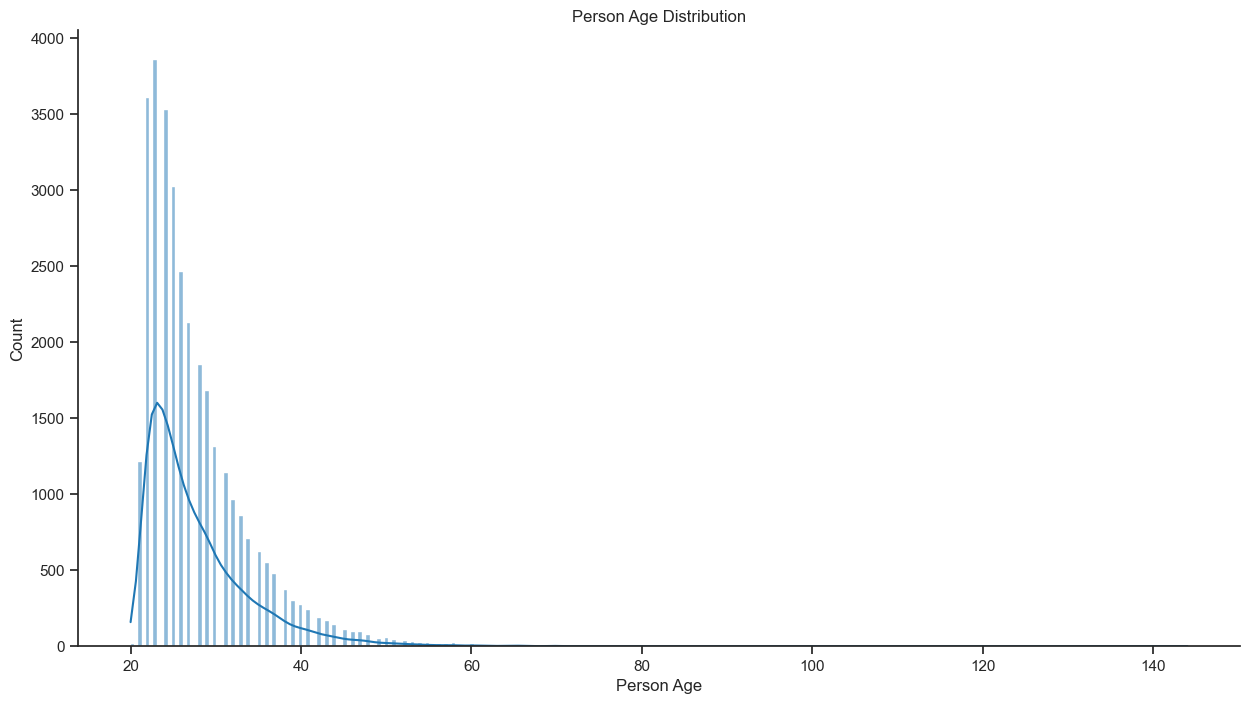

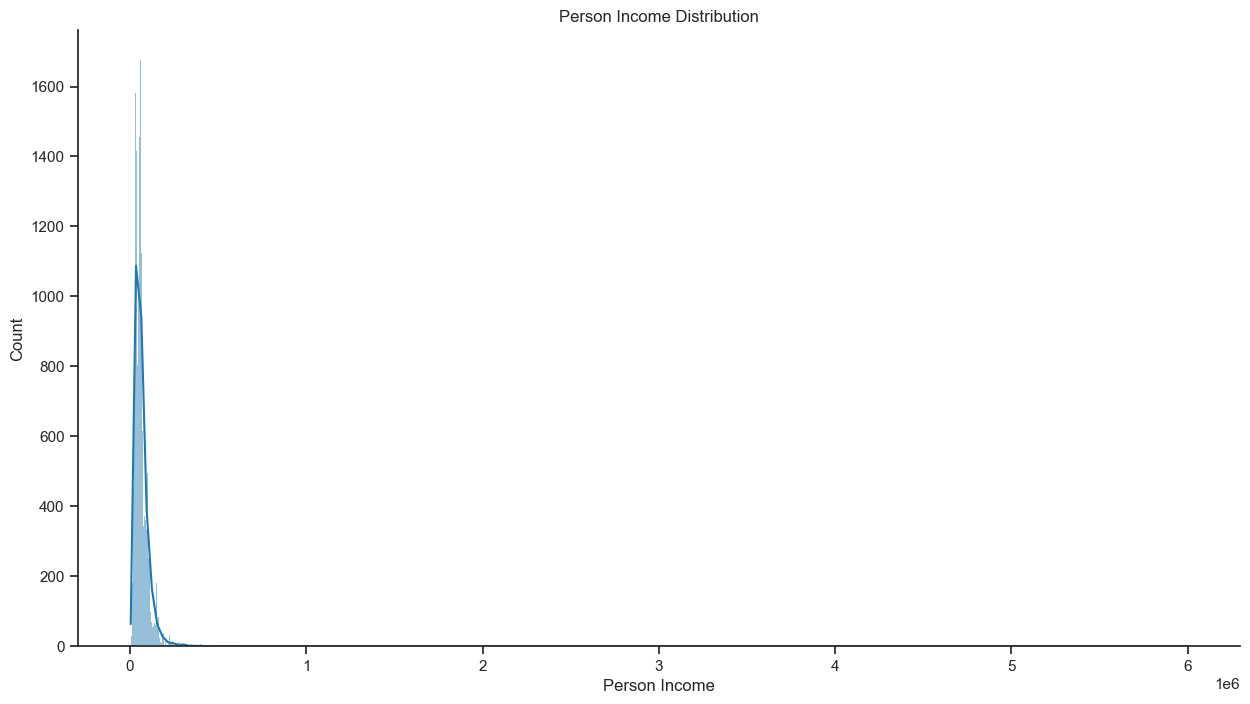

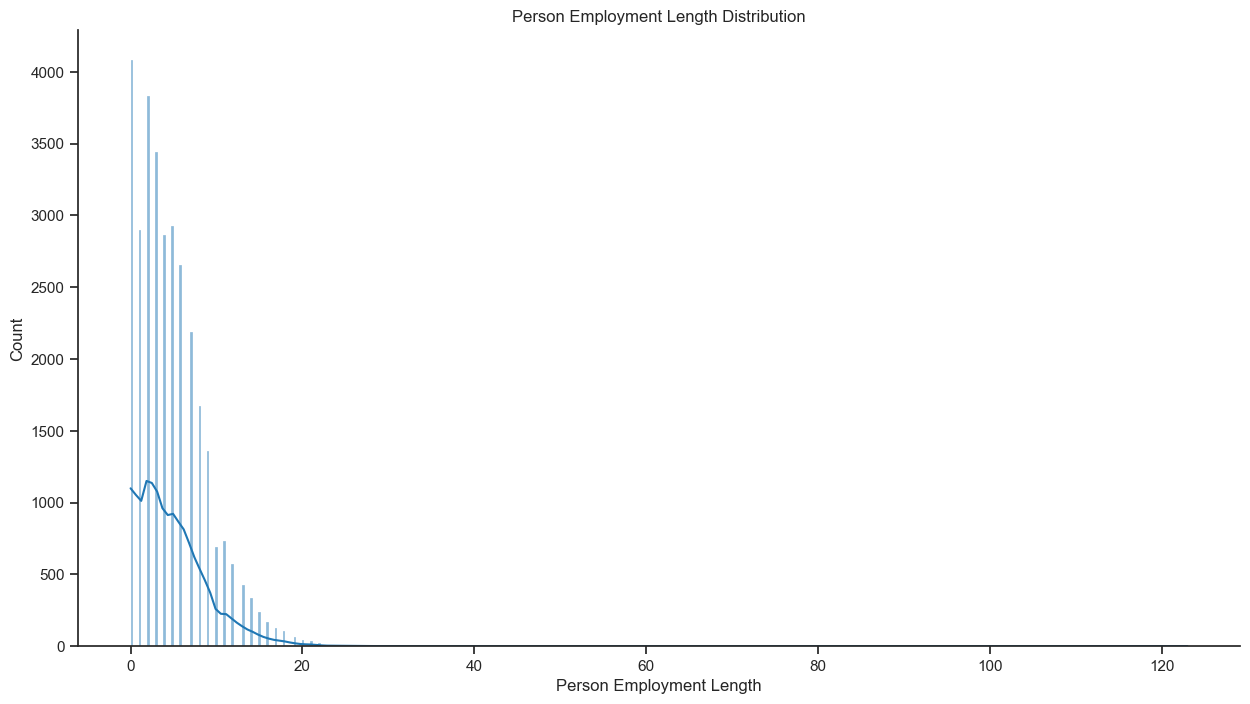

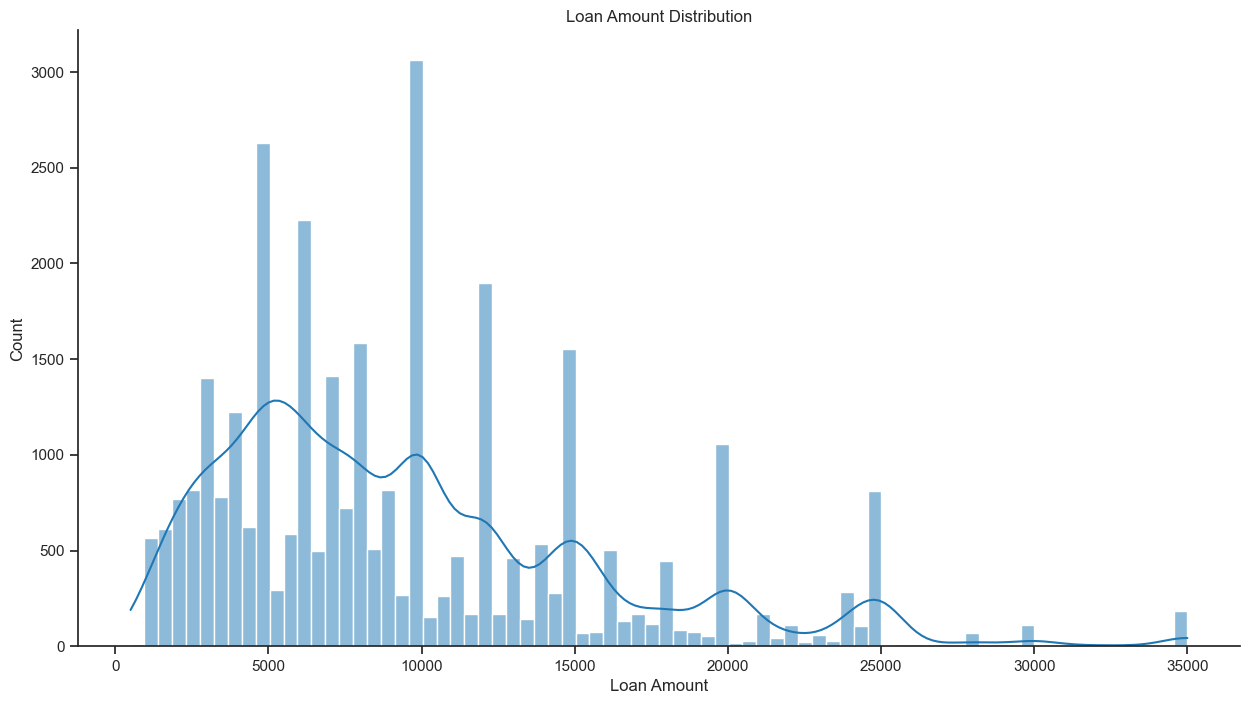

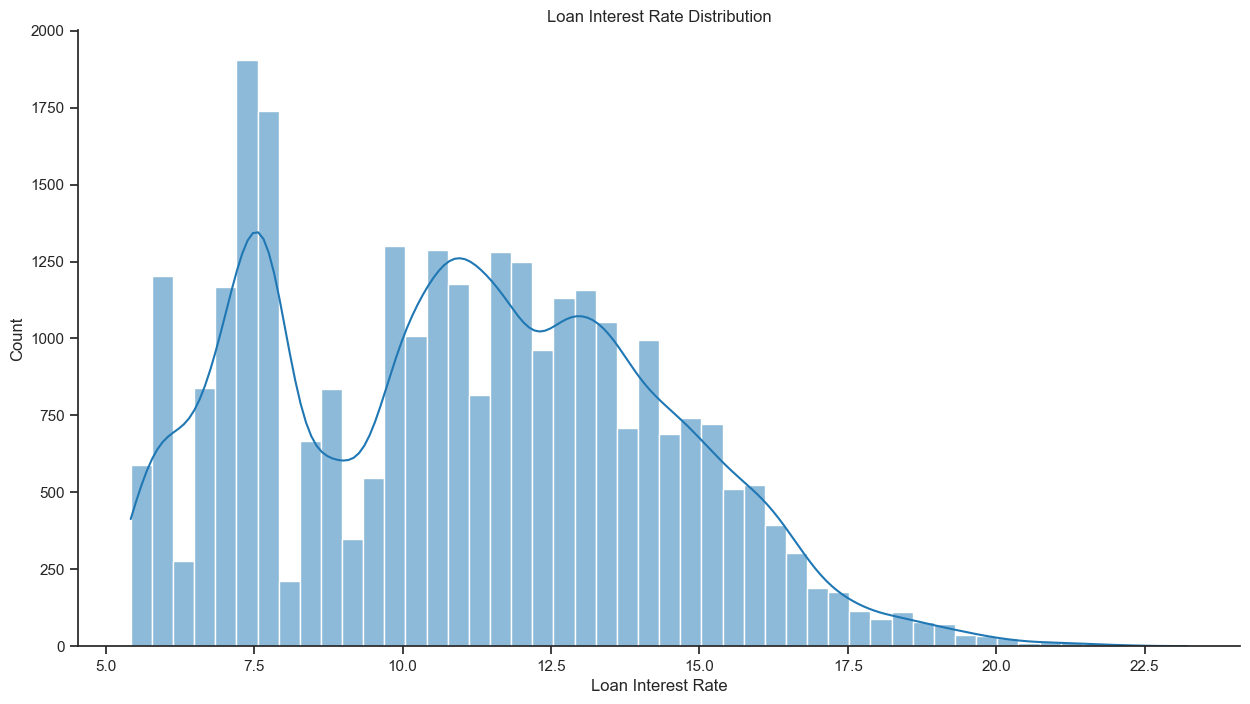

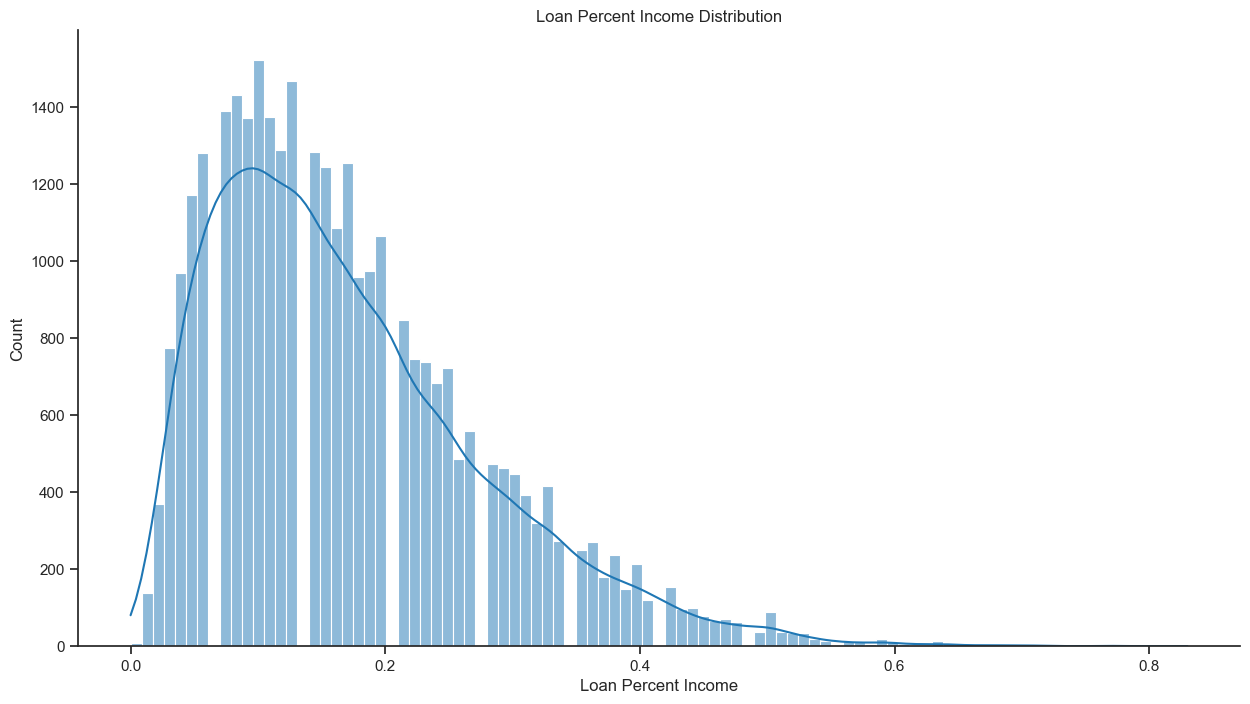

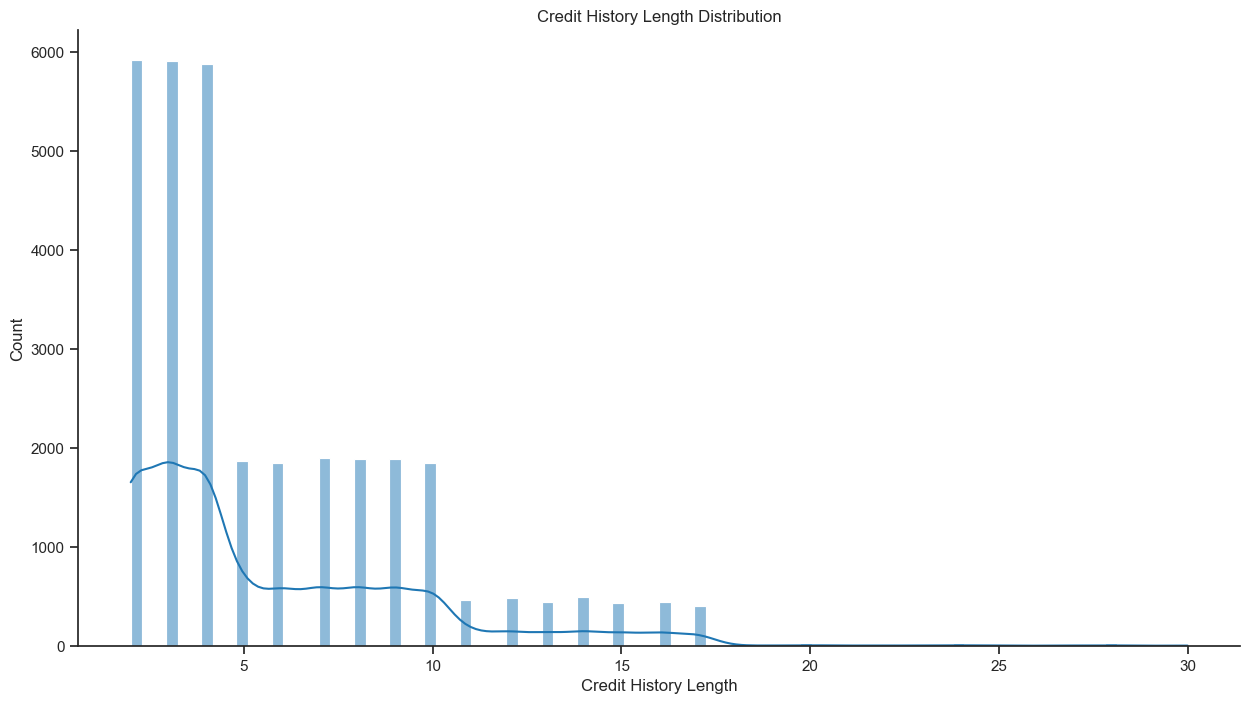

In [6]:
def plotHistogram(data, x, xlabel, ylabel, title):
    plt.figure()
    ax = sns.histplot(data=data, x=x, kde=True)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return ax

ax1 = plotHistogram(data=cr_df, x='person_age', xlabel='Person Age', ylabel='Count', title='Person Age Distribution')
ax2 = plotHistogram(data=cr_df, x='person_income', xlabel='Person Income', ylabel='Count', title='Person Income Distribution')
ax3 = plotHistogram(data=cr_df, x='person_emp_length', xlabel='Person Employment Length', ylabel='Count', title='Person Employment Length Distribution')
ax4 = plotHistogram(data=cr_df, x='loan_amnt', xlabel='Loan Amount', ylabel='Count', title='Loan Amount Distribution')
ax5 = plotHistogram(data=cr_df, x='loan_int_rate', xlabel='Loan Interest Rate', ylabel='Count', title='Loan Interest Rate Distribution')
ax6 = plotHistogram(data=cr_df, x='loan_percent_income', xlabel='Loan Percent Income', ylabel='Count', title='Loan Percent Income Distribution')
ax7 = plotHistogram(data=cr_df, x='cb_person_cred_hist_length', xlabel='Credit History Length', ylabel='Count', title='Credit History Length Distribution')
plt.show()

There are anomalies in this dataset:
1. Maximum person age = 144 years
2. Maximum person employment length = 123 years

Let's check them out

In [9]:
# check Age >= 70 years old 

cr_df[cr_df['person_age'] >= 70].sort_values(by='person_age', ascending=False)

person_age  person_income person_home_ownership  person_emp_length  \
81            144         250000                  RENT                4.0   
183           144         200000              MORTGAGE                4.0   
32132         144        6000000              MORTGAGE               12.0   
575           123          80004                  RENT                2.0   
747           123          78000                  RENT                7.0   
32251          94          24000                  RENT                1.0   
32341          84          94800              MORTGAGE                2.0   
32257          80          64000                  RENT                7.0   
32190          78          48000                  RENT               41.0   
32369          76          75000                  RENT               23.0   
32216          73          42000              MORTGAGE                7.0   
32267          73          75000                  RENT                0.0   
32356          73          39240                  RENT                0.0   
32218          70          30000                  RENT                1.0   
32195          70          39996                  RENT                NaN   
32271          70          42000                  RENT                1.0   
32169          70          30000                  RENT                0.0   
32357          70          48000                  RENT                0.0   
32367          70         132000              MORTGAGE                0.0   
32220          70          44000              MORTGAGE                3.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
81               VENTURE          C       4800          13.57            0   
183            EDUCATION          B       6000          11.86            0   
32132           PERSONAL          C       5000          12.73            0   
575            EDUCATION          B      20400          10.25            0   
747              VENTURE          B      20000            NaN            0   
32251            MEDICAL          C       6500            NaN            0   
32341           PERSONAL          A      10000           7.51            0   
32257            MEDICAL          B       6800          11.71            0   
32190            MEDICAL          A       3000           7.51            0   
32369            MEDICAL          A      15000           8.94            0   
32216           PERSONAL          A       5000           7.49            0   
32267            MEDICAL          A       7800            NaN            0   
32356            MEDICAL          B       1800          12.53            0   
32218            MEDICAL          B       5000          10.96            0   
32195            MEDICAL          C       3600          15.23            0   
32271            MEDICAL          B       8000           9.63            0   
32169  DEBTCONSOLIDATION          D       1000          17.49            1   
32357            MEDICAL          A      15000           6.99            1   
32367           PERSONAL          A      14000            NaN            0   
32220           PERSONAL          C       7000          11.66            0   

       loan_percent_income cb_person_default_on_file  \
81                    0.02                         N   
183                   0.03                         N   
32132                 0.00                         N   
575                   0.25                         N   
747                   0.26                         N   
32251                 0.27                         N   
32341                 0.11                         N   
32257                 0.11                         N   
32190                 0.06                         N   
32369                 0.20                         N   
32216                 0.12                         N   
32267                 0.10                         N   
32356                 

Let's make a upper boundary for the age. It's unlikely to person above 75 years get the credit. We set for 75 years old as a boundary.

In [7]:
cr_df = cr_df[cr_df['person_age'] <= 75].reset_index(drop=True)

In [11]:
# check person employment length descending

cr_df.sort_values(by='person_emp_length', ascending=False)

person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
208            21         192000              MORTGAGE              123.0   
32341          53         106000              MORTGAGE               38.0   
32255          58          49000              MORTGAGE               34.0   
32095          46         180000              MORTGAGE               31.0   
...           ...            ...                   ...                ...   
32116          38          12000                   OWN                NaN   
32158          51          18408                  RENT                NaN   
32189          70          39996                  RENT                NaN   
32280          56          32400                  RENT                NaN   
32298          53          54000                  RENT                NaN   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0        PERSONAL          D      35000          16.02            1   
208       VENTURE          A      20000           6.54            0   
32341    PERSONAL          B      20000           9.88            0   
32255     MEDICAL          D       7500          13.55            1   
32095     MEDICAL          B      18000           9.91            0   
...           ...        ...        ...            ...          ...   
32116   EDUCATION          A       4800           7.29            1   
32158    PERSONAL          C       1000          14.65            1   
32189     MEDICAL          C       3600          15.23            0   
32280     MEDICAL          A       8575           7.51            0   
32298     MEDICAL          D      10000          14.59            1   

       loan_percent_income cb_person_default_on_file  \
0                     0.59                         Y   
208                   0.10                         N   
32341                 0.19                         N   
32255                 0.15                         Y   
32095                 0.10                         N   
...                    ...                       ...   
32116                 0.40                         N   
32158                 0.05                         Y   
32189                 0.09                         Y   
32280                 0.26                         N   
32298                 0.19                         Y   

       cb_person_cred_hist_length  
0                               3  
208                             4  
32341                          23  
32255                          24  
32095                          12  
...                           ...  
32116                          12  
32158                          20  
32189                          19  
32280                          18  
32298                          27  

[32406 rows x 12 columns]

It's impossible to have 123 years of working while we are 21 years old or 22 years old. \
Let's set it as null first.

In [8]:
cr_df.loc[cr_df['person_emp_length'] == 123, 'person_emp_length'] = np.nan

Check if employment length more that person age

In [13]:
cr_df.query('person_age < person_emp_length')

Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_status, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length]
Index: []

There is no other values in the dataset that emplyement length more than person age

## Null Values

In [19]:
# check null

cr_df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              889
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3093
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Person employment length and loan interest rate have null values. \
Let's check them out!

/var/folders/tc/rbnfvcts4zs91x8c631dqs5w0000gp/T/ipykernel_1216/408384678.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(cr_df.corr(), dtype=bool))
/var/folders/tc/rbnfvcts4zs91x8c631dqs5w0000gp/T/ipykernel_1216/408384678.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(cr_df.corr(), vmin=-1, vmax=1, annot=True, square=True, mask=mask)


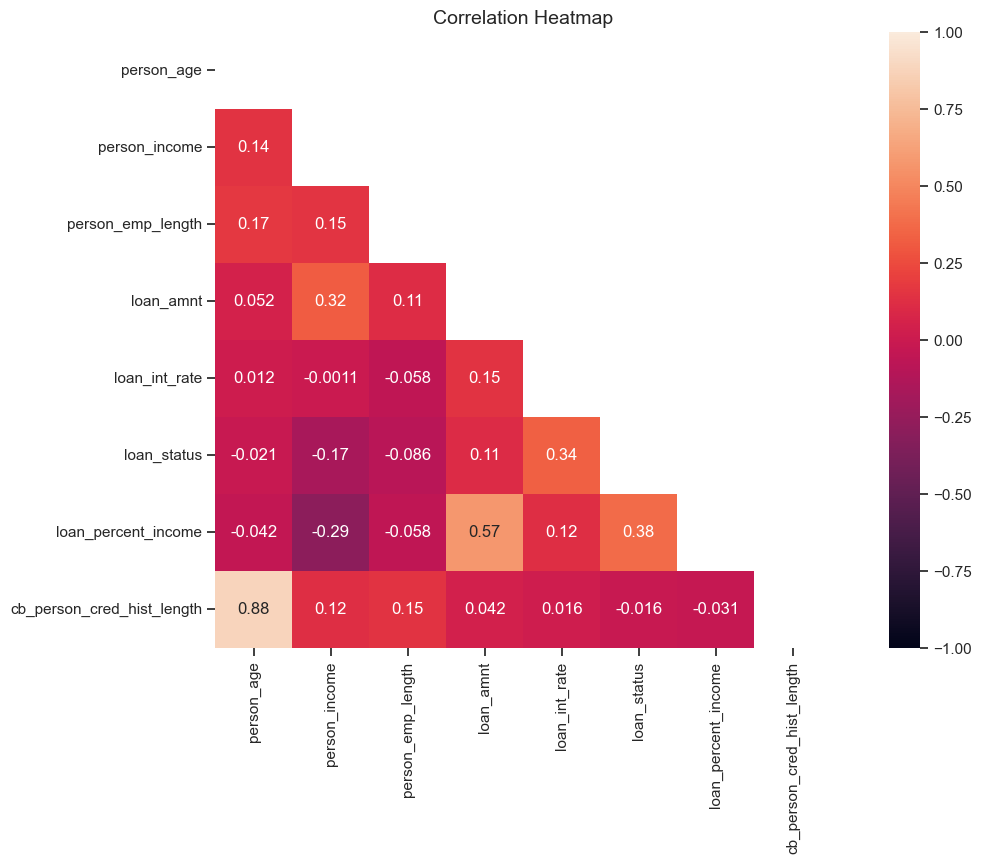

In [14]:
mask = np.triu(np.ones_like(cr_df.corr(), dtype=bool))
sns.heatmap(cr_df.corr(), vmin=-1, vmax=1, annot=True, square=True, mask=mask)
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

In [15]:
cr_df[cr_df['person_emp_length'].isnull()].sort_values(by=['person_age', 'person_income'])

person_age  person_income person_home_ownership  person_emp_length  \
15940          21           8088                  RENT                NaN   
15926          21           9600                  RENT                NaN   
1534           21          10000                  RENT                NaN   
874            21          10140                  RENT                NaN   
2167           21          12000                  RENT                NaN   
...           ...            ...                   ...                ...   
29923          50          45600              MORTGAGE                NaN   
32158          51          18408                  RENT                NaN   
32298          53          54000                  RENT                NaN   
32280          56          32400                  RENT                NaN   
32189          70          39996                  RENT                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
15940          MEDICAL          C       1200          15.23            0   
15926          MEDICAL          B       2375          10.00            1   
1534           MEDICAL          A       1450           7.51            0   
874    HOMEIMPROVEMENT          C       1000          13.43            1   
2167           MEDICAL          B       2500          11.99            1   
...                ...        ...        ...            ...          ...   
29923         PERSONAL          A       5000           7.90            0   
32158         PERSONAL          C       1000          14.65            1   
32298          MEDICAL          D      10000          14.59            1   
32280          MEDICAL          A       8575           7.51            0   
32189          MEDICAL          C       3600          15.23            0   

       loan_percent_income cb_person_default_on_file  \
15940                 0.15                         Y   
15926                 0.25                         N   
1534                  0.14                         N   
874                   0.10                         N   
2167                  0.21                         N   
...                    ...                       ...   
29923                 0.11                         N   
32158                 0.05                         Y   
32298                 0.19                         Y   
32280                 0.26                         N   
32189                 0.09                         Y   

       cb_person_cred_hist_length  
15940                           2  
15926                           3  
1534                            4  
874                             4  
2167                            4  
...                           ...  
29923                          16  
32158                          20  
32298                          27  
32280                          18  
32189                          19  

[889 rows x 12 columns]

It's reasonable to person employment length has higher correlation with person age. \
So we will impute it with median according to person age.

In [9]:
# impute person_emp_length nan with median for every age

age_nan = cr_df[cr_df['person_emp_length'].isnull()]['person_age'].unique()

for age in age_nan:
    median = cr_df.loc[cr_df['person_age'] == age, 'person_emp_length'].median()
    cr_df.loc[cr_df['person_age'] == age, 'person_emp_length'] = cr_df.loc[cr_df['person_age'] == age, 'person_emp_length'].fillna(median)  

In [8]:
cr_df['person_emp_length'].isnull().sum()

0

In [25]:
cr_df[cr_df['person_age'] == 21].sort_values(by=['person_age', 'person_income', 'loan_amnt', 'loan_int_rate'])

person_age  person_income person_home_ownership  person_emp_length  \
15960          21           4080                  RENT                0.0   
15959          21           4200                  RENT                3.0   
15953          21           6000                   OWN                1.0   
15950          21           7200                  RENT                0.0   
15944          21           8000                  RENT                1.0   
...           ...            ...                   ...                ...   
16532          21         192000              MORTGAGE                0.0   
166            21         200000              MORTGAGE                5.0   
16672          21         200000              MORTGAGE                5.0   
174            21         200000              MORTGAGE                2.0   
15883          21         249996              MORTGAGE                5.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
15960          EDUCATION          B       1400          11.86            1   
15959           PERSONAL          E       2750          16.95            1   
15953           PERSONAL          D       1600          14.61            1   
15950            VENTURE          C       2500          13.11            1   
15944  DEBTCONSOLIDATION          A       2800           7.40            1   
...                  ...        ...        ...            ...          ...   
16532          EDUCATION          A      20000           6.54            0   
166            EDUCATION          C      16000          14.65            0   
16672          EDUCATION          C      16000          14.65            0   
174    DEBTCONSOLIDATION          C      25000          13.99            0   
15883           PERSONAL          A       5000           8.59            0   

       loan_percent_income cb_person_default_on_file  \
15960                 0.34                         N   
15959                 0.65                         N   
15953                 0.27                         Y   
15950                 0.35                         N   
15944                 0.35                         N   
...                    ...                       ...   
16532                 0.10                         N   
166                   0.08                         N   
16672                 0.08                         N   
174                   0.13                         N   
15883                 0.02                         N   

       cb_person_cred_hist_length  
15960                           4  
15959                           3  
15953                           3  
15950                           3  
15944                           2  
...                           ...  
16532                           2  
166                             4  
16672                           2  
174                             2  
15883                           3  

[1213 rows x 12 columns]

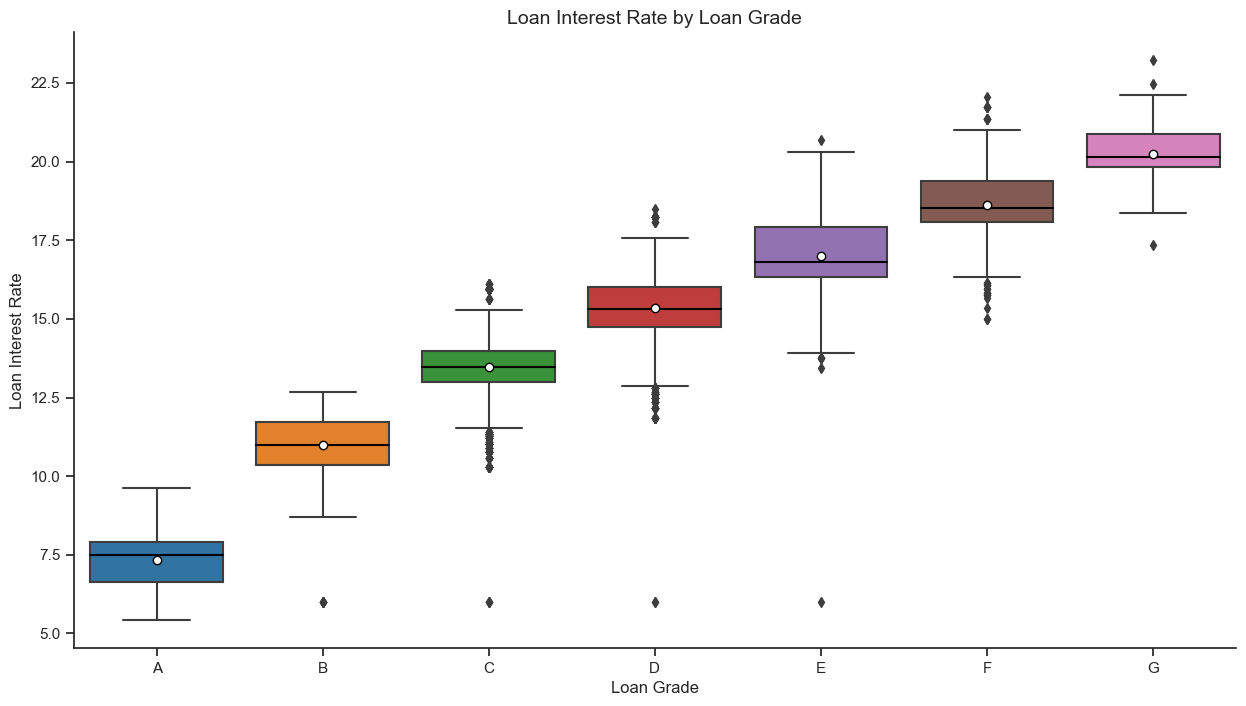

In [20]:
ax = sns.boxplot(data=cr_df.sort_values(by='loan_grade'), x='loan_grade', y='loan_int_rate', 
            showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
            medianprops={'color':'black'})
ax.set_title('Loan Interest Rate by Loan Grade', fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Interest Rate')
plt.show()

We found loan interest rate increased as loan grade letter greater. \
Therefore, we will impute `loan_int_rate` with median its `loan_grade`.

In [10]:
grade_nan = cr_df[cr_df['loan_int_rate'].isnull()]['loan_grade'].unique()

for grade in grade_nan:
    median = cr_df.loc[cr_df['loan_grade'] == grade, 'loan_int_rate'].median()
    cr_df.loc[cr_df['loan_grade'] == grade, 'loan_int_rate'] = cr_df.loc[cr_df['loan_grade'] == grade, 'loan_int_rate'].fillna(median)
    

In [29]:
cr_df['loan_int_rate'].isnull().sum()

0

In [8]:
cr_df.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

# Exploratory Data Analysis

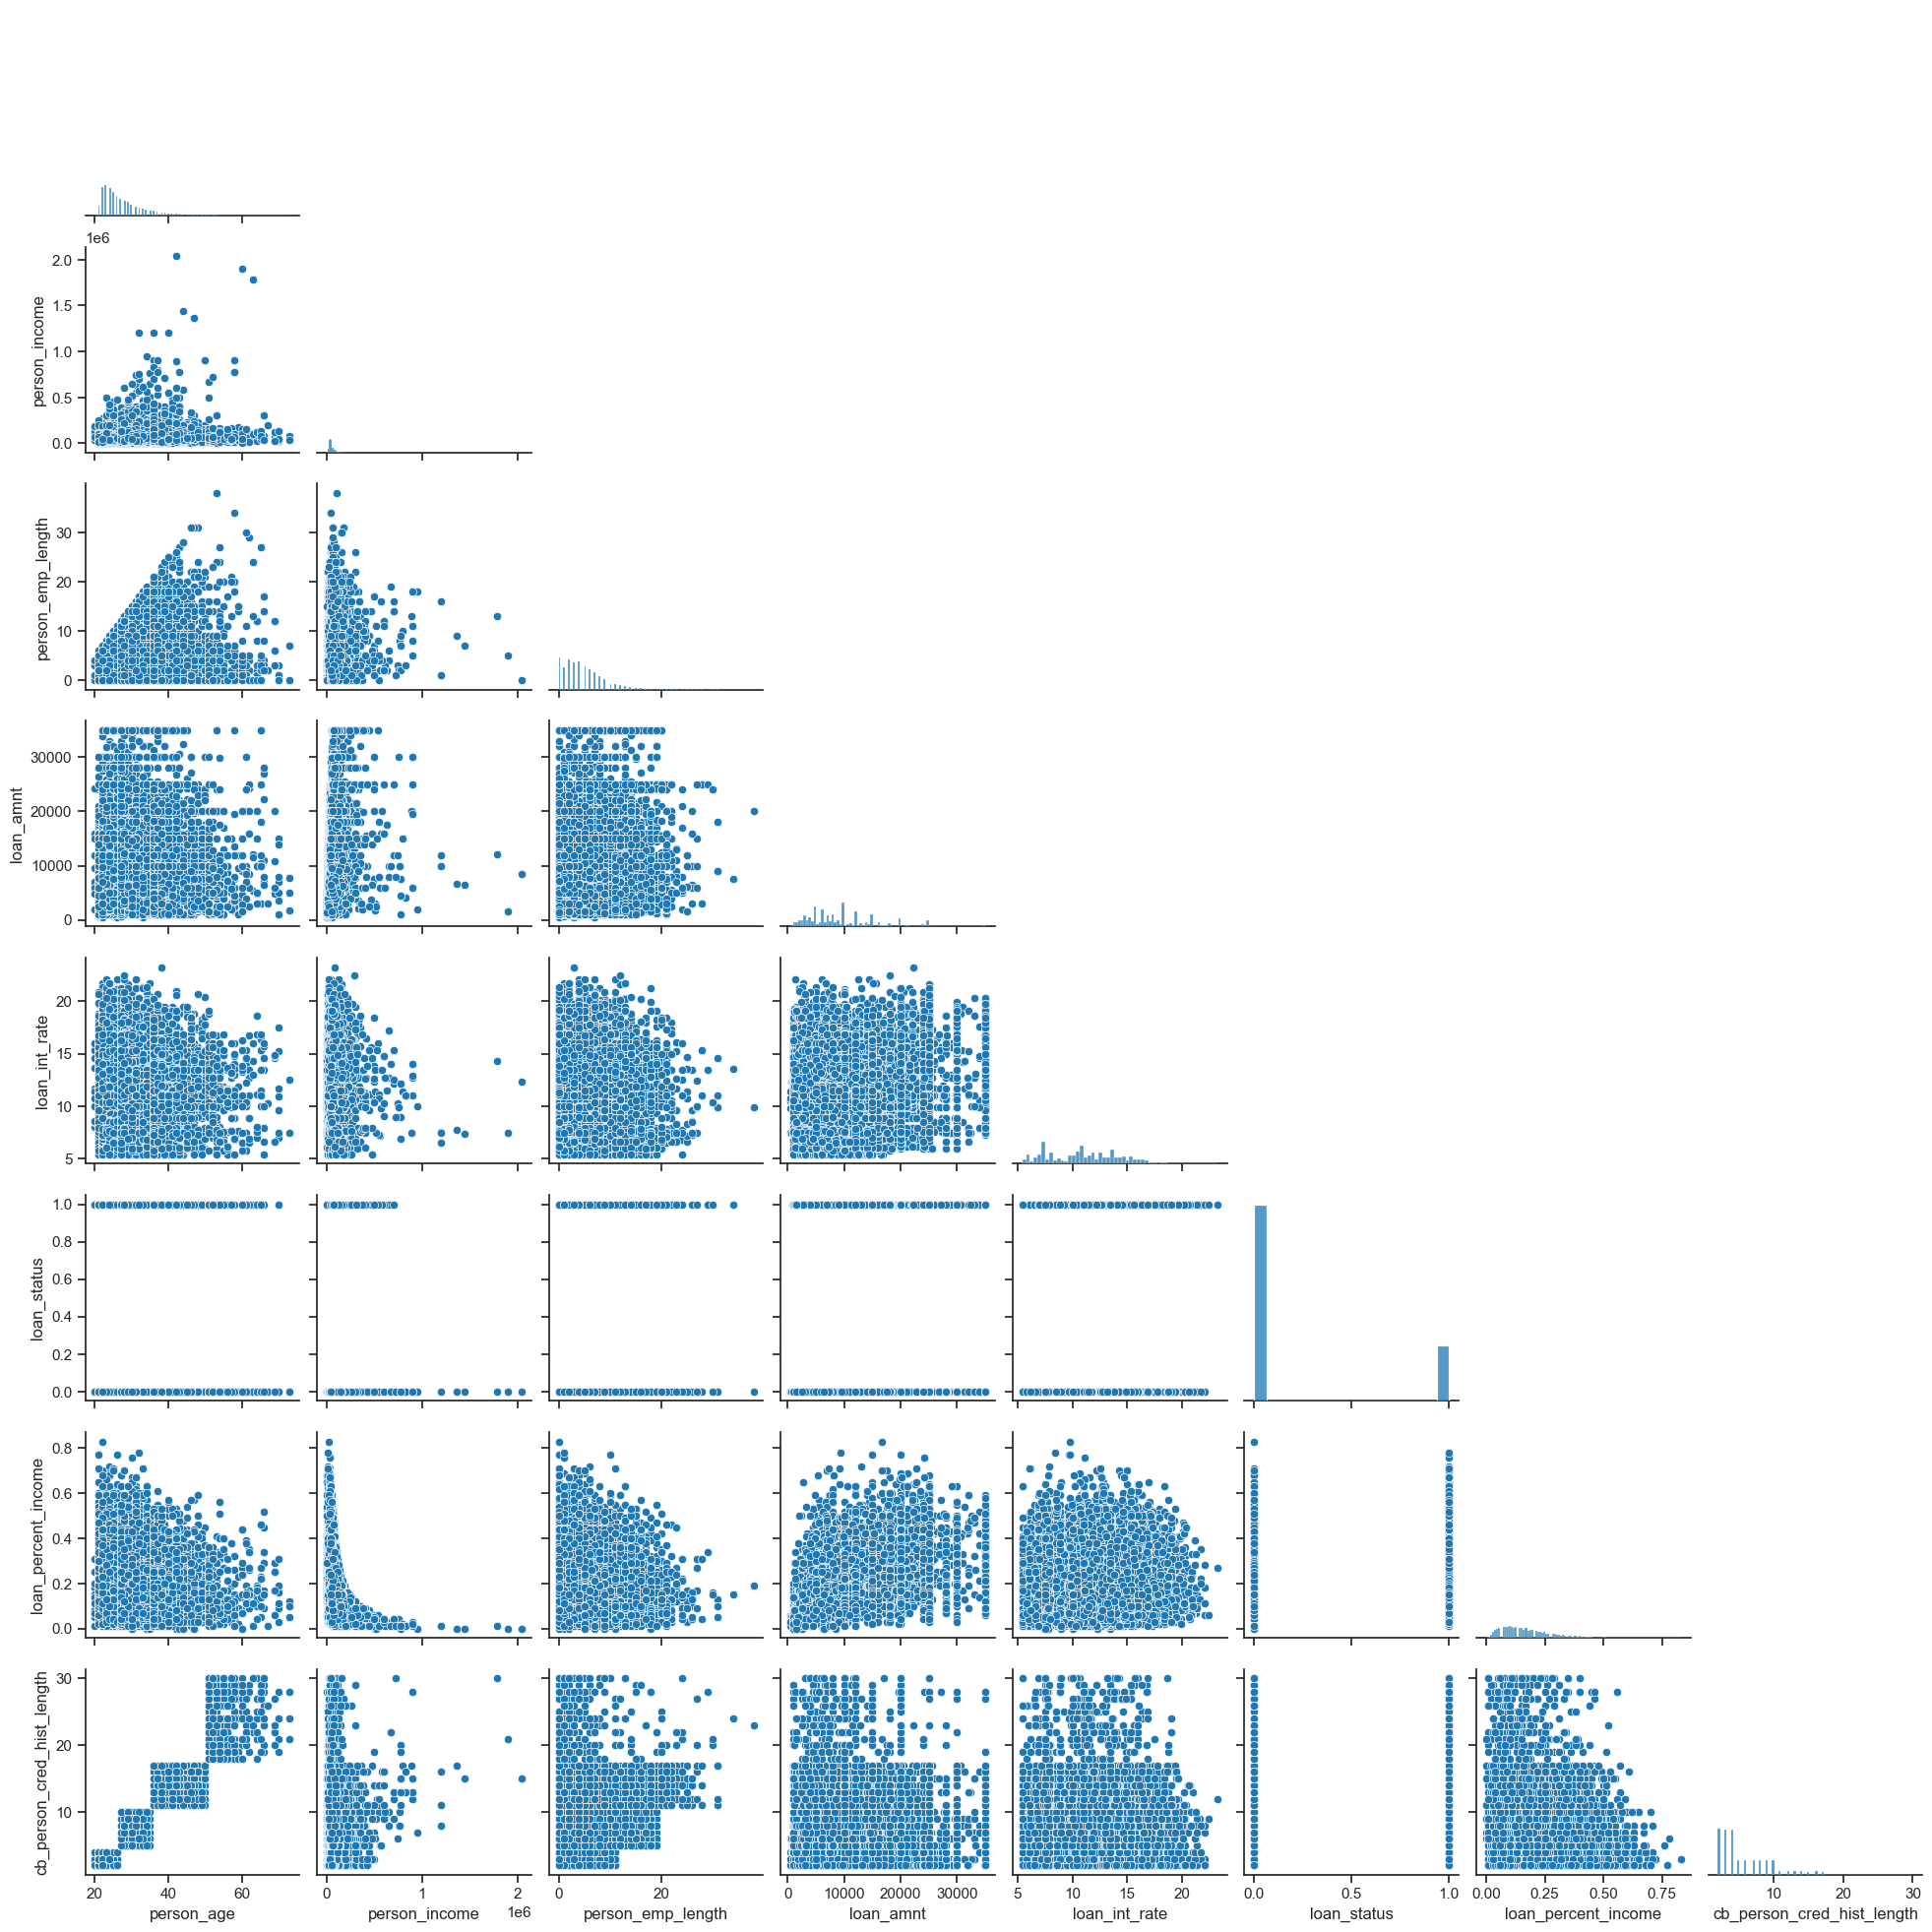

In [31]:
sns.pairplot(cr_df, corner=True)

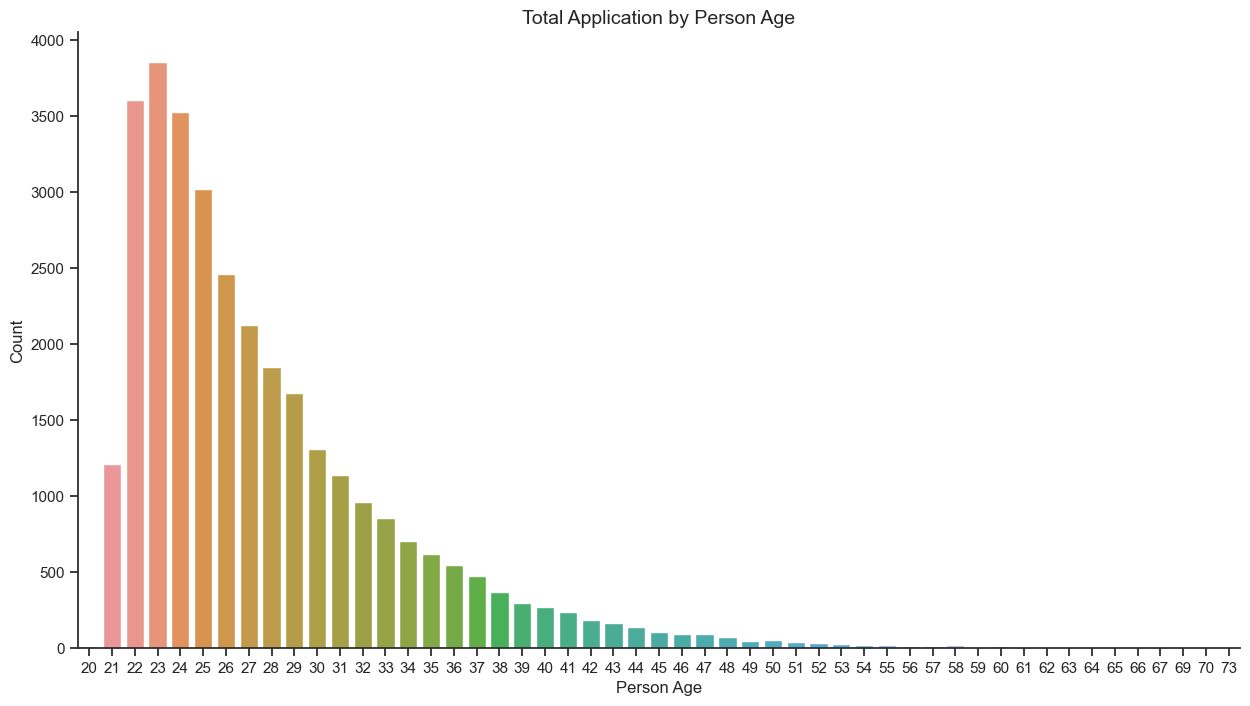

In [32]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df, x='person_age')
ax.set_title("Total Application by Person Age", fontsize=14)
ax.set_xlabel('Person Age')
ax.set_ylabel('Count')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

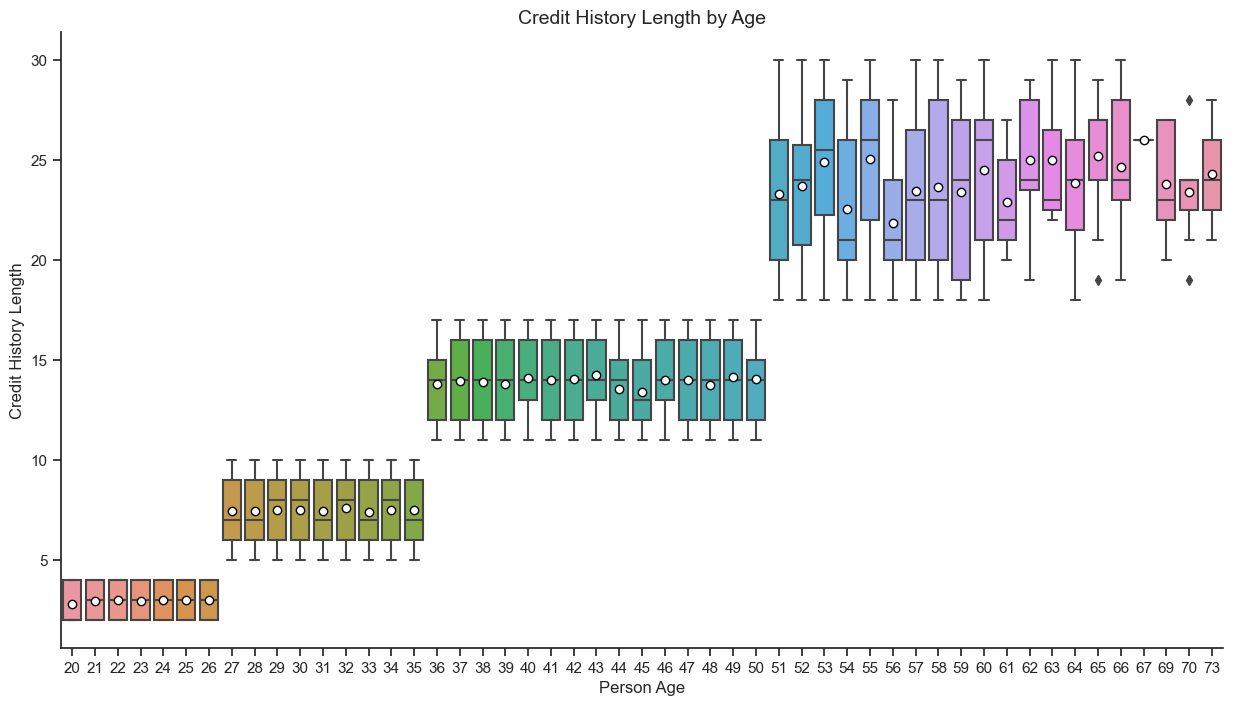

In [67]:
ax = sns.boxplot(data=cr_df, x='person_age', y='cb_person_cred_hist_length', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title('Credit History Length by Age', fontsize=14)
ax.set_xlabel('Person Age')
ax.set_ylabel('Credit History Length')

plt.show()

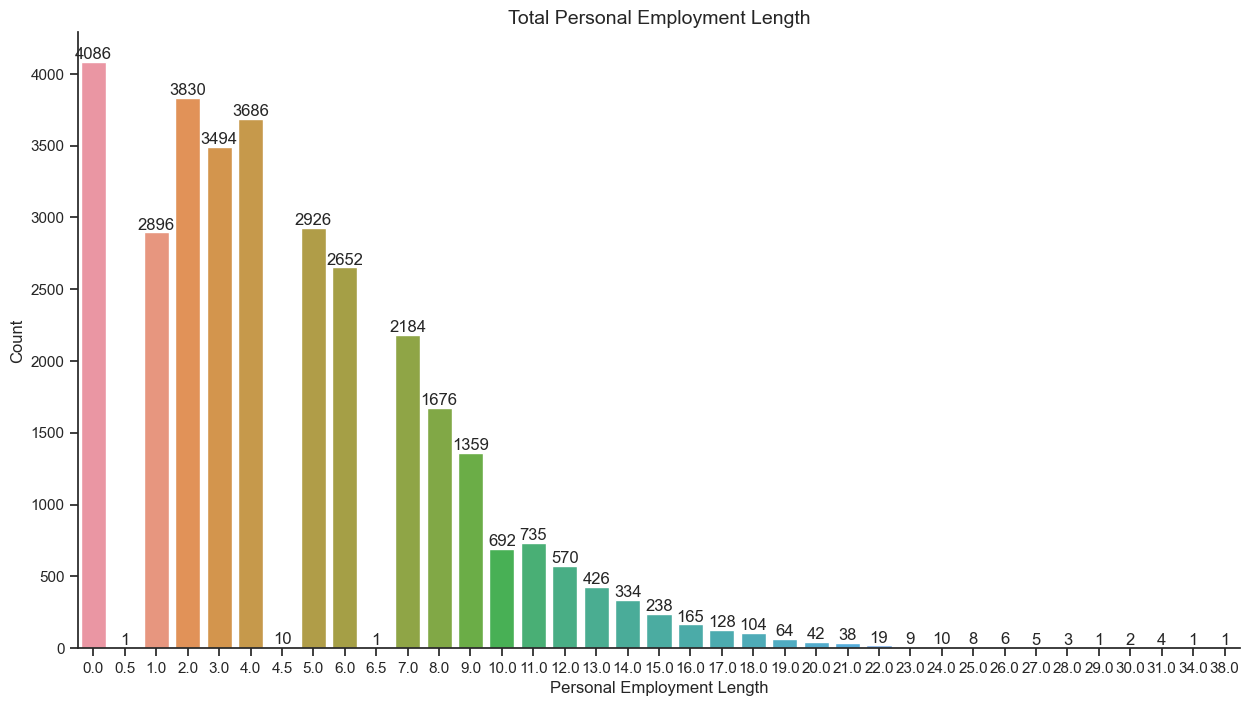

In [60]:
plt.figure(figsize=(15,8))
ax = sns.countplot(data=cr_df, x='person_emp_length')
ax.set_title('Total Personal Employment Length', fontsize=14)
ax.set_xlabel('Personal Employment Length')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

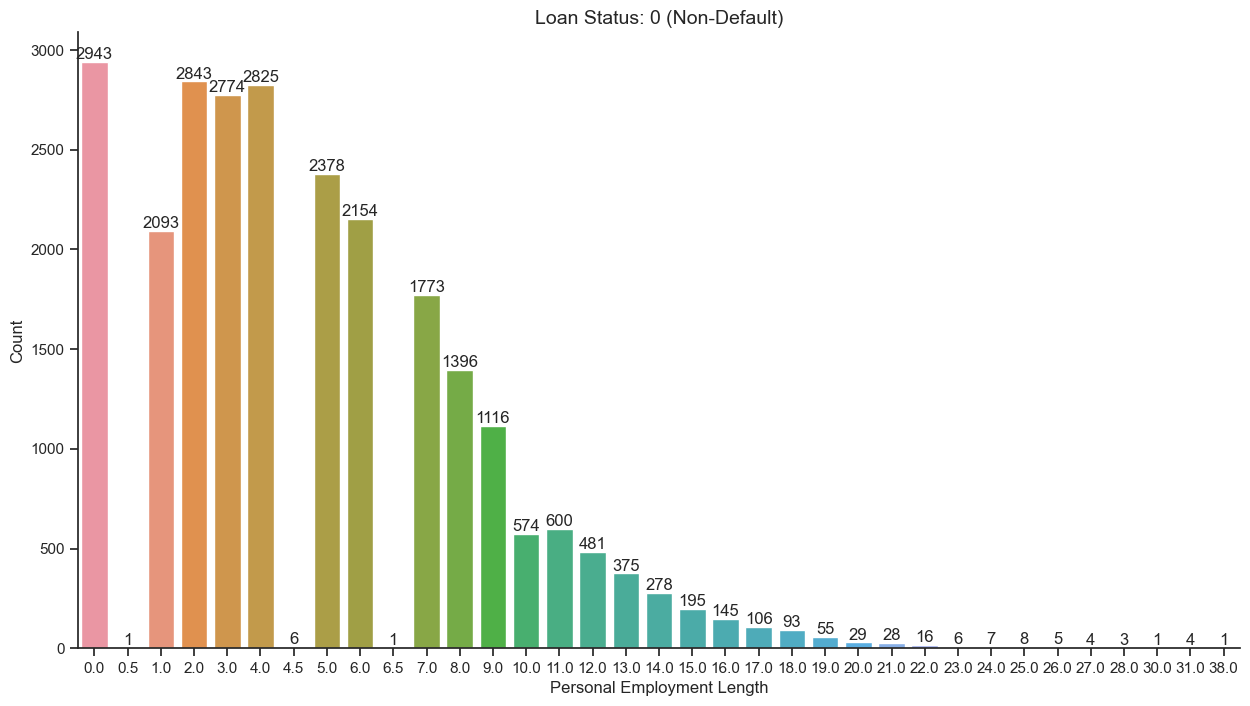

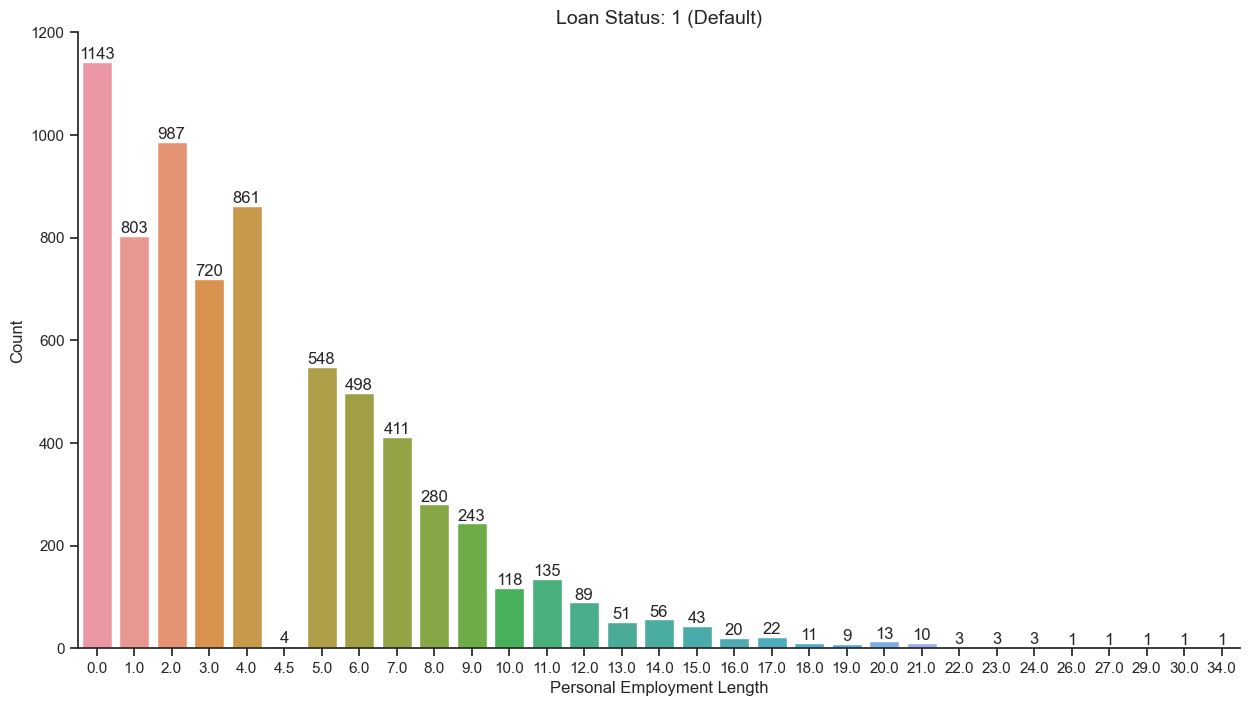

In [61]:
plt.figure(figsize=(15,8))

ax1 = sns.countplot(data=cr_df[cr_df['loan_status'] == 0], x='person_emp_length')
ax1.set_title('Loan Status: 0 (Non-Default)', fontsize=14)
ax1.set_xlabel('Personal Employment Length')
ax1.set_ylabel('Count')
ax1.bar_label(ax1.containers[0], label_type='edge')

plt.figure(figsize=(15,8))

ax2 = sns.countplot(data=cr_df[cr_df['loan_status'] == 1], x='person_emp_length')
ax2.set_title('Loan Status: 1 (Default)', fontsize=14)
ax2.set_xlabel('Personal Employment Length')
ax2.set_ylabel('Count')
ax2.bar_label(ax2.containers[0], label_type='edge')
plt.show()


In [62]:
# percentage loan status overall person employment length

display(pd.crosstab(cr_df['loan_status'], cr_df['person_emp_length'], normalize=True).round(4)*100)

# percentage loan status every person employment length

display(pd.crosstab(cr_df['loan_status'], cr_df['person_emp_length'], normalize='columns').round(4)*100)

person_emp_length  0.0   0.5   1.0   2.0   3.0   4.0   4.5   5.0   6.0   6.5   \
loan_status                                                                     
0                  9.08   0.0  6.46  8.77  8.56  8.72  0.02  7.34  6.65   0.0   
1                  3.53   0.0  2.48  3.05  2.22  2.66  0.01  1.69  1.54   0.0   

person_emp_length  ...  24.0  25.0  26.0  27.0  28.0  29.0  30.0  31.0  34.0  \
loan_status        ...                                                         
0                  ...  0.02  0.02  0.02  0.01  0.01   0.0   0.0  0.01   0.0   
1                  ...  0.01  0.00  0.00  0.00  0.00   0.0   0.0  0.00   0.0   

person_emp_length  38.0  
loan_status              
0                   0.0  
1                   0.0  

[2 rows x 37 columns]

person_emp_length   0.0    0.5    1.0    2.0    3.0    4.0   4.5    5.0   \
loan_status                                                                
0                  72.03  100.0  72.27  74.23  79.39  76.64  60.0  81.27   
1                  27.97    0.0  27.73  25.77  20.61  23.36  40.0  18.73   

person_emp_length   6.0    6.5   ...  24.0   25.0   26.0  27.0   28.0   29.0  \
loan_status                      ...                                           
0                  81.22  100.0  ...  70.0  100.0  83.33  80.0  100.0    0.0   
1                  18.78    0.0  ...  30.0    0.0  16.67  20.0    0.0  100.0   

person_emp_length  30.0   31.0   34.0   38.0  
loan_status                                   
0                  50.0  100.0    0.0  100.0  
1                  50.0    0.0  100.0    0.0  

[2 rows x 37 columns]

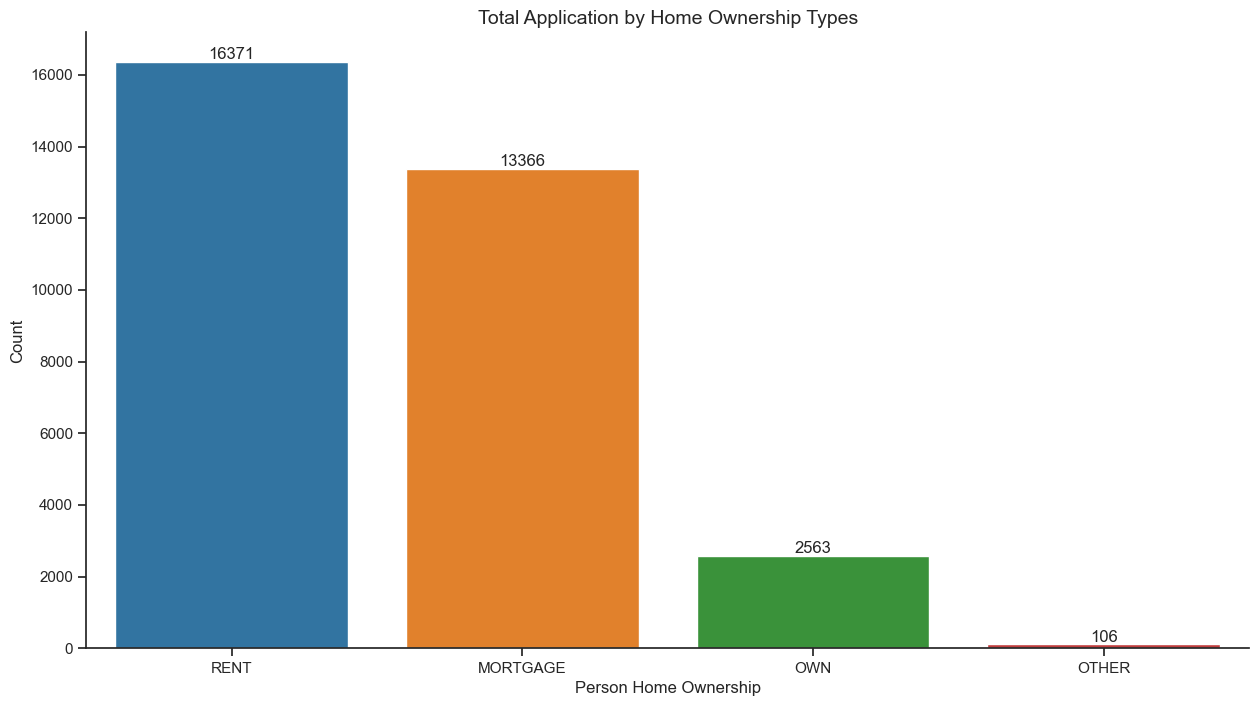

In [37]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df, x='person_home_ownership', order=cr_df['person_home_ownership'].value_counts().index)
ax.set_title("Total Application by Home Ownership Types", fontsize=14)
ax.set_xlabel('Person Home Ownership')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

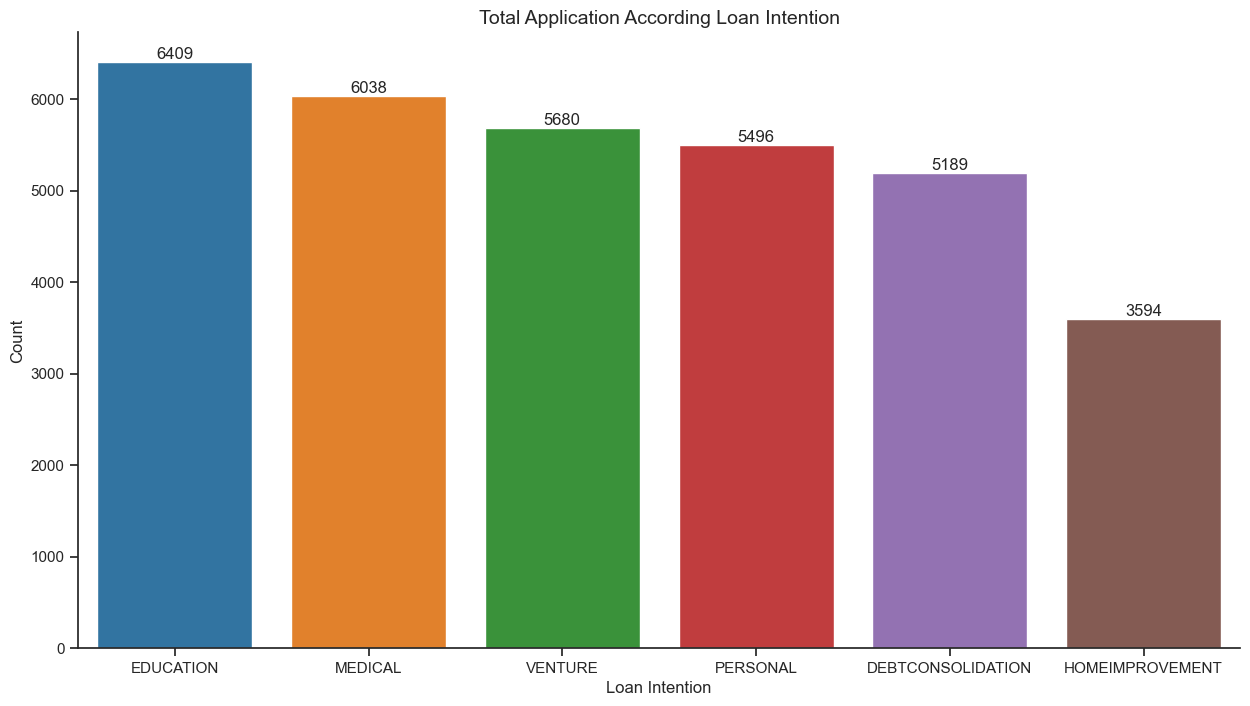

In [38]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df, x='loan_intent', order=cr_df['loan_intent'].value_counts().index)
ax.set_title("Total Application According Loan Intention", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Count')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [40]:
cr_df[cr_df['person_age'] == 63]

person_age  person_income person_home_ownership  person_emp_length  \
32223          63          37000                  RENT               24.0   
32324          63        1782000                  RENT               13.0   
32340          63         106000              MORTGAGE                0.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
32223  DEBTCONSOLIDATION          C       5450          15.96            1   
32324          EDUCATION          C      12025          14.27            0   
32340           PERSONAL          C      11500          12.98            0   

       loan_percent_income cb_person_default_on_file  \
32223                 0.15                         N   
32324                 0.01                         N   
32340                 0.11                         N   

       cb_person_cred_hist_length  
32223                          22  
32324                          30  
32340                          23

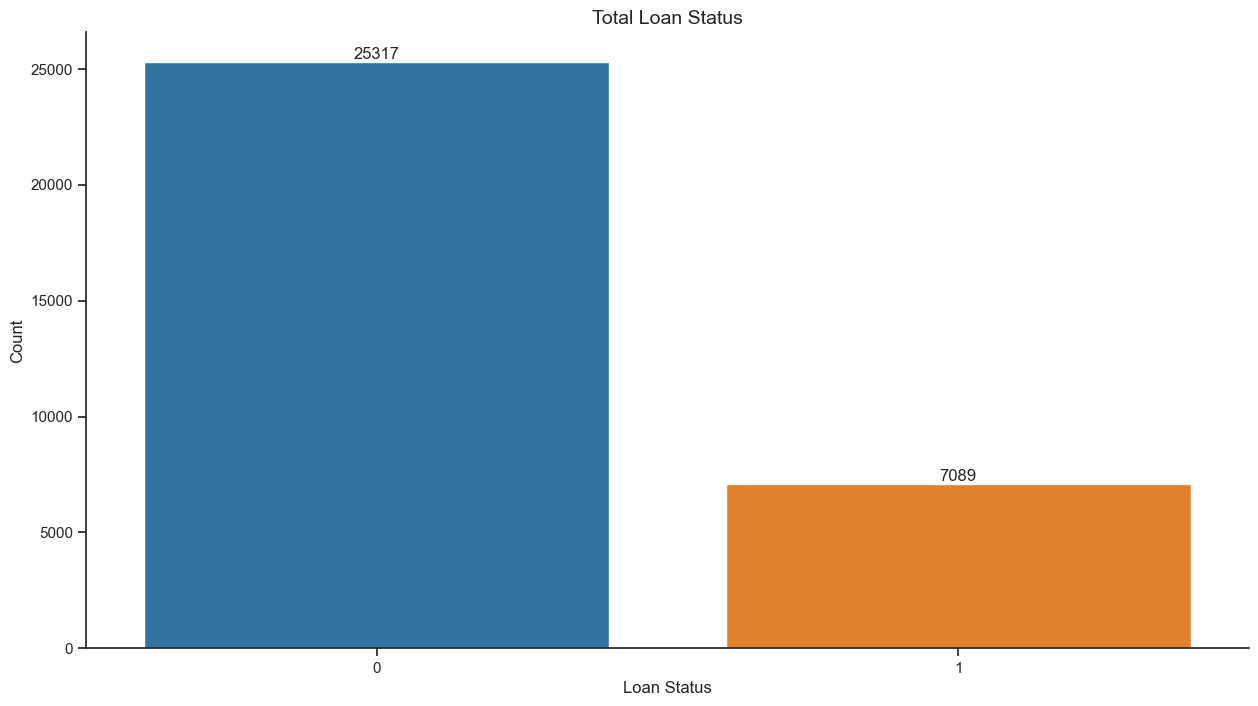

In [33]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df, x='loan_status')
ax.set_title("Total Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

In [36]:
print(f'Percentage Non-Default Status: {(cr_df["loan_status"].value_counts()[0])/(len(cr_df))*100}%')
print(f'Percentage Default Status: {(cr_df["loan_status"].value_counts()[1])/(len(cr_df))*100}%')

Percentage Non-Default Status: 78.1244214034438%
Percentage Default Status: 21.875578596556196%


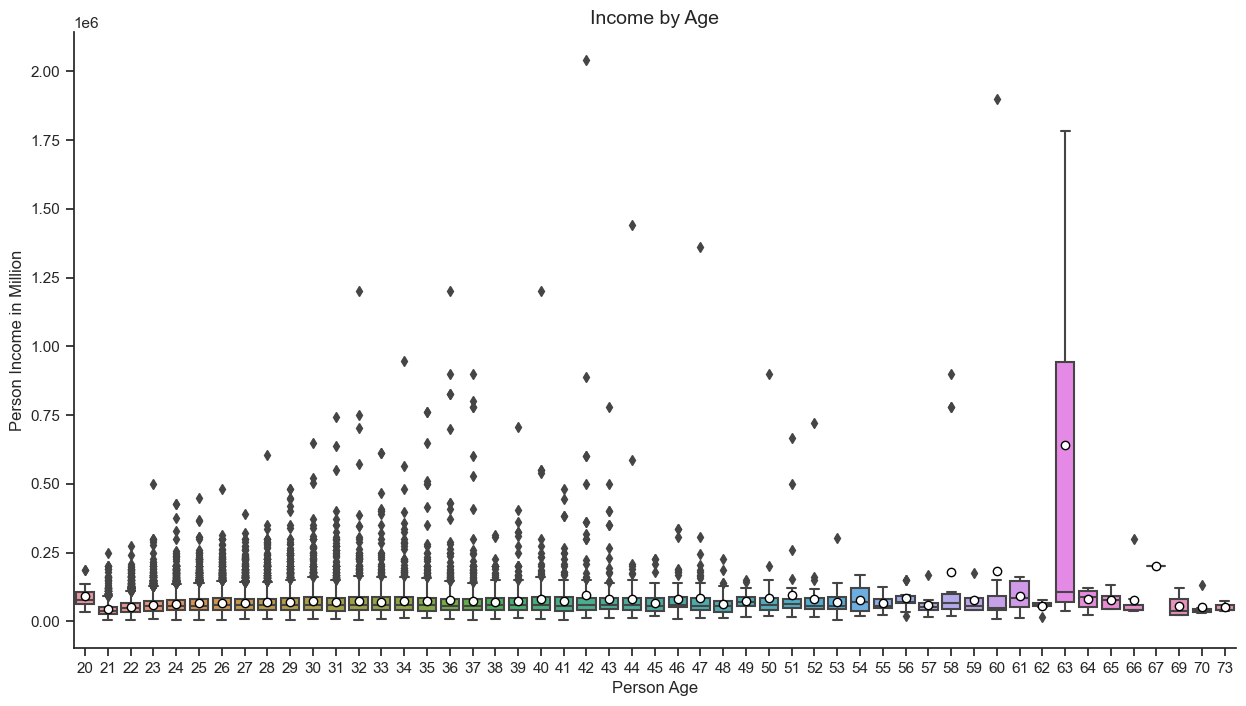

In [39]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df, x='person_age', y='person_income', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Income by Age", fontsize=14)
ax.set_xlabel('Person Age')
ax.set_ylabel('Person Income in Million')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

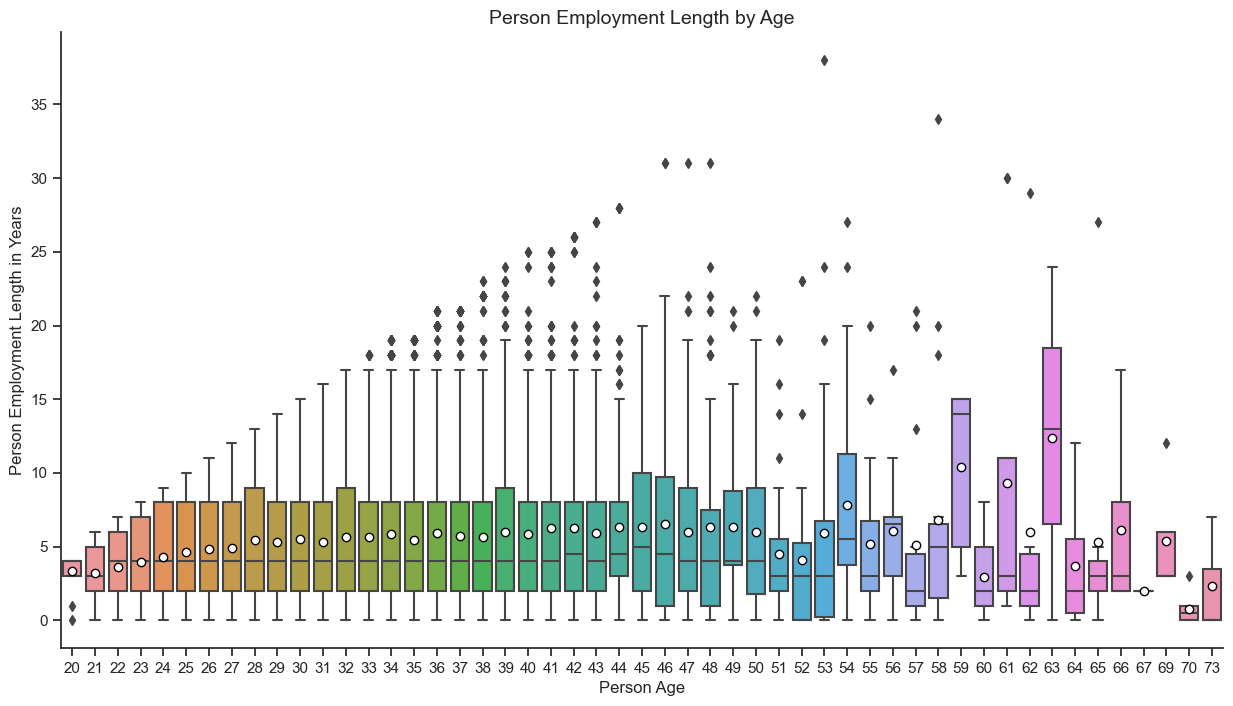

In [41]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df, x='person_age', y='person_emp_length', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Person Employment Length by Age", fontsize=14)
ax.set_xlabel('Person Age')
ax.set_ylabel('Person Employment Length in Years')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

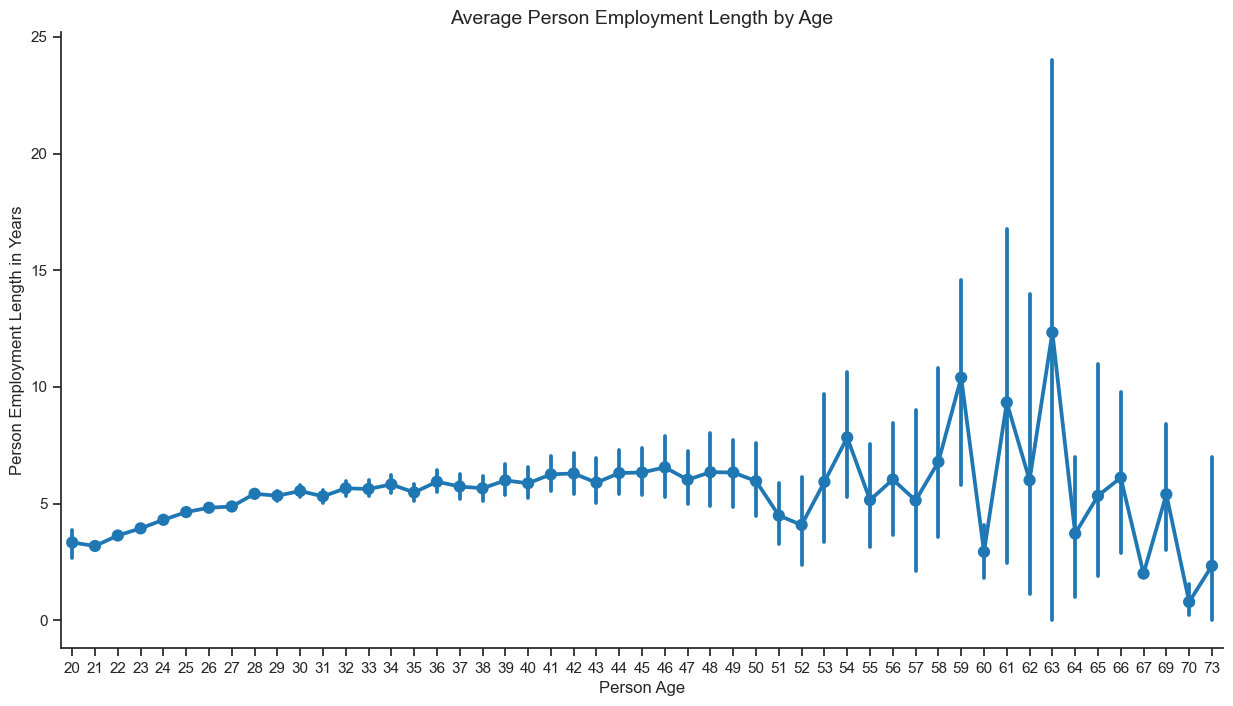

In [13]:
ax = sns.pointplot(data=cr_df, x="person_age", y="person_emp_length")
ax.set_title('Average Person Employment Length by Age', fontsize=14)
ax.set_xlabel('Person Age')
ax.set_ylabel('Person Employment Length in Years')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

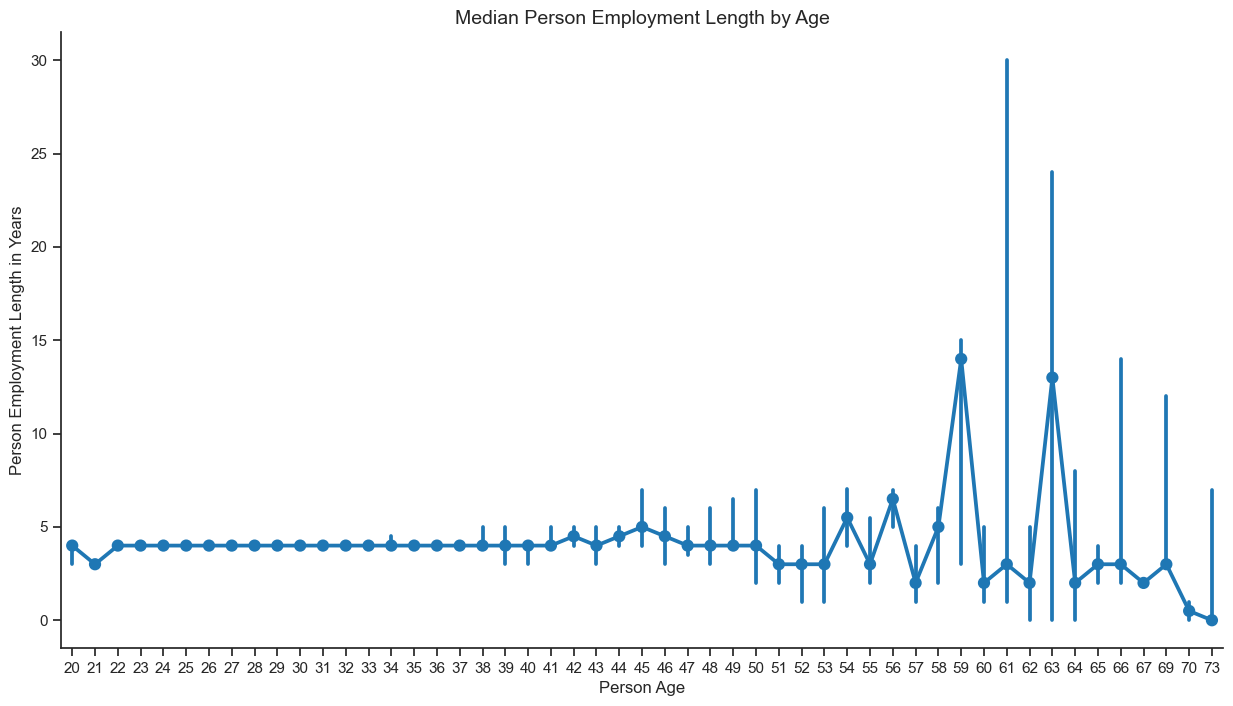

In [14]:
ax = sns.pointplot(data=cr_df, x="person_age", y="person_emp_length", estimator='median')
ax.set_title('Median Person Employment Length by Age', fontsize=14)
ax.set_xlabel('Person Age')
ax.set_ylabel('Person Employment Length in Years')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

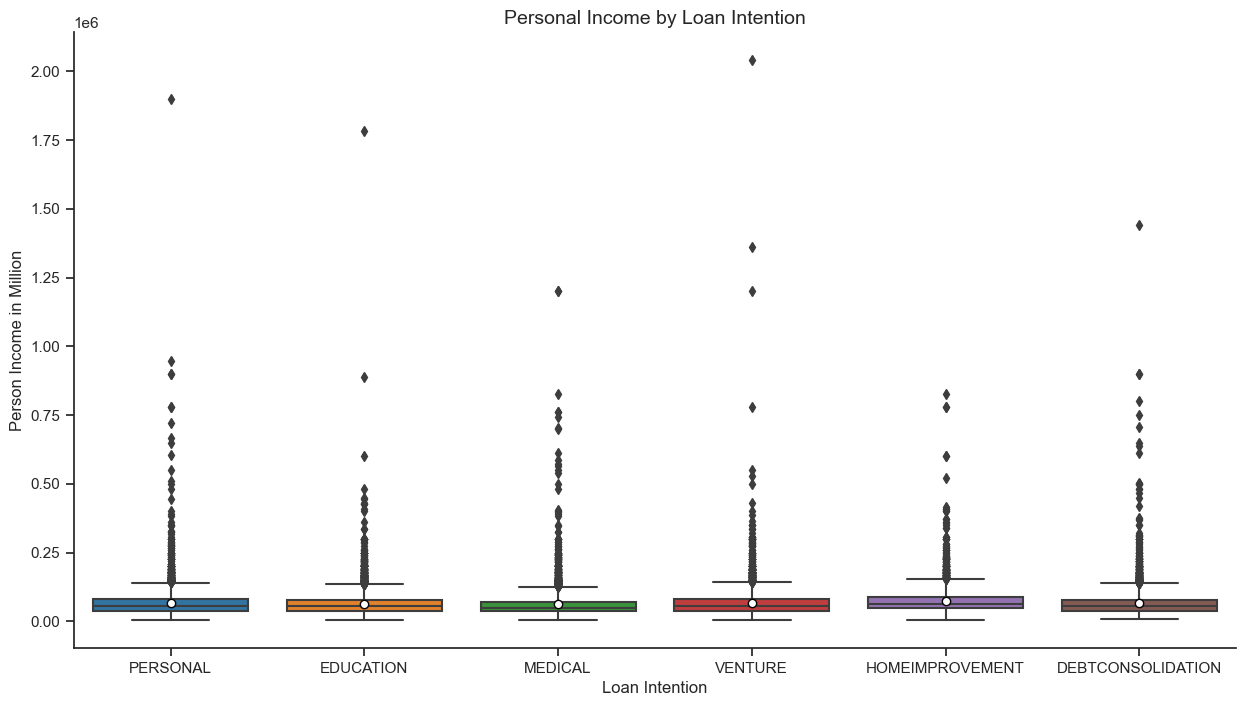

In [42]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df, x='loan_intent', y='person_income', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Personal Income by Loan Intention", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Person Income in Million')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

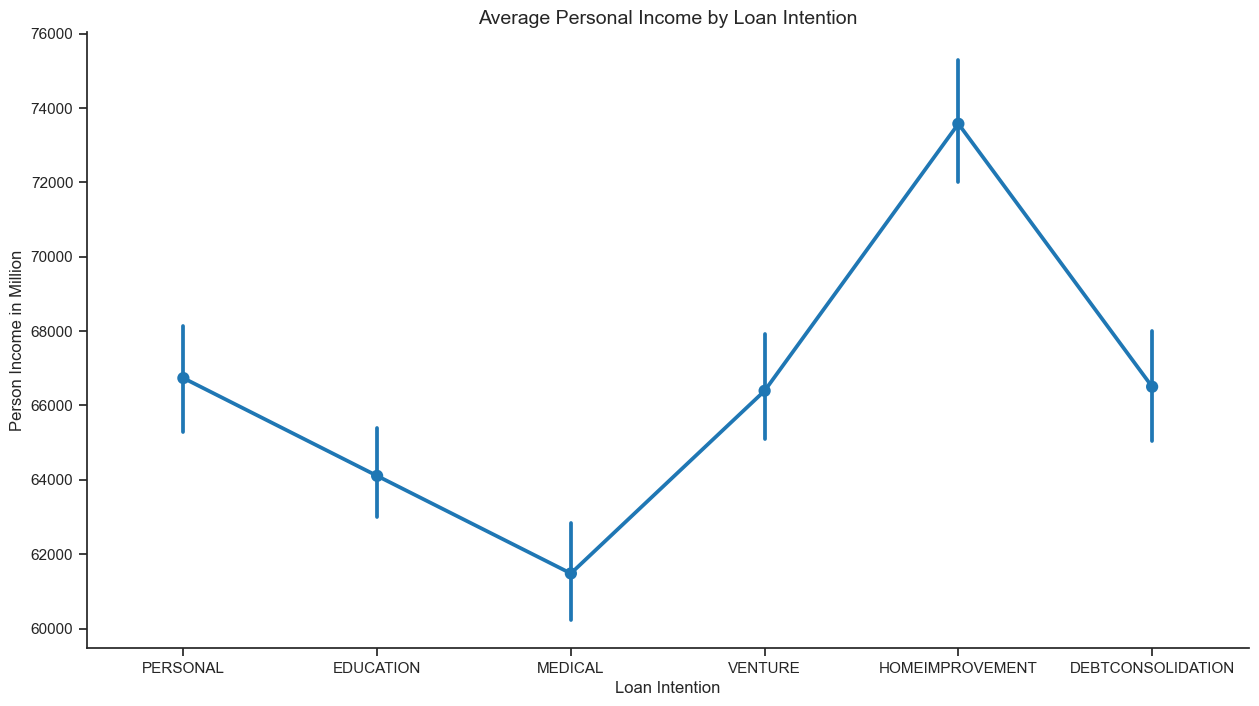

In [16]:
ax = sns.pointplot(data=cr_df, x="loan_intent", y="person_income")
ax.set_title("Average Personal Income by Loan Intention", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Person Income in Million')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

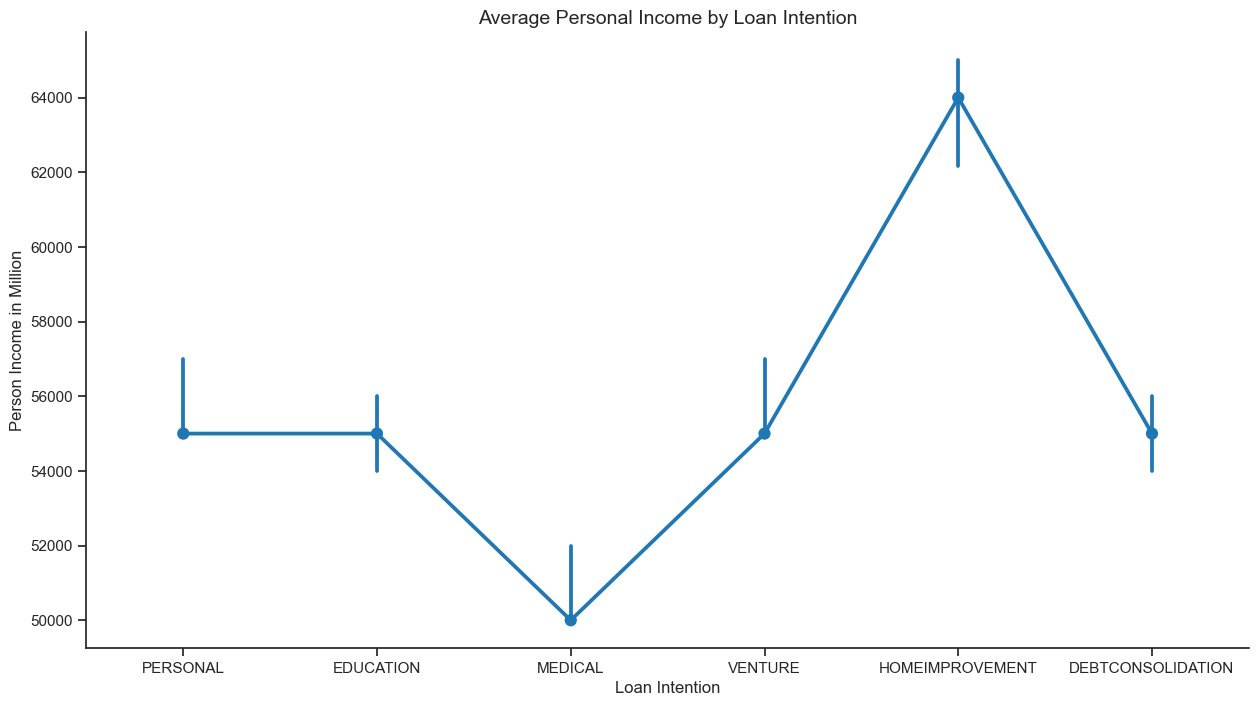

In [17]:
ax = sns.pointplot(data=cr_df, x="loan_intent", y="person_income", estimator='median')
ax.set_title("Average Personal Income by Loan Intention", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Person Income in Million')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

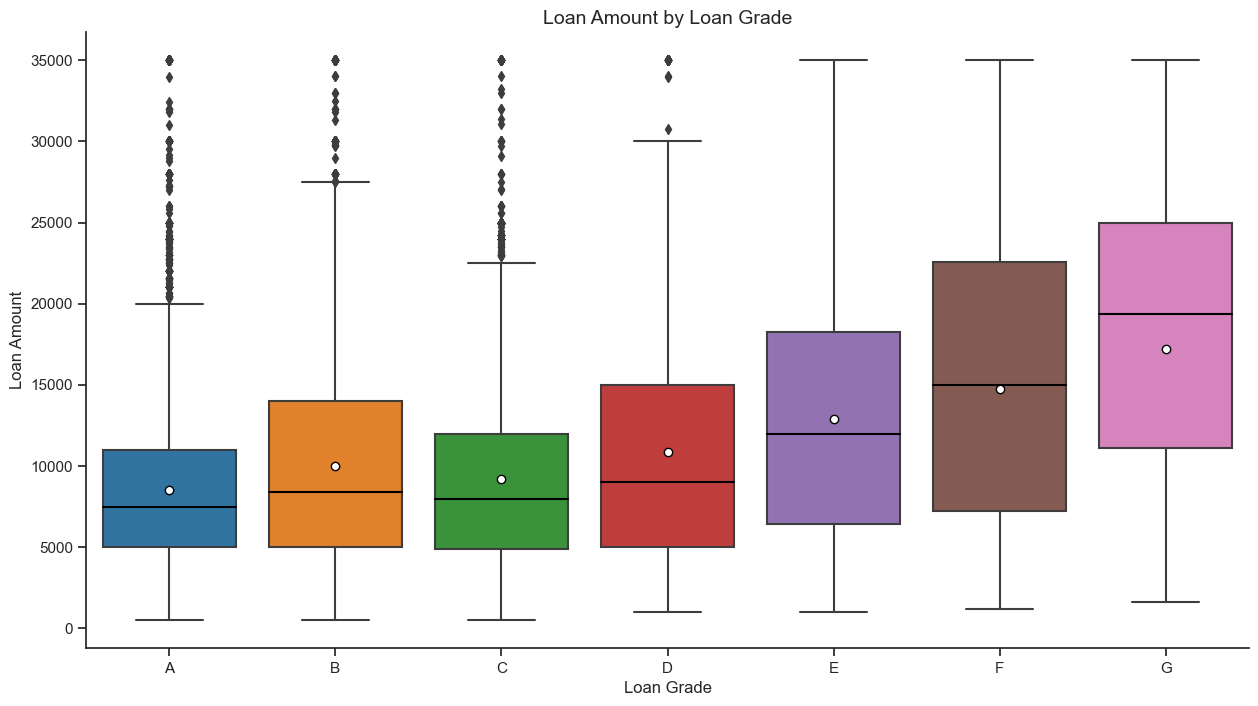

In [19]:
ax = sns.boxplot(data=cr_df.sort_values(by='loan_grade'), x='loan_grade', y='loan_amnt', 
            showmeans=True, meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"},
            medianprops={'color':'black'})
ax.set_title('Loan Amount by Loan Grade', fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Amount')
plt.show()

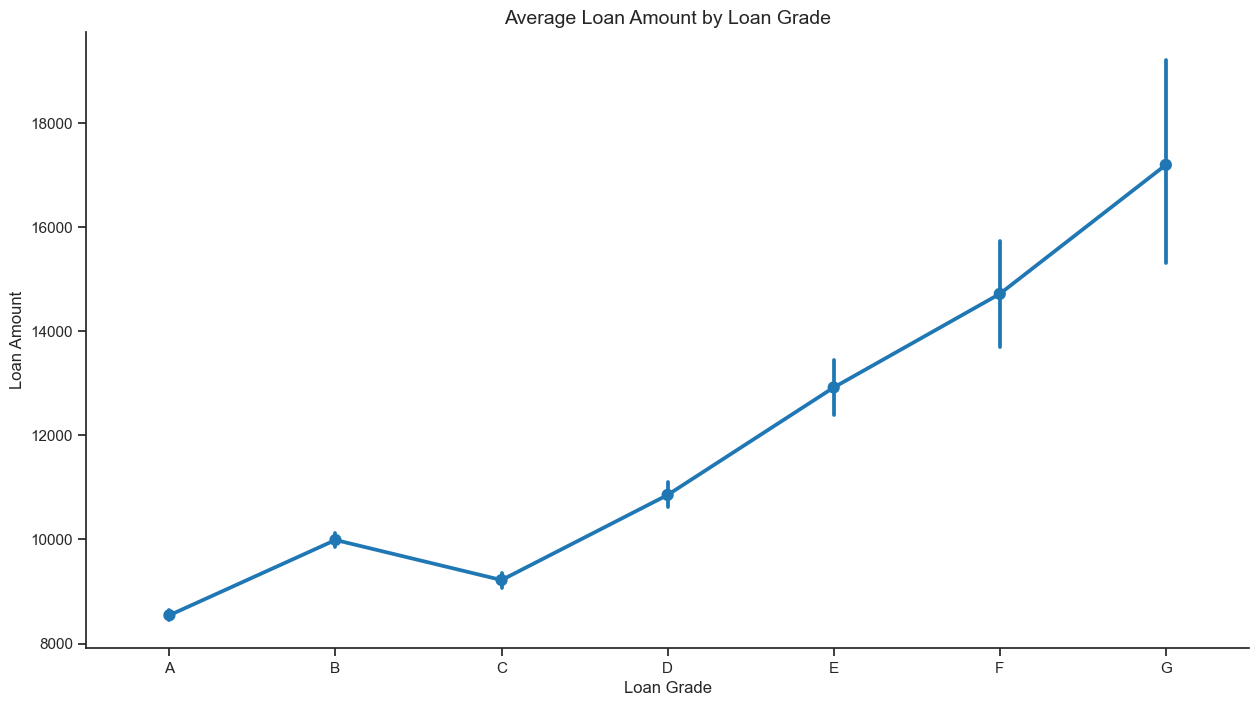

In [19]:
ax = sns.pointplot(data=cr_df.sort_values(by='loan_grade'), x="loan_grade", y="loan_amnt")
ax.set_title("Average Loan Amount by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

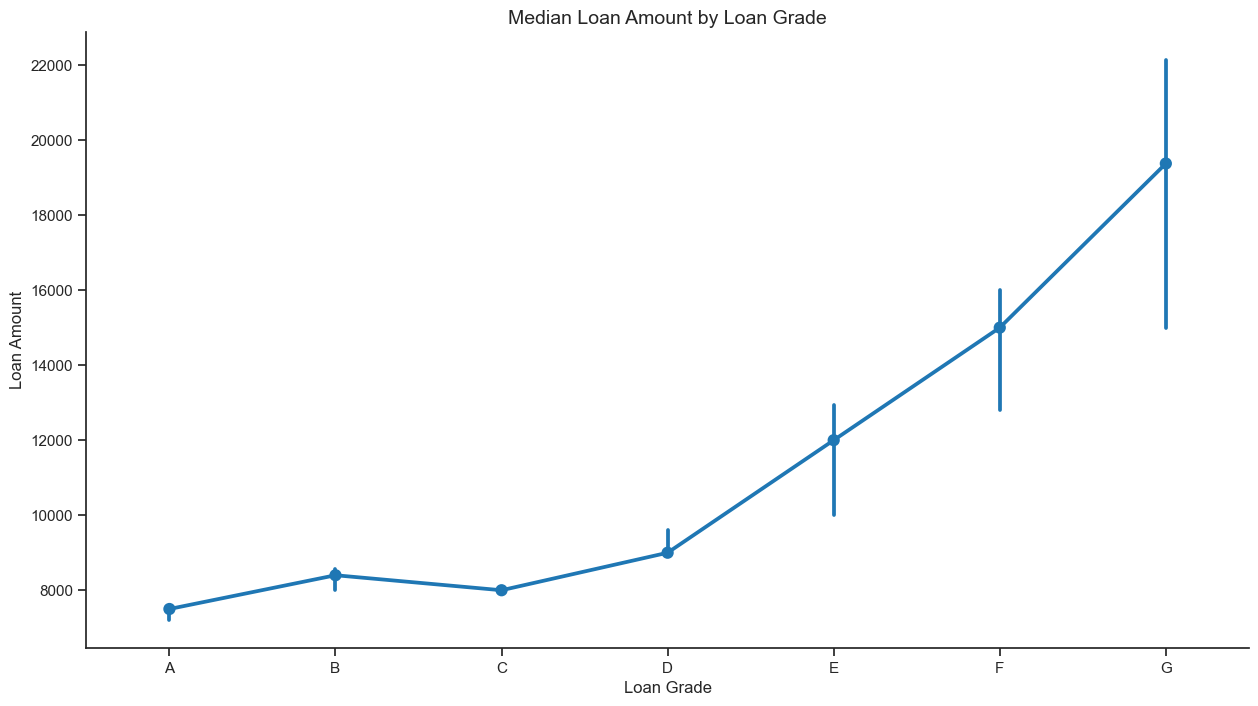

In [20]:
ax = sns.pointplot(data=cr_df.sort_values(by='loan_grade'), x="loan_grade", y="loan_amnt", estimator='median')
ax.set_title("Median Loan Amount by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

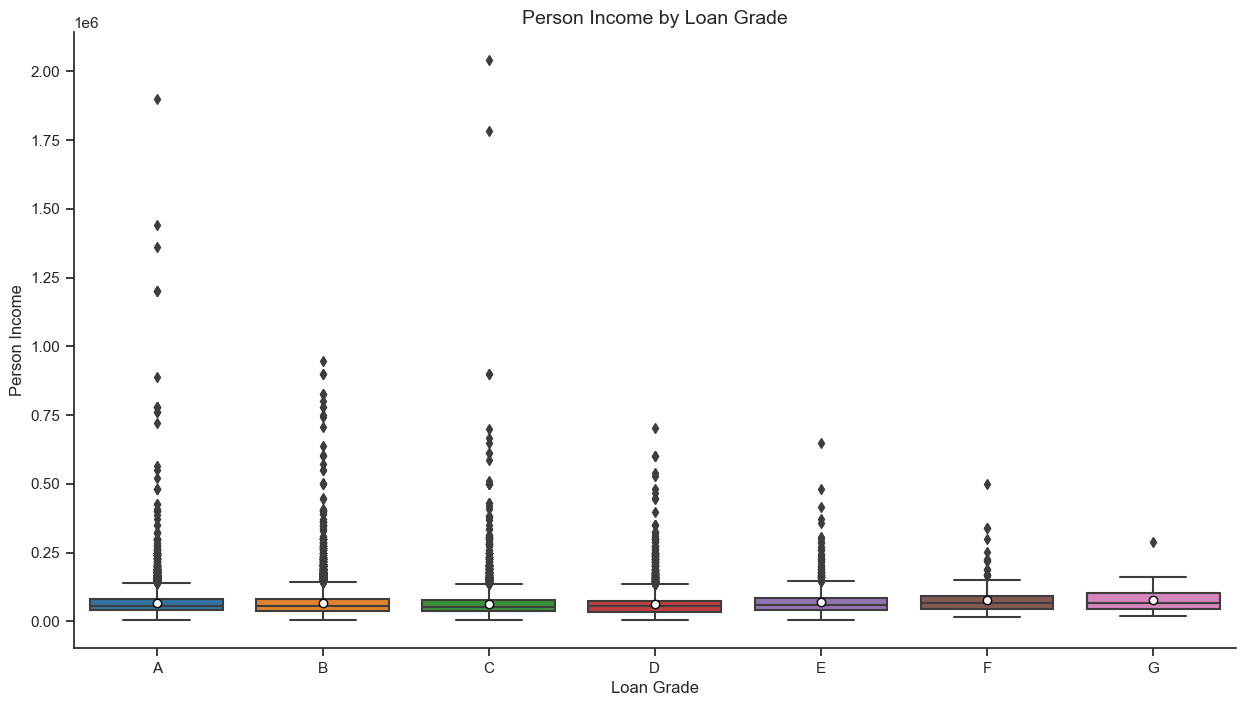

In [32]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df.sort_values(by='loan_grade'), x='loan_grade', y='person_income', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Person Income by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Person Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

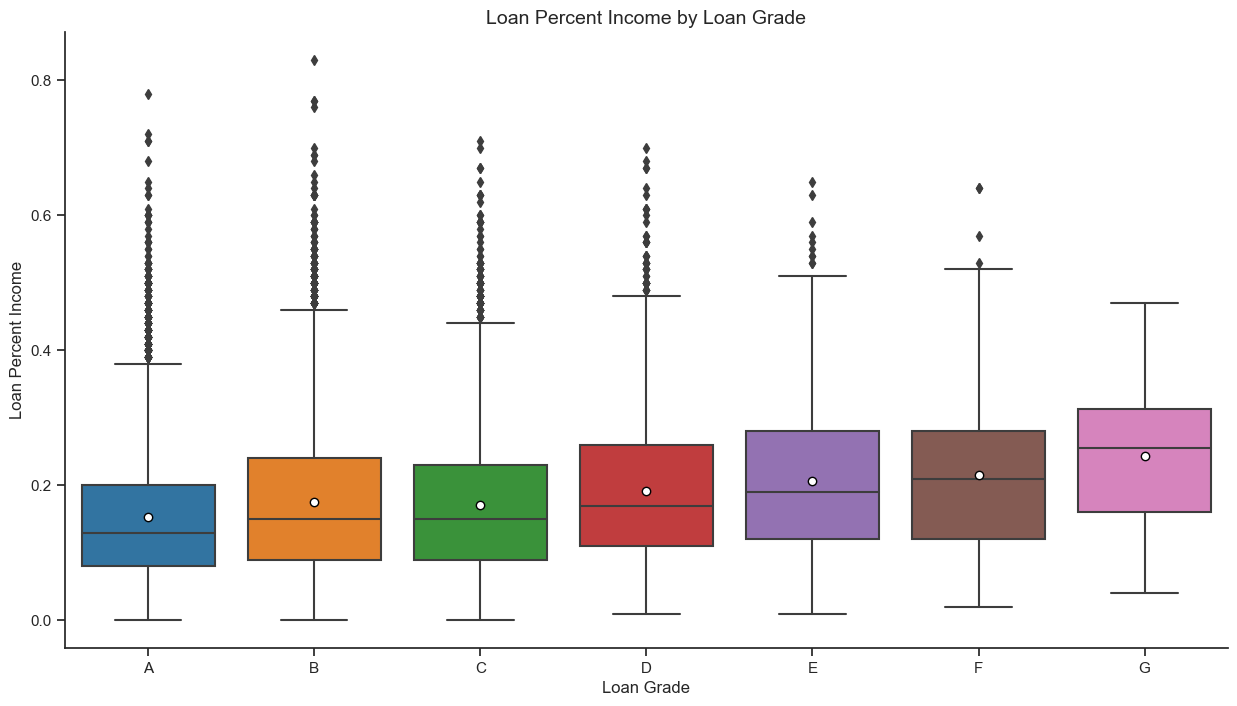

In [47]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df.sort_values(by='loan_grade'), x='loan_grade', y='loan_percent_income', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Loan Percent Income by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

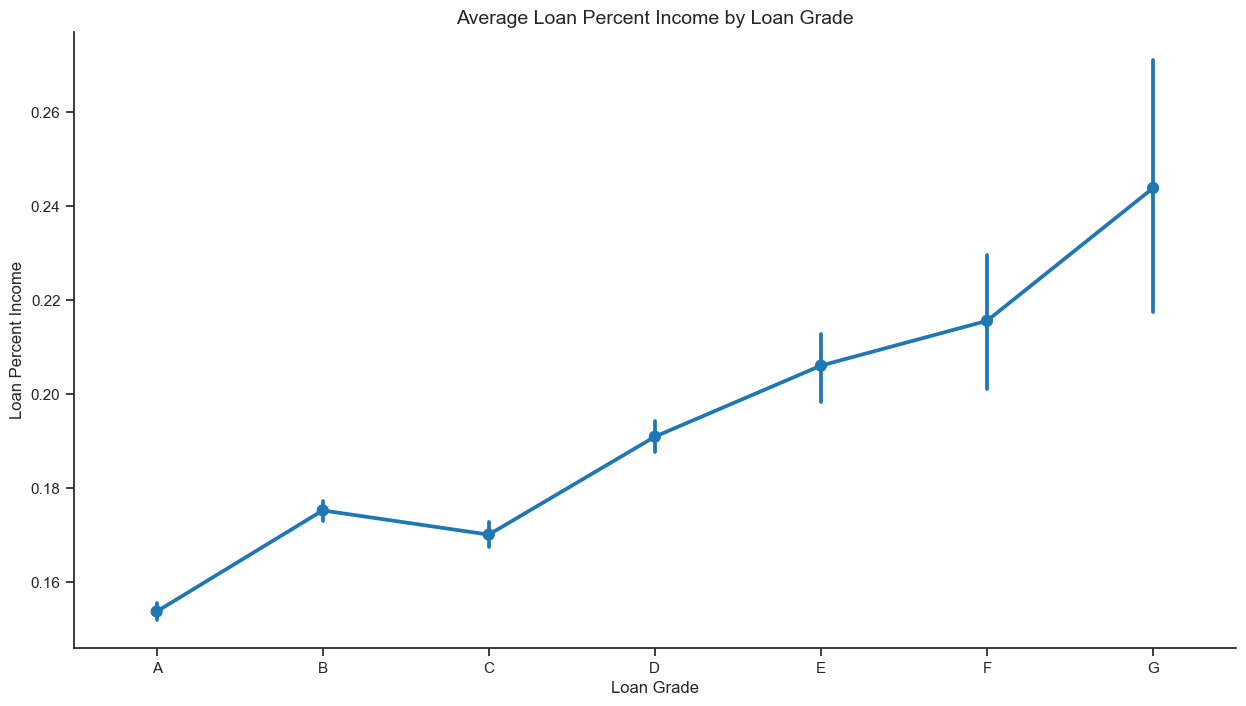

In [34]:
ax = sns.pointplot(data=cr_df.sort_values(by='loan_grade'), x="loan_grade", y="loan_percent_income")
ax.set_title("Average Loan Percent Income by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

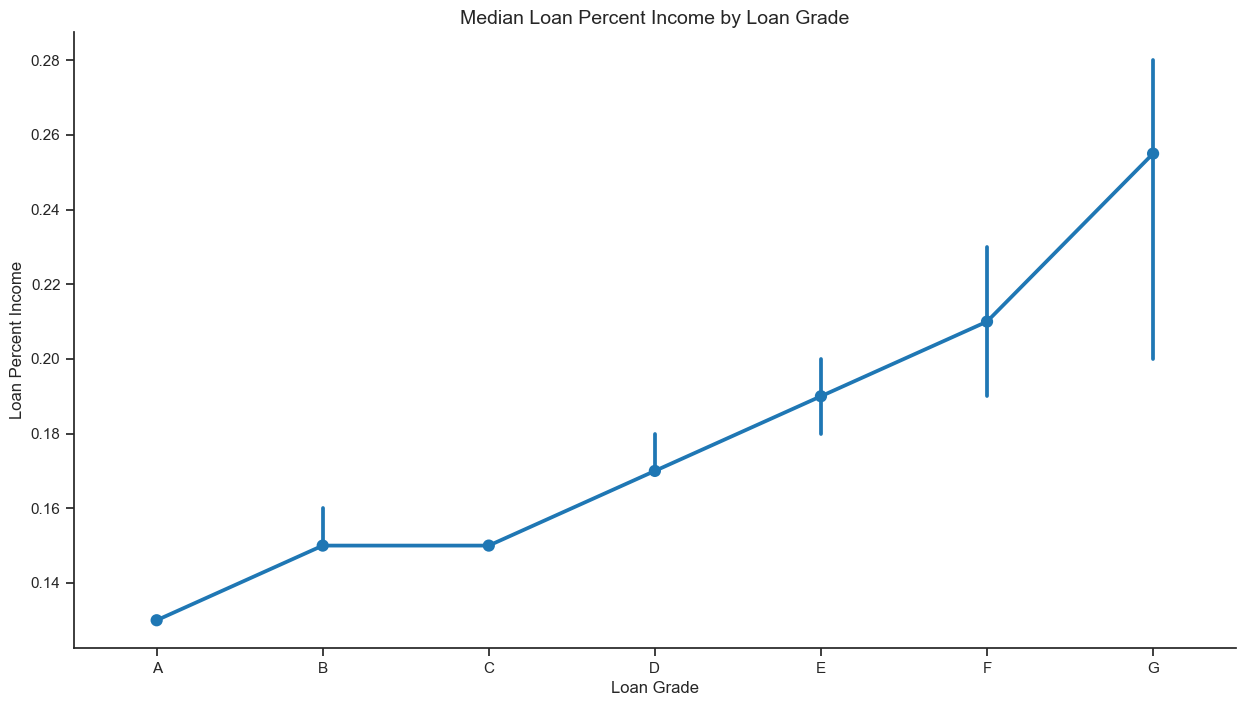

In [33]:
ax = sns.pointplot(data=cr_df.sort_values(by='loan_grade'), x="loan_grade", y="loan_percent_income", estimator='median')
ax.set_title("Median Loan Percent Income by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

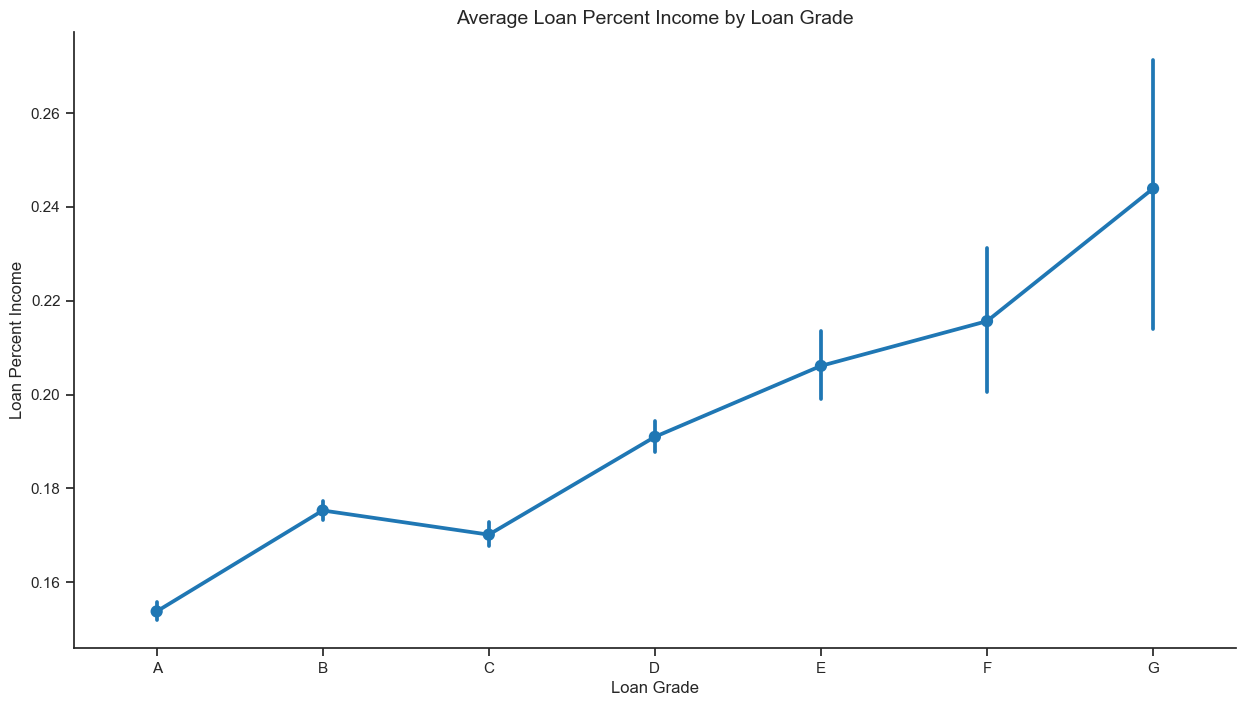

In [29]:
ax = sns.pointplot(data=cr_df.sort_values(by='loan_grade'), x="loan_grade", y="loan_percent_income")
ax.set_title("Average Loan Percent Income by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

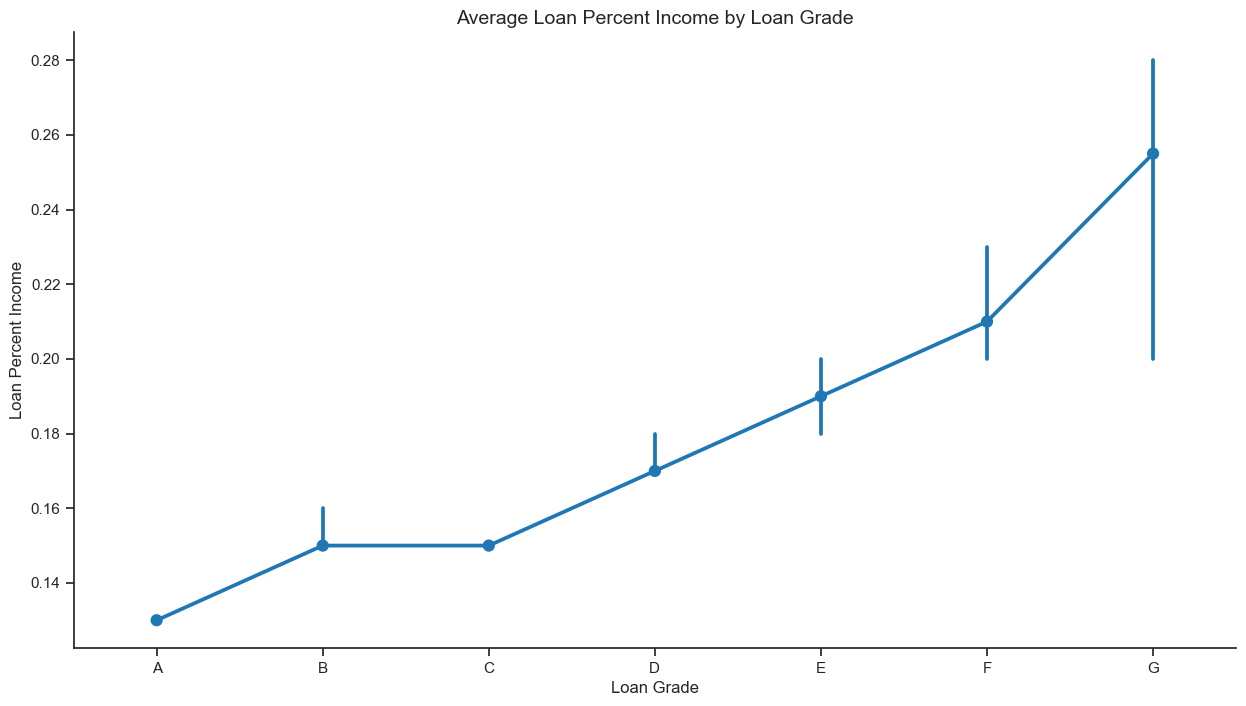

In [30]:
ax = sns.pointplot(data=cr_df.sort_values(by='loan_grade'), x="loan_grade", y="loan_percent_income", estimator='median')
ax.set_title("Average Loan Percent Income by Loan Grade", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

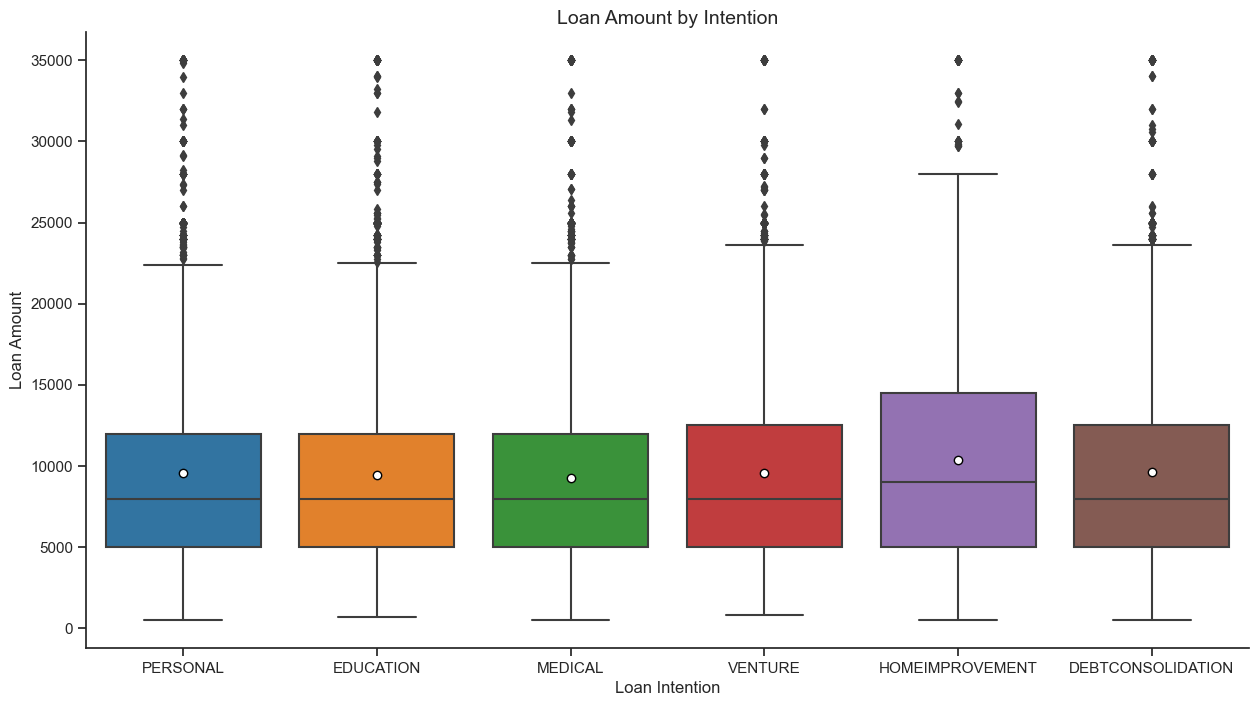

In [43]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df, x='loan_intent', y='loan_amnt', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Loan Amount by Intention", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

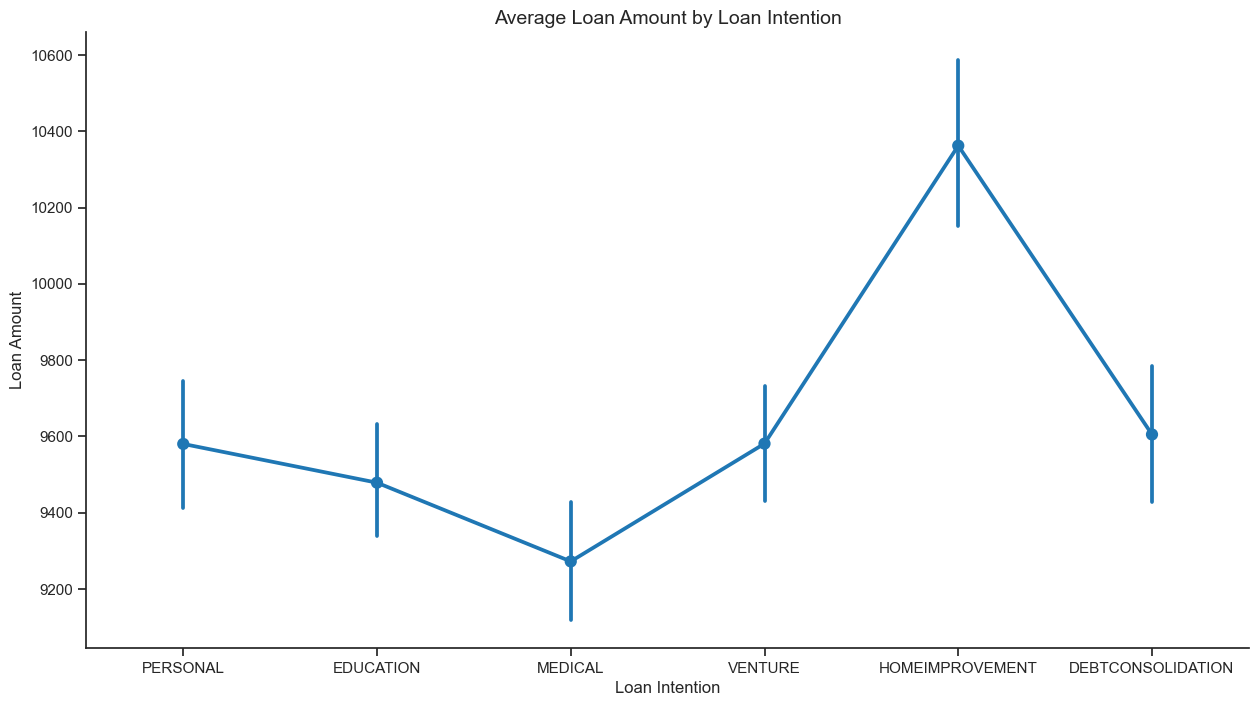

In [27]:
ax = sns.pointplot(data=cr_df, x="loan_intent", y="loan_amnt")
ax.set_title("Average Loan Amount by Loan Intention", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

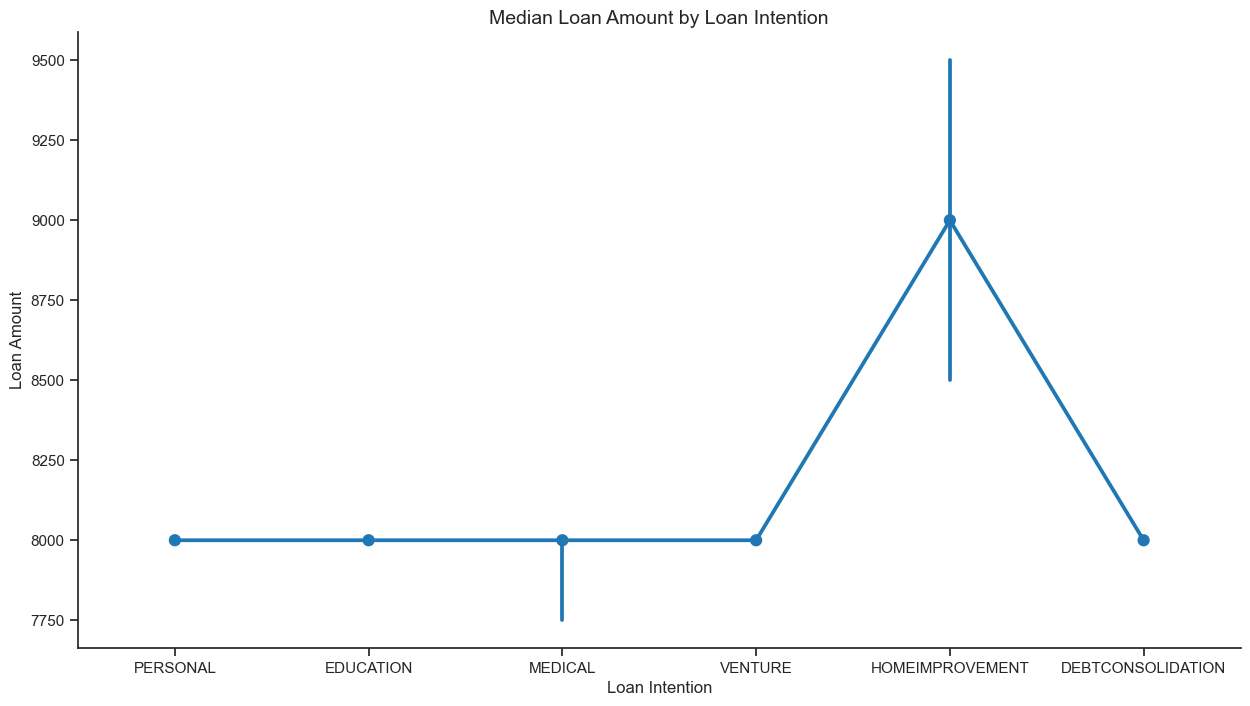

In [28]:
ax = sns.pointplot(data=cr_df, x="loan_intent", y="loan_amnt", estimator='median')
ax.set_title("Median Loan Amount by Loan Intention", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

<Figure size 2000x1500 with 0 Axes>

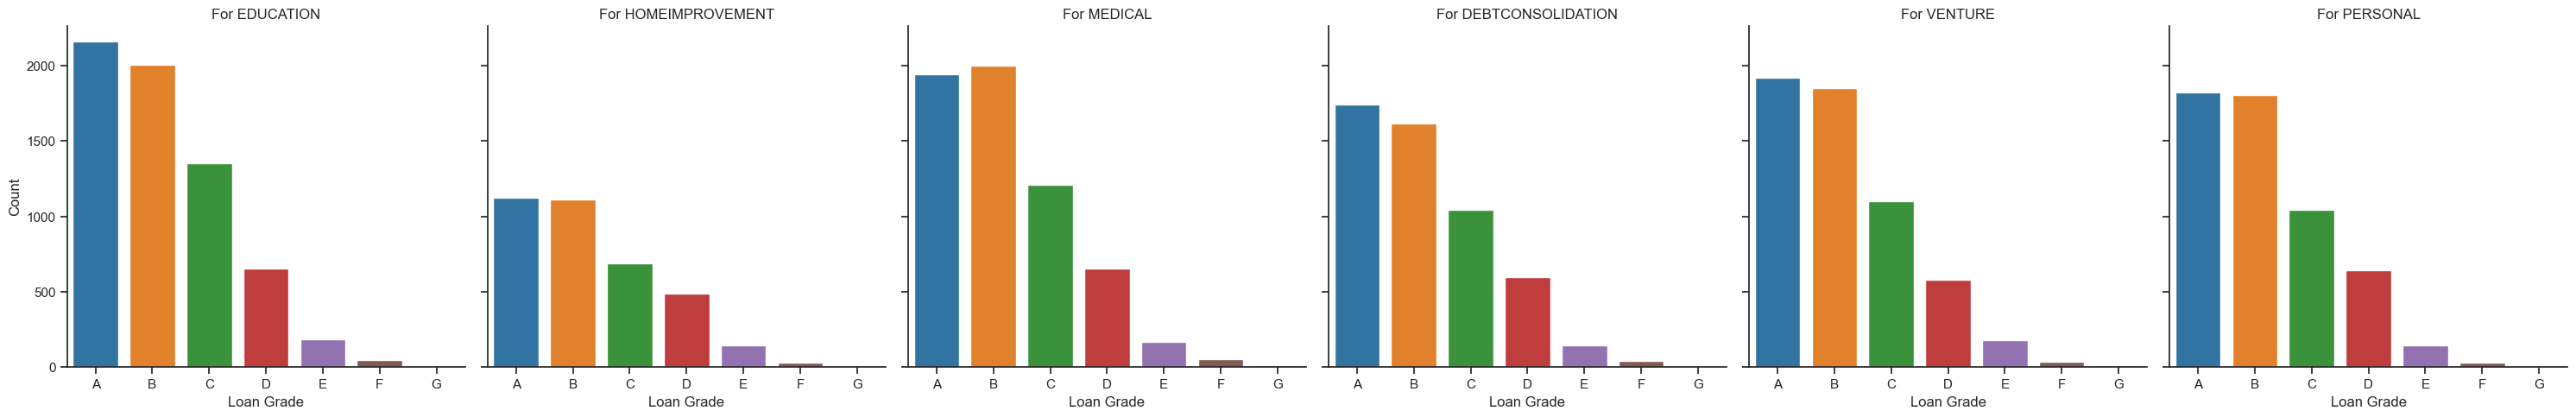

In [44]:
plt.figure(figsize=(20,15))

ax = sns.catplot(
    data=cr_df.sort_values(by='loan_grade'), x="loan_grade", col="loan_intent",
    kind="count")
ax.set_titles('For {col_name}', fontsize=14)
ax.set_axis_labels('Loan Grade', 'Count')

plt.show()

In [45]:
# percentage loan intent overall loan grades

display(pd.crosstab(cr_df['loan_grade'], cr_df['loan_intent'], normalize=True).round(4)*100)

# percentage loan intent in every loan grades

display(pd.crosstab(cr_df['loan_grade'], cr_df['loan_intent'], normalize='columns').round(4)*100)

# percentage loan grade in every loan intent
# display(pd.crosstab(cr_df['loan_grade'], cr_df['loan_intent'], normalize='index').round(4)*100)
display(pd.crosstab(cr_df['loan_intent'], cr_df['loan_grade'], normalize='columns').round(4)*100)

loan_intent  DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
loan_grade                                                                      
A                         5.37       6.66             3.46     5.99      5.62   
B                         4.98       6.19             3.43     6.17      5.56   
C                         3.21       4.17             2.13     3.74      3.22   
D                         1.85       2.02             1.50     2.02      1.98   
E                         0.44       0.57             0.44     0.52      0.45   
F                         0.13       0.14             0.10     0.16      0.09   
G                         0.03       0.03             0.03     0.04      0.03   

loan_intent  VENTURE  
loan_grade            
A               5.92  
B               5.72  
C               3.39  
D               1.79  
E               0.55  
F               0.12  
G               0.04

loan_intent  DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
loan_grade                                                                      
A                        33.53      33.66            31.22    32.16     33.13   
B                        31.08      31.30            30.88    33.11     32.79   
C                        20.06      21.06            19.23    20.06     18.98   
D                        11.52      10.24            13.55    10.85     11.70   
E                         2.78       2.89             3.98     2.77      2.67   
F                         0.83       0.72             0.89     0.86      0.55   
G                         0.19       0.14             0.25     0.20      0.18   

loan_intent  VENTURE  
loan_grade            
A              33.77  
B              32.62  
C              19.35  
D              10.23  
E               3.12  
F               0.67  
G               0.25

loan_grade             A      B      C      D      E      F      G
loan_intent                                                       
DEBTCONSOLIDATION  16.26  15.54  16.18  16.52  14.95  17.84  15.62
EDUCATION          20.16  19.32  20.98  18.12  19.21  19.09  14.06
HOMEIMPROVEMENT    10.49  10.69  10.74  13.45  14.85  13.28  14.06
MEDICAL            18.15  19.25  18.82  18.09  17.34  21.58  18.75
PERSONAL           17.02  17.36  16.21  17.76  15.26  12.45  15.62
VENTURE            17.93  17.85  17.08  16.05  18.38  15.77  21.88

<Figure size 2000x1500 with 0 Axes>

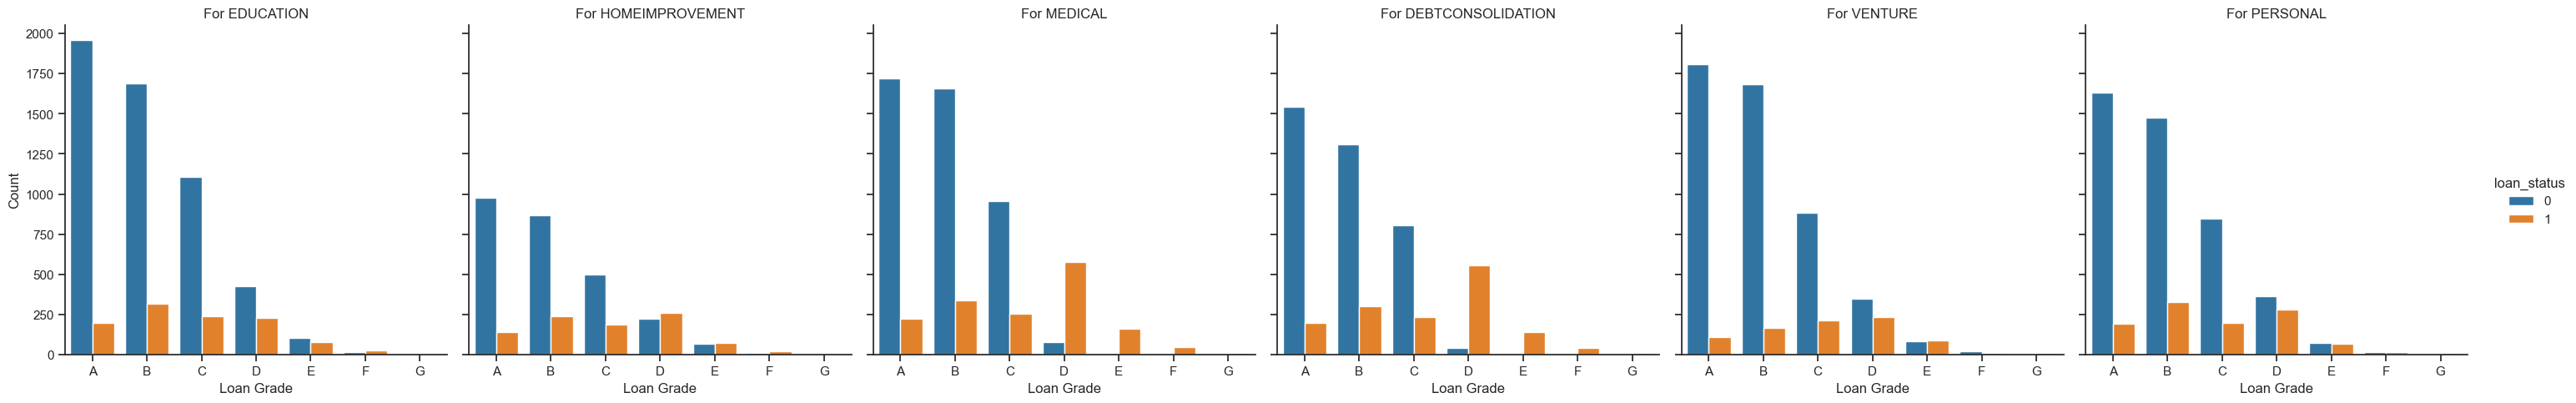

In [46]:
plt.figure(figsize=(20,15))

ax = sns.catplot(
    data=cr_df.sort_values(by='loan_grade'), x="loan_grade", col="loan_intent",
    kind="count", hue='loan_status')
ax.set_titles('For {col_name}', fontsize=14)
ax.set_axis_labels('Loan Grade', 'Count')

plt.show()

Text(0, 0.5, 'Count')

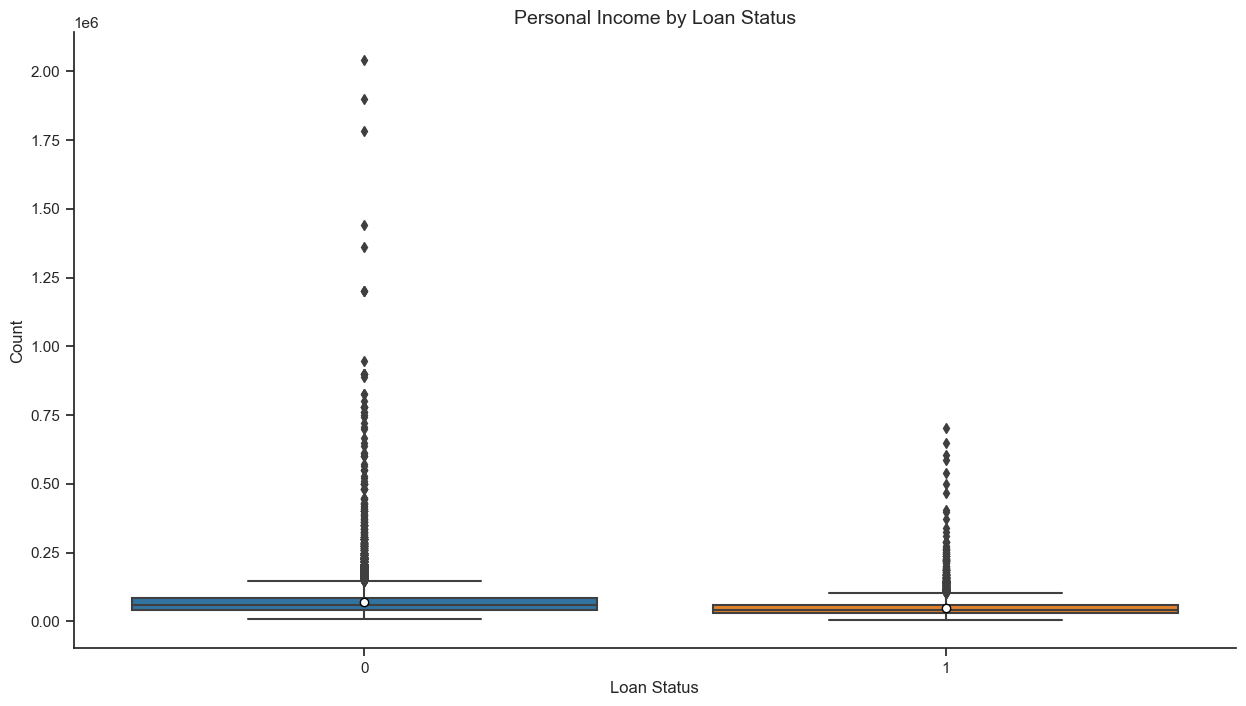

In [35]:
plt.figure(figsize=(15,8))

ax1 = sns.boxplot(data=cr_df, x='loan_status', y='person_income', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax1.set_title('Personal Income by Loan Status', fontsize=14)
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Count')

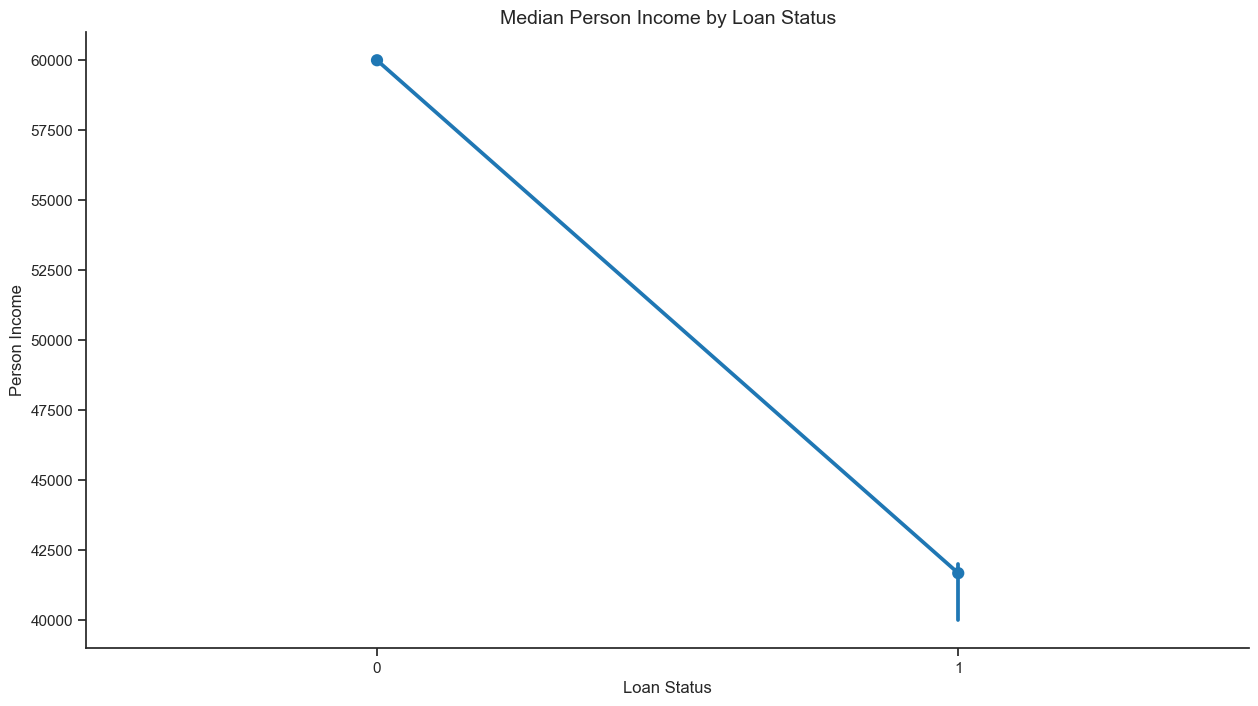

In [39]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="person_income", estimator='median')
ax.set_title("Median Person Income by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Person Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

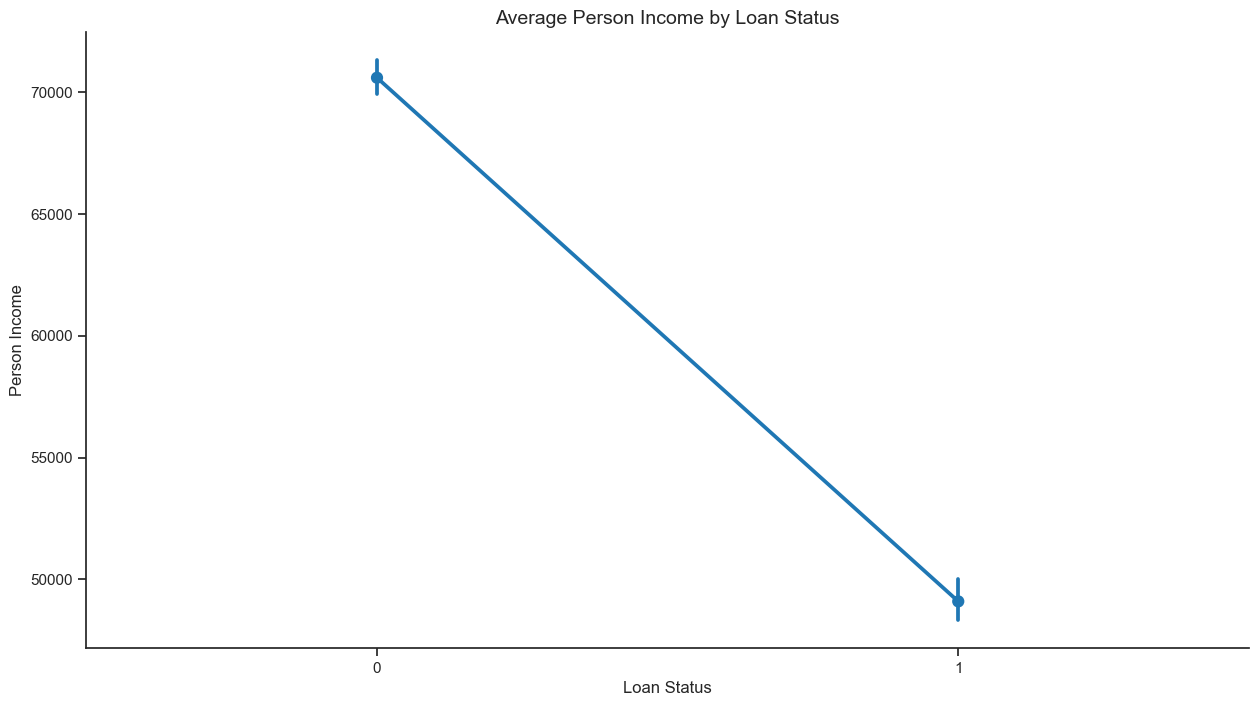

In [40]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="person_income")
ax.set_title("Average Person Income by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Person Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

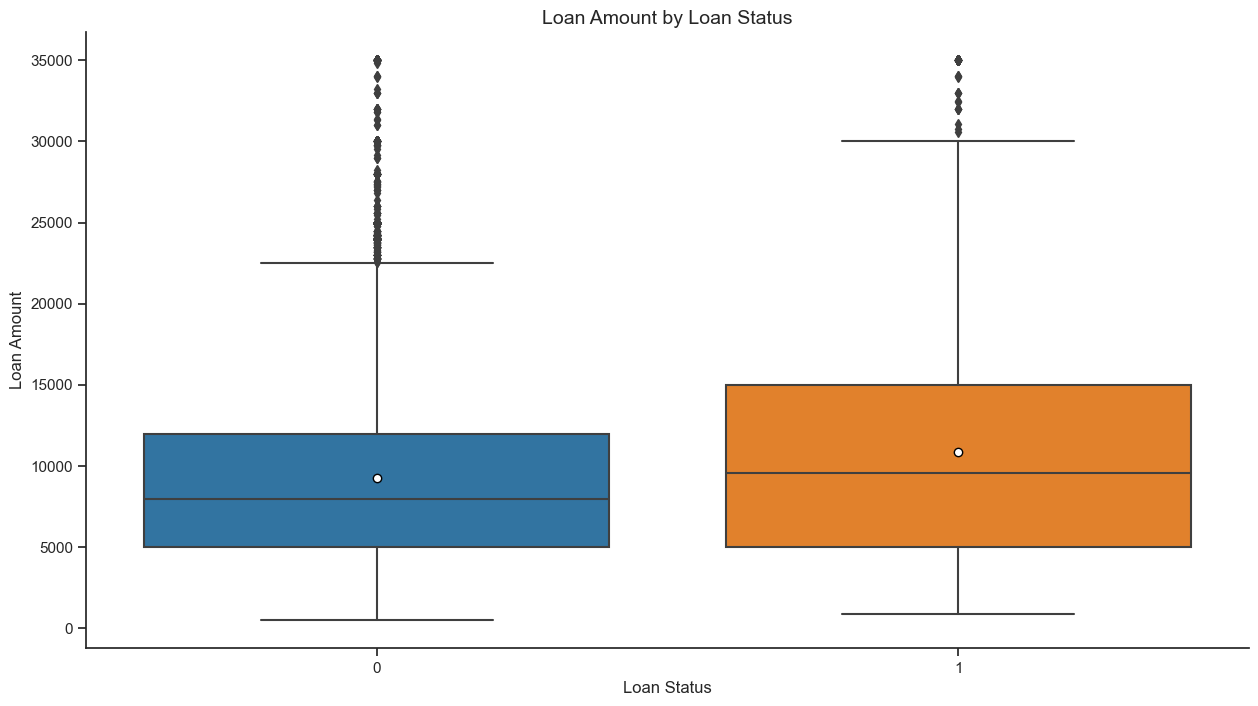

In [48]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df, x='loan_status', y='loan_amnt', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Loan Amount by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

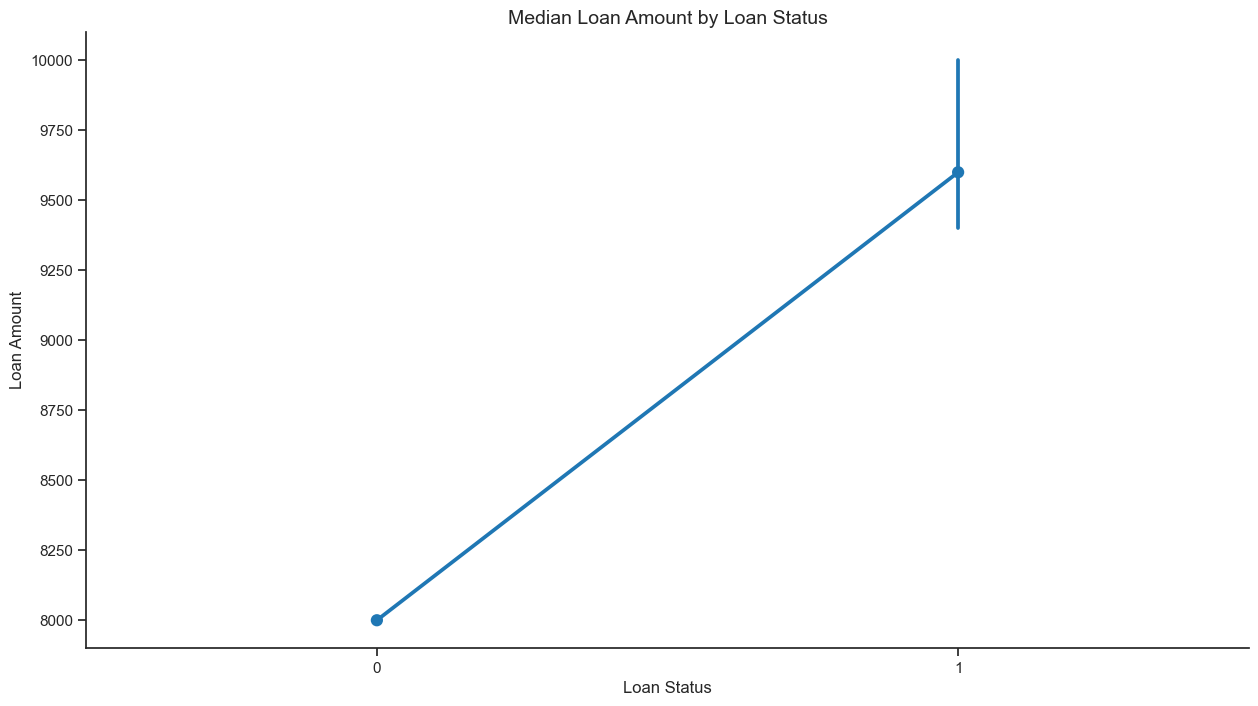

In [41]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="loan_amnt", estimator='median')
ax.set_title("Median Loan Amount by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

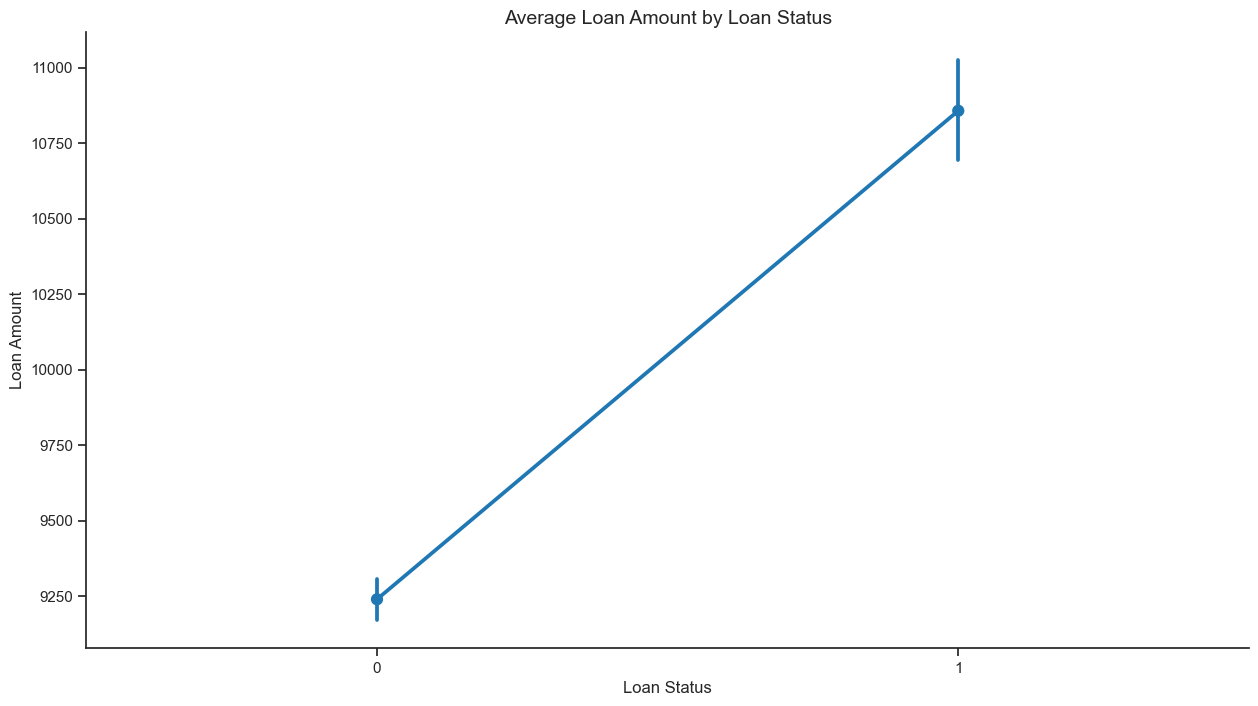

In [42]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="loan_amnt")
ax.set_title("Average Loan Amount by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Amount')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

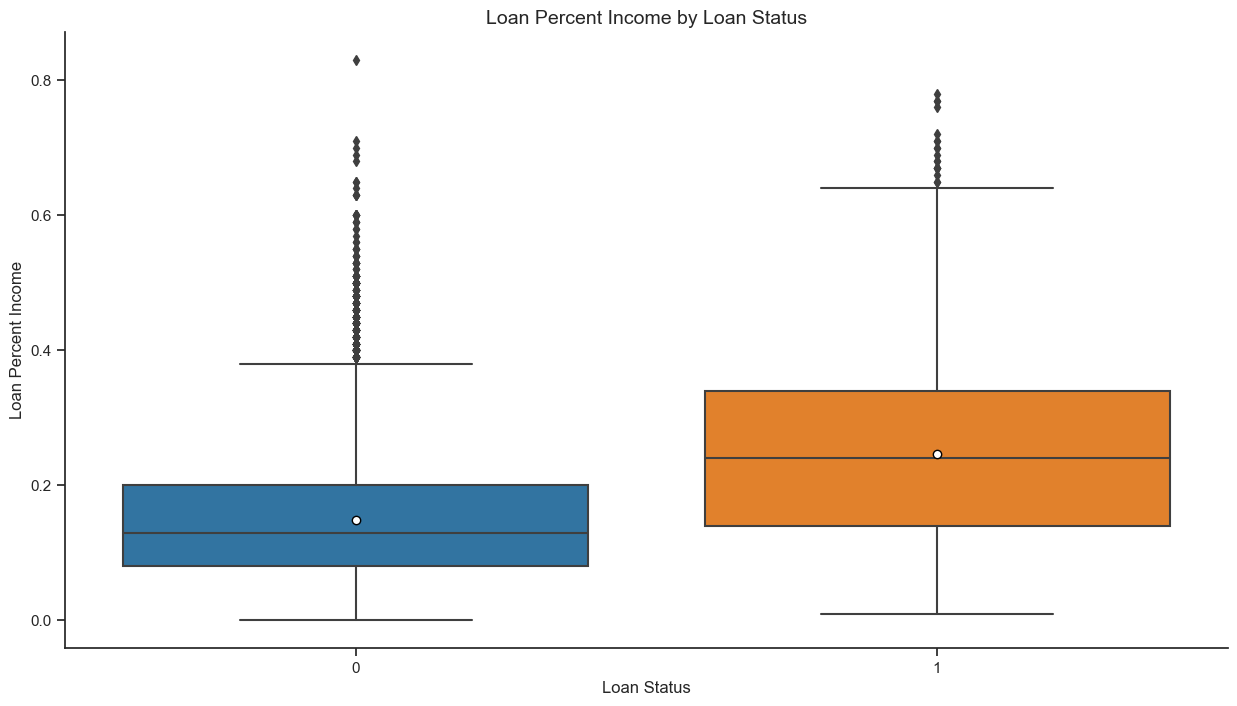

In [49]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df, x='loan_status', y='loan_percent_income', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Loan Percent Income by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

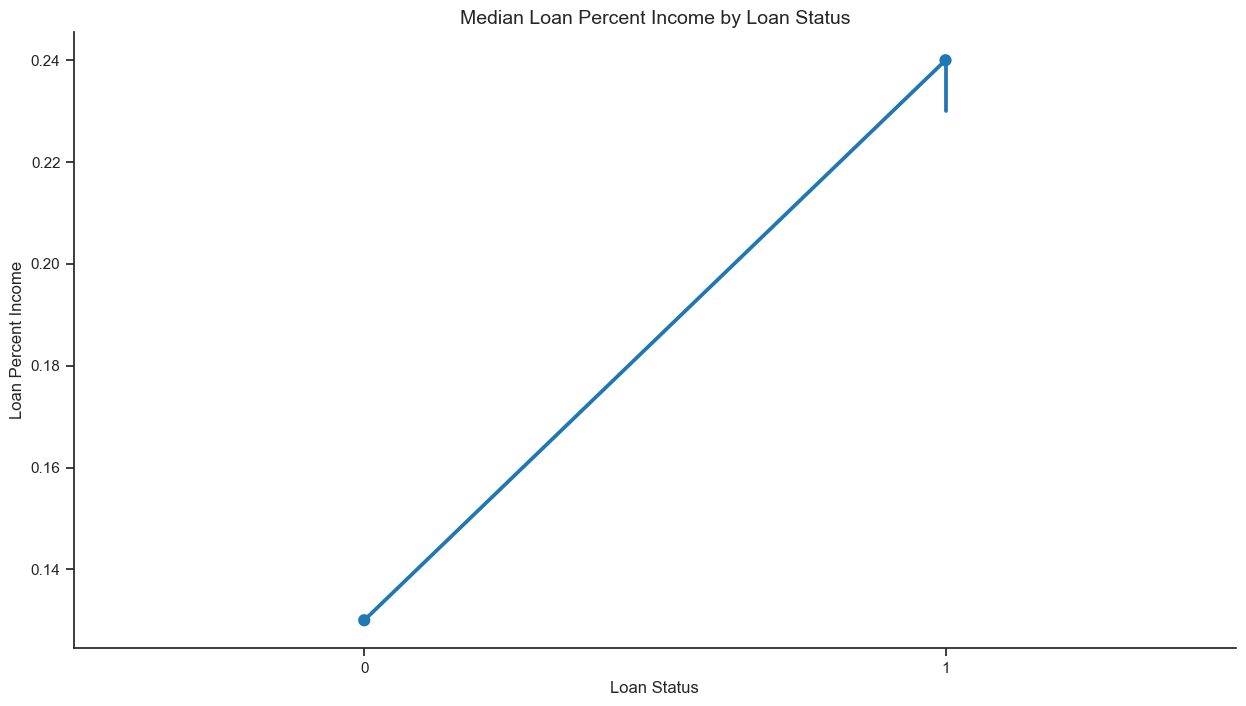

In [43]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="loan_percent_income", estimator='median')
ax.set_title("Median Loan Percent Income by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

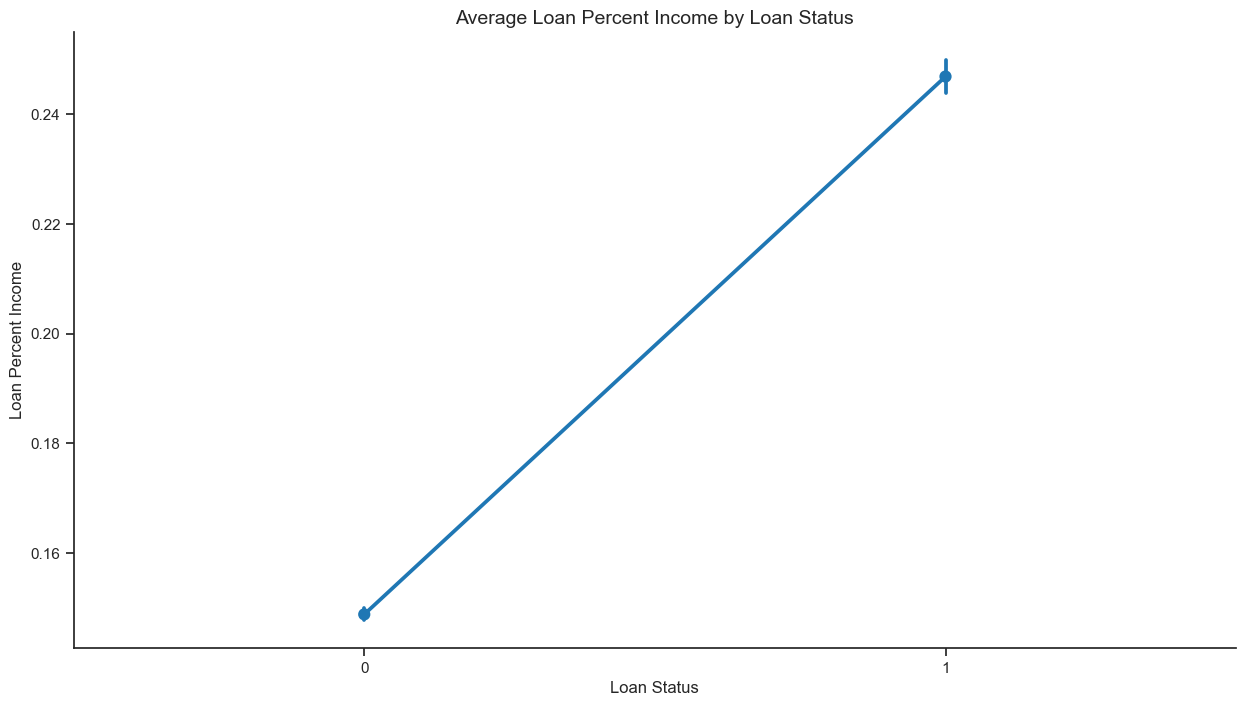

In [44]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="loan_percent_income")
ax.set_title("Average Loan Percent Income by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Percent Income')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

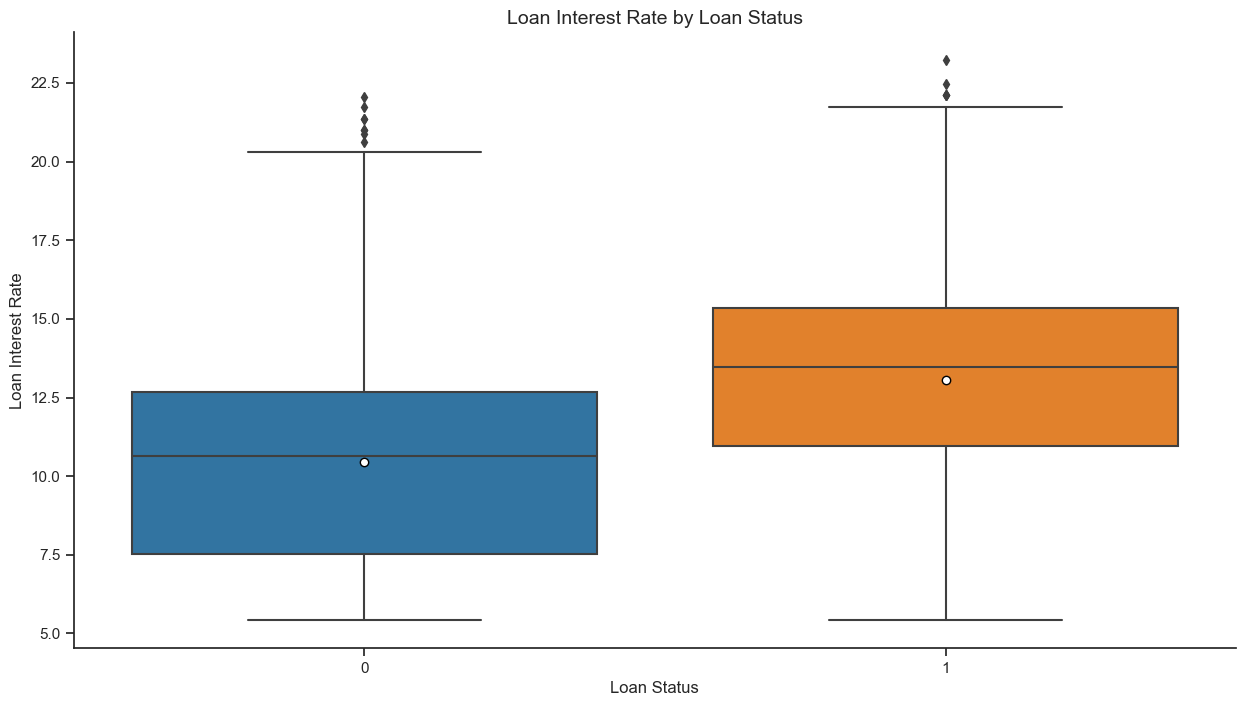

In [50]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(data=cr_df, x='loan_status', y='loan_int_rate', showmeans=True, 
                 meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black"})
ax.set_title("Loan Interest Rate by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Interest Rate')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

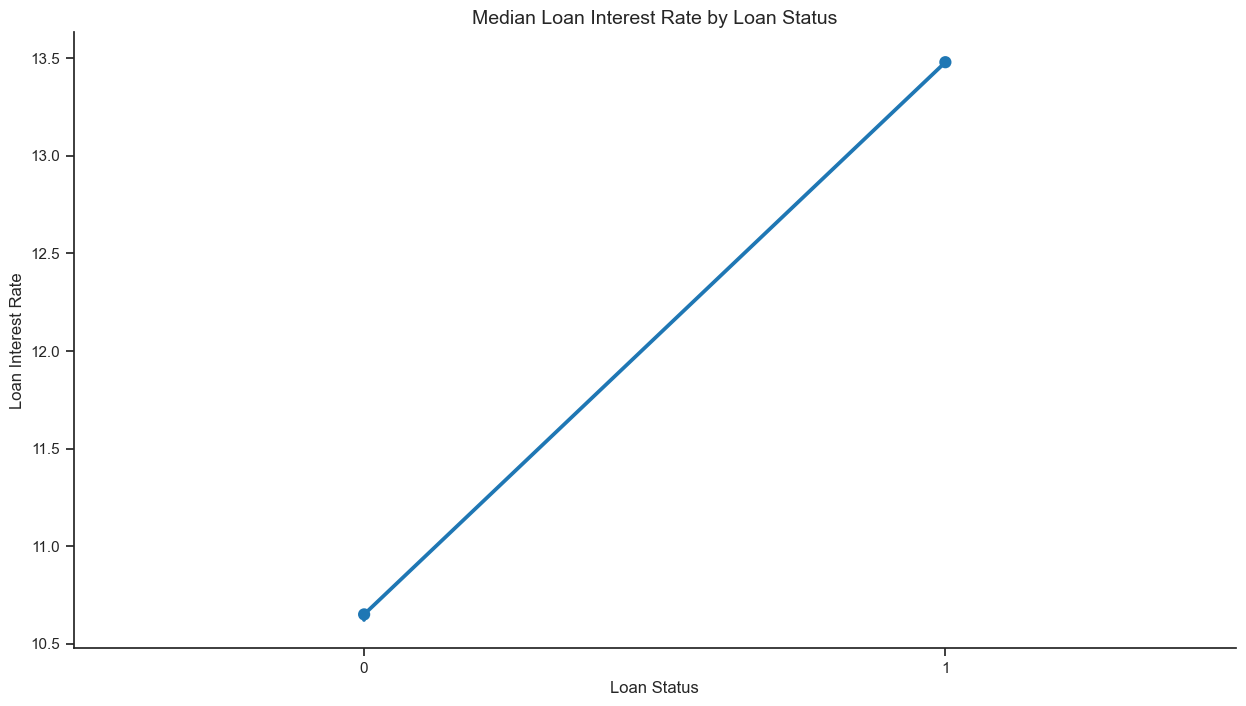

In [45]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="loan_int_rate", estimator='median')
ax.set_title("Median Loan Interest Rate by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Interest Rate')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

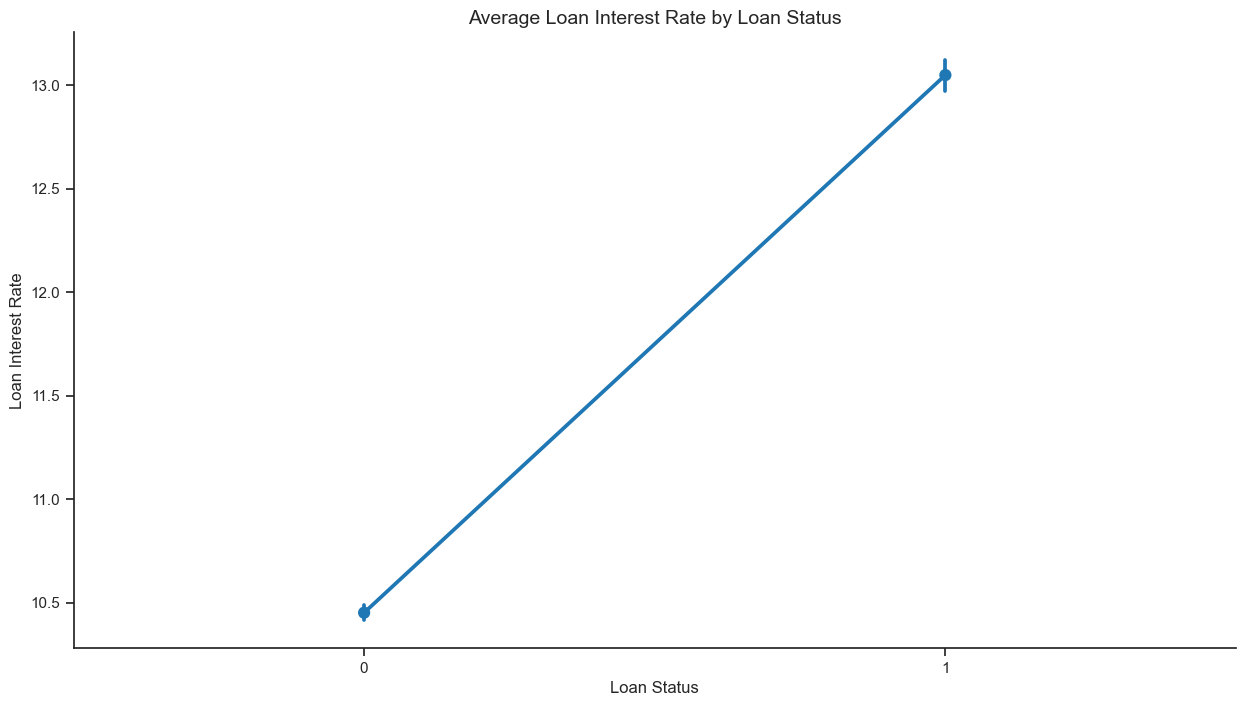

In [46]:
ax = sns.pointplot(data=cr_df, x="loan_status", y="loan_int_rate")
ax.set_title("Average Loan Interest Rate by Loan Status", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Interest Rate')
# ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

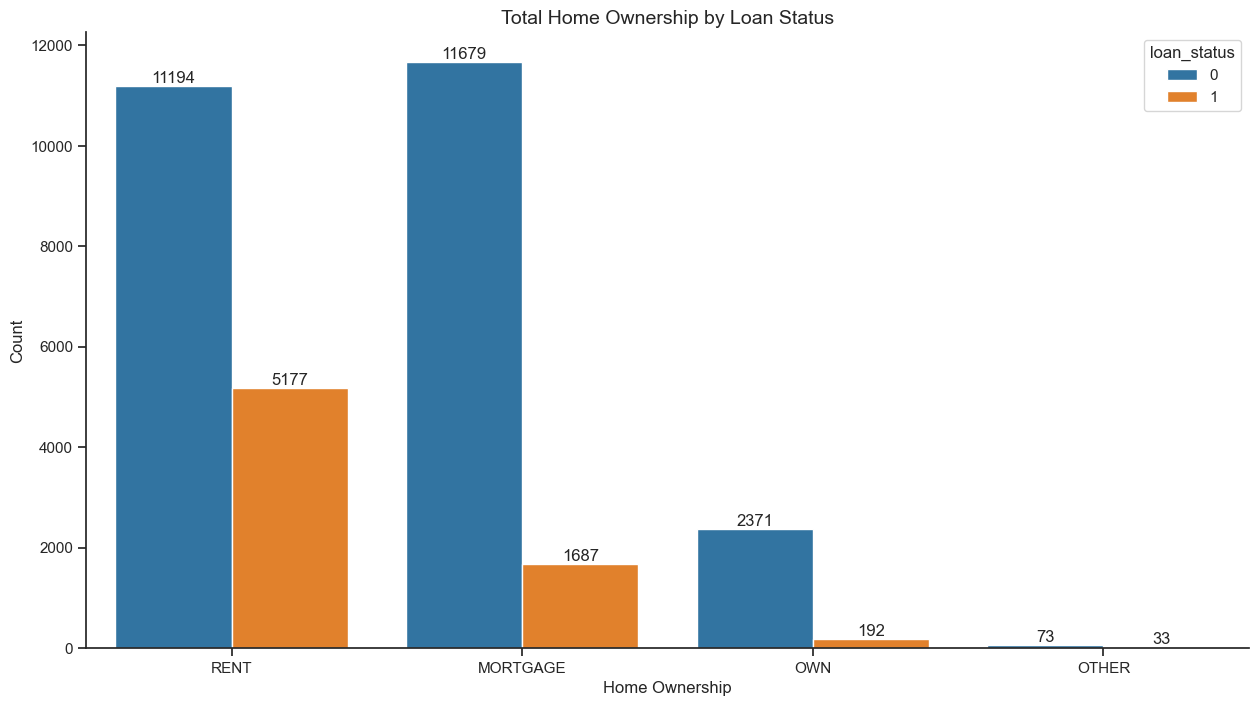

In [71]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df, x='person_home_ownership', hue='loan_status', order=cr_df['person_home_ownership'].value_counts().index)
ax.set_title("Total Home Ownership by Loan Status", fontsize=14)
ax.set_xlabel('Home Ownership')
ax.set_ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

In [53]:
# percentage loan status overall ownership types

display(pd.crosstab(cr_df['loan_status'], cr_df['person_home_ownership'], normalize=True).round(4)*100)

# percentage loan status every home ownership types

display(pd.crosstab(cr_df['loan_status'], cr_df['person_home_ownership'], normalize='columns').round(4)*100)

person_home_ownership  MORTGAGE  OTHER   OWN   RENT
loan_status                                        
0                         36.04   0.23  7.32  34.54
1                          5.21   0.10  0.59  15.98

person_home_ownership  MORTGAGE  OTHER    OWN   RENT
loan_status                                         
0                         87.38  68.87  92.51  68.38
1                         12.62  31.13   7.49  31.62

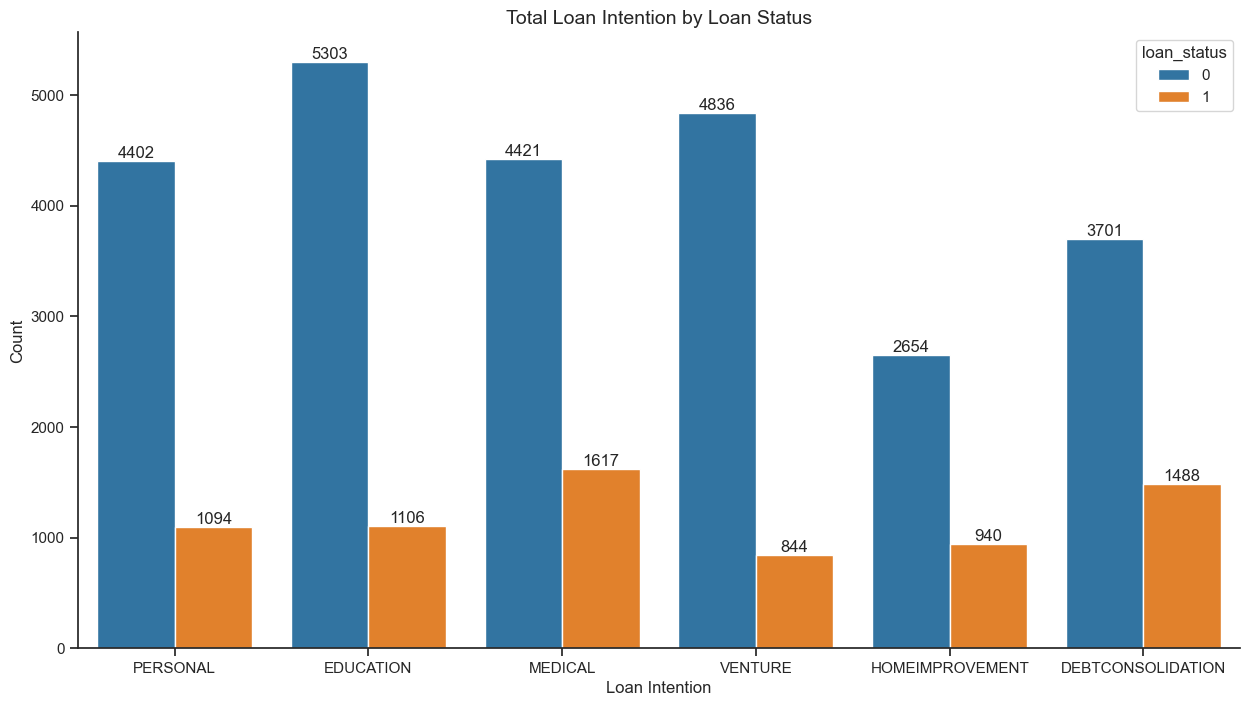

In [54]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df, x='loan_intent', hue='loan_status')
ax.set_title("Total Loan Intention by Loan Status", fontsize=14)
ax.set_xlabel('Loan Intention')
ax.set_ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

In [55]:
# percentage loan status overall loan intention

display(pd.crosstab(cr_df['loan_status'], cr_df['loan_intent'], normalize=True).round(4)*100)

# percentage loan intention in every loan status

display(pd.crosstab(cr_df['loan_status'], cr_df['loan_intent'], normalize='columns').round(4)*100)

loan_intent  DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
loan_status                                                                     
0                        11.42      16.36             8.19    13.64     13.58   
1                         4.59       3.41             2.90     4.99      3.38   

loan_intent  VENTURE  
loan_status           
0              14.92  
1               2.60

loan_intent  DEBTCONSOLIDATION  EDUCATION  HOMEIMPROVEMENT  MEDICAL  PERSONAL  \
loan_status                                                                     
0                        71.32      82.74            73.85    73.22     80.09   
1                        28.68      17.26            26.15    26.78     19.91   

loan_intent  VENTURE  
loan_status           
0              85.14  
1              14.86

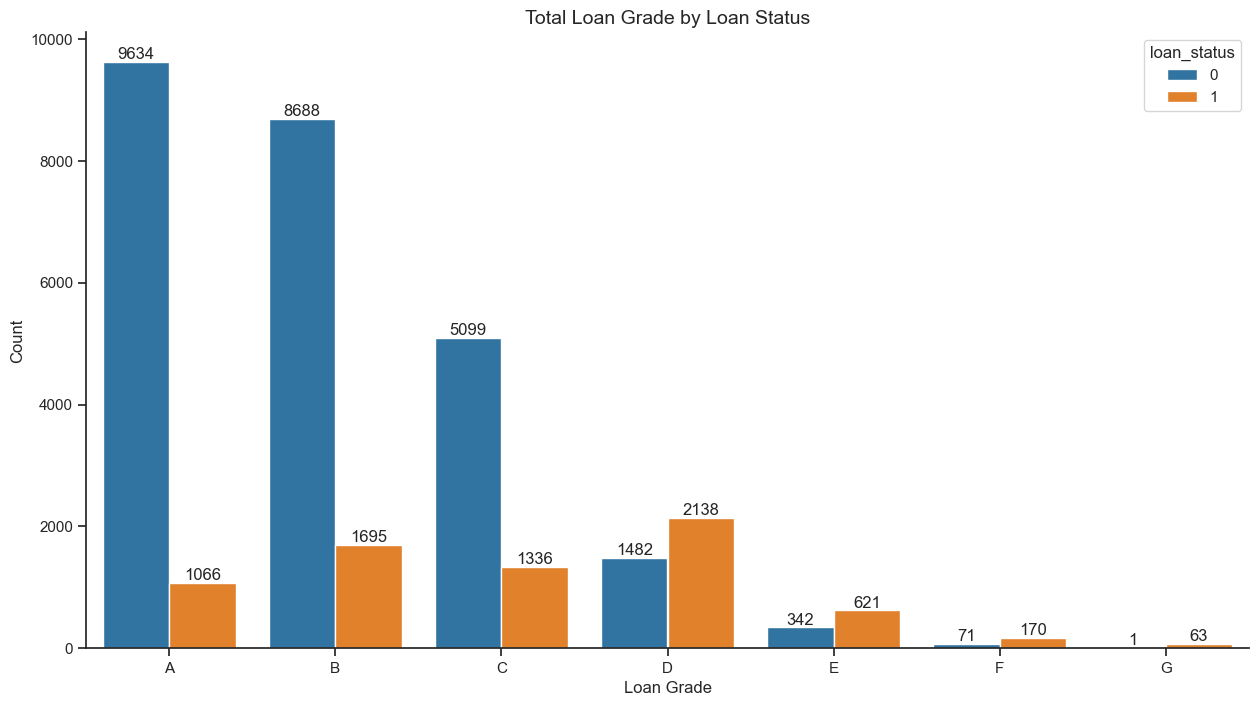

In [56]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df.sort_values(by='loan_grade'), x='loan_grade', hue='loan_status')
ax.set_title("Total Loan Grade by Loan Status", fontsize=14)
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

In [57]:
# percentage loan status overall loan grades

display(pd.crosstab(cr_df['loan_status'], cr_df['loan_grade'], normalize=True).round(4)*100)

# percentage loan grades in every loan status

display(pd.crosstab(cr_df['loan_status'], cr_df['loan_grade'], normalize='columns').round(4)*100)

loan_grade       A      B      C     D     E     F     G
loan_status                                             
0            29.73  26.81  15.73  4.57  1.06  0.22  0.00
1             3.29   5.23   4.12  6.60  1.92  0.52  0.19

loan_grade       A      B      C      D      E      F      G
loan_status                                                 
0            90.04  83.68  79.24  40.94  35.51  29.46   1.56
1             9.96  16.32  20.76  59.06  64.49  70.54  98.44

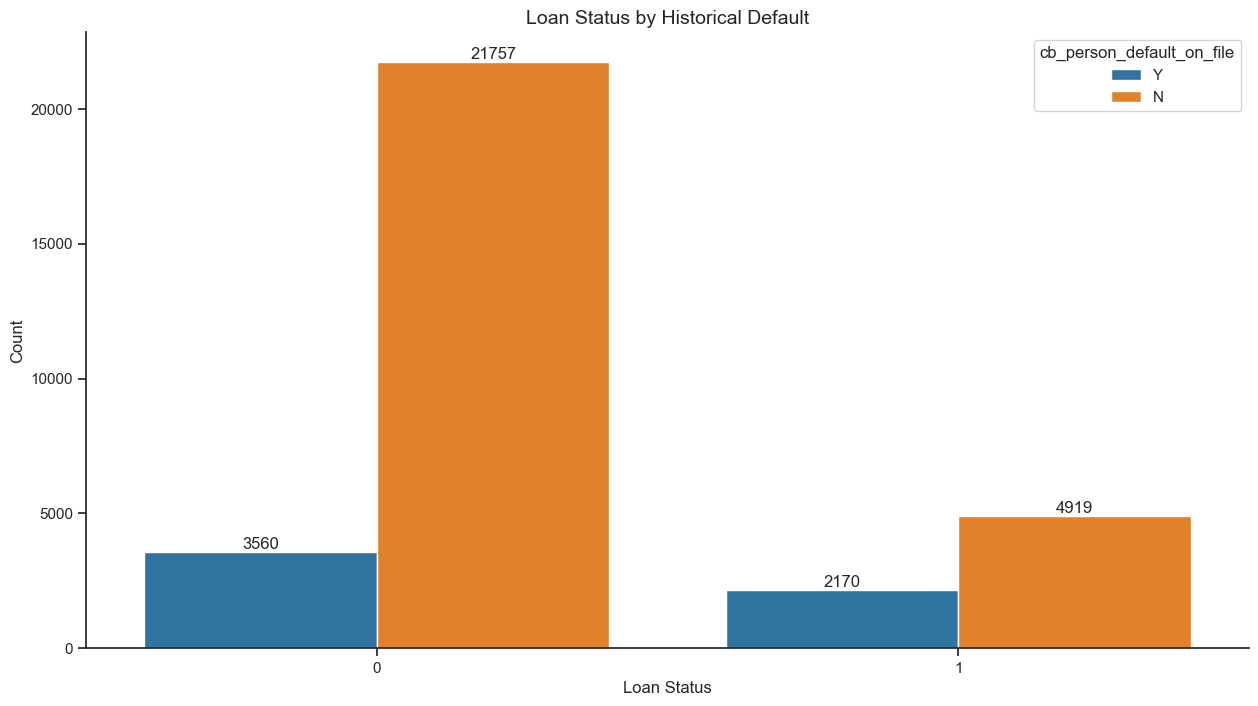

In [58]:
plt.figure(figsize=(15,8))

ax = sns.countplot(data=cr_df, x='loan_status', hue='cb_person_default_on_file')
ax.set_title("Loan Status by Historical Default", fontsize=14)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Count')
for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

In [59]:
# percentage loan status overall historical default 

display(pd.crosstab(cr_df['loan_status'], cr_df['cb_person_default_on_file'], normalize=True).round(4)*100)

# percentage historical default  in every loan status

display(pd.crosstab(cr_df['loan_status'], cr_df['cb_person_default_on_file'], normalize='columns').round(4)*100)

cb_person_default_on_file      N      Y
loan_status                            
0                          67.14  10.99
1                          15.18   6.70

cb_person_default_on_file      N      Y
loan_status                            
0                          81.56  62.13
1                          18.44  37.87

# Feature Engineering

## Target Variables for Model

In [8]:
# make target variable from loan status

# cr_df['good_credit'] = 0
# cr_df['good_credit'] = cr_df['good_credit'].where(cr_df['loan_status'] == 1, 1)
cr_df['bad_credit'] = cr_df['loan_status']


# change cb_person_default_on_file to binary
cr_df.loc[cr_df['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file'] = 1
cr_df.loc[cr_df['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file'] = 0

cr_df

person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT                4.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
32401          57          53000              MORTGAGE                1.0   
32402          54         120000              MORTGAGE                4.0   
32403          65          76000                  RENT                3.0   
32404          56         150000              MORTGAGE                5.0   
32405          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0             PERSONAL          D      35000          16.02            1   
1            EDUCATION          B       1000          11.14            0   
2              MEDICAL          C       5500          12.87            1   
3              MEDICAL          C      35000          15.23            1   
4              MEDICAL          C      35000          14.27            1   
...                ...        ...        ...            ...          ...   
32401         PERSONAL          C       5800          13.16            0   
32402         PERSONAL          A      17625           7.49            0   
32403  HOMEIMPROVEMENT          B      35000          10.99            1   
32404         PERSONAL          B      15000          11.48            0   
32405          MEDICAL          B       6475           9.99            0   

       loan_percent_income cb_person_default_on_file  \
0                     0.59                         1   
1                     0.10                         0   
2                     0.57                         0   
3                     0.53                         0   
4                     0.55                         1   
...                    ...                       ...   
32401                 0.11                         0   
32402                 0.15                         0   
32403                 0.46                         0   
32404                 0.10                         0   
32405                 0.15                         0   

       cb_person_cred_hist_length  bad_credit  
0                               3           1  
1                               2           0  
2                               3           1  
3                               2           1  
4                               4           1  
...                           ...         ...  
32401                          30           0  
32402                          19           0  
32403                          28           1  
32404                          26           0  
32405                          30           0  

[32406 rows x 13 columns]

`bad_credit` information: \
0 : good credit (succeded to pay) \
1 : bad credit (failed to pay)

## Transform Data

We will drop `loan_status`. \
We will drop `loan_int_rate` since it has correlation with `loan_grade`.

In [9]:
# copy df for model

df = cr_df.copy().drop(columns=['loan_status', 'loan_int_rate'])
#display(df)

# transform columns
ct = make_column_transformer(
    (MinMaxScaler(),   make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(drop='first'),  make_column_selector(dtype_include=object)))

result = ct.fit_transform(df)
df = pd.DataFrame(result, columns=ct.get_feature_names_out())
#display(df)

# edit column name
cols = df.columns
new_col = []
for col in cols:
    new_col.append(col.split('__')[1])
    
df.columns = new_col
display(df)

person_age  person_income  person_emp_length  loan_amnt  \
0        0.037736       0.027017           0.105263   1.000000   
1        0.018868       0.002751           0.131579   0.014493   
2        0.094340       0.002751           0.026316   0.144928   
3        0.056604       0.030209           0.105263   1.000000   
4        0.075472       0.024757           0.210526   1.000000   
...           ...            ...                ...        ...   
32401    0.698113       0.024069           0.026316   0.153623   
32402    0.641509       0.056981           0.105263   0.496377   
32403    0.849057       0.035367           0.078947   1.000000   
32404    0.679245       0.071717           0.131579   0.420290   
32405    0.867925       0.018666           0.052632   0.173188   

       loan_percent_income  cb_person_cred_hist_length  bad_credit  \
0                 0.710843                    0.035714         1.0   
1                 0.120482                    0.000000         0.0   
2                 0.686747                    0.035714         1.0   
3                 0.638554                    0.000000         1.0   
4                 0.662651                    0.071429         1.0   
...                    ...                         ...         ...   
32401             0.132530                    1.000000         0.0   
32402             0.180723                    0.607143         0.0   
32403             0.554217                    0.928571         1.0   
32404             0.120482                    0.857143         0.0   
32405             0.180723                    1.000000         0.0   

       person_home_ownership_OTHER  person_home_ownership_OWN  \
0                              0.0                        0.0   
1                              0.0                        1.0   
2                              0.0                        0.0   
3                              0.0                        0.0   
4                              0.0                        0.0   
...                            ...                        ...   
32401                          0.0                        0.0   
32402                          0.0                        0.0   
32403                          0.0                        0.0   
32404                          0.0                        0.0   
32405                          0.0                        0.0   

       person_home_ownership_RENT  ...  loan_intent_MEDICAL  \
0                             1.0  ...                  0.0   
1                             0.0  ...                  0.0   
2                             0.0  ...                  1.0   
3                             1.0  ...                  1.0   
4                             1.0  ...                  1.0   
...                           ...  ...                  ...   
32401                         0.0  ...                  0.0   
32402                         0.0  ...                  0.0   
32403                         1.0  ...                  0.0   
32404                         0.0  ...                  0.0   
32405                         1.0  ...                  1.0   

       loan_intent_PERSONAL  loan_intent_VENTURE  loan_grade_B  loan_grade_C  \
0                       1.0                  0.0           0.0           0.0   
1                       0.0                  0.0           1.0           0.0   
2                       0.0                  0.0           0.0           1.0   
3                       0.0                  0.0           0.0           1.0   
4                       0.0                  0.0           0.0           1.0   
...                     ...                  ...           ...           ...   
32401                   1.0                  0.0           0.0           1.0   
32402                   1.0                  0.0           0.0           0.0   
32403                   0.0                  0.0           1.0           0.0   
32404                   1.0        

# Model

In [12]:
print(f'Percentage Good Credit: {(df["bad_credit"].value_counts()[0])/(len(df))*100 :.2f}%')
print(f'Percentage Bad Credit: {(df["bad_credit"].value_counts()[1])/(len(df))*100 :.2f}%')

# print(df['good_credit'].value_counts()[1])

Percentage Good Credit: 78.12%
Percentage Bad Credit: 21.88%


We have **imbalanced data** on target variable. So we will choose the right metrics.

We will drop `cb_person_cred_hist_length` since it has correlation with `person_age`.

In [10]:
X = df.drop(columns=['bad_credit','cb_person_cred_hist_length'])
y = df['bad_credit']

In [11]:
# select one split of data for train and test dataset

np.random.seed(42)
n = np.random.randint(0,5)

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_train_idx = []
all_test_idx = []

for train_idx, test_idx in skfold.split(X, y):
    all_train_idx.append(train_idx)
    all_test_idx.append(test_idx)
    
train = df.iloc[all_train_idx[n]]
test = df.iloc[all_test_idx[n]]

# display(train)
# display(test)

X_train = train.drop(columns=['bad_credit','cb_person_cred_hist_length'])
y_train = train['bad_credit']
X_test = test.drop(columns=['bad_credit','cb_person_cred_hist_length'])
y_test = test['bad_credit']

## F1-Score Random Forest

In [22]:
# check model

models = [('LR', LogisticRegression(random_state=42)),
          ('DT', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('Ada', AdaBoostClassifier(random_state=42)),
          ('GB', GradientBoostingClassifier(random_state=42)),
          ('ET', ExtraTreesClassifier(random_state=42))
          ]

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_name, result = f.checkModel(models, X, y, kfold=skfold, metric='f1')


LR 	 | cv_score_mean: 0.6440070589229098 	 | cv_score_std: 0.009700705311404908
DT 	 | cv_score_mean: 0.7651684173812319 	 | cv_score_std: 0.006938144068632988
RF 	 | cv_score_mean: 0.823360969413172 	 | cv_score_std: 0.007901891959420688
Ada 	 | cv_score_mean: 0.7151902790677681 	 | cv_score_std: 0.0036909781222299646
GB 	 | cv_score_mean: 0.8015833266118788 	 | cv_score_std: 0.009310318915808215
ET 	 | cv_score_mean: 0.7901902119028744 	 | cv_score_std: 0.009152981077832464


<AxesSubplot: title={'center': 'Models Comparison'}, xlabel='Models', ylabel='Metric F1 Score'>

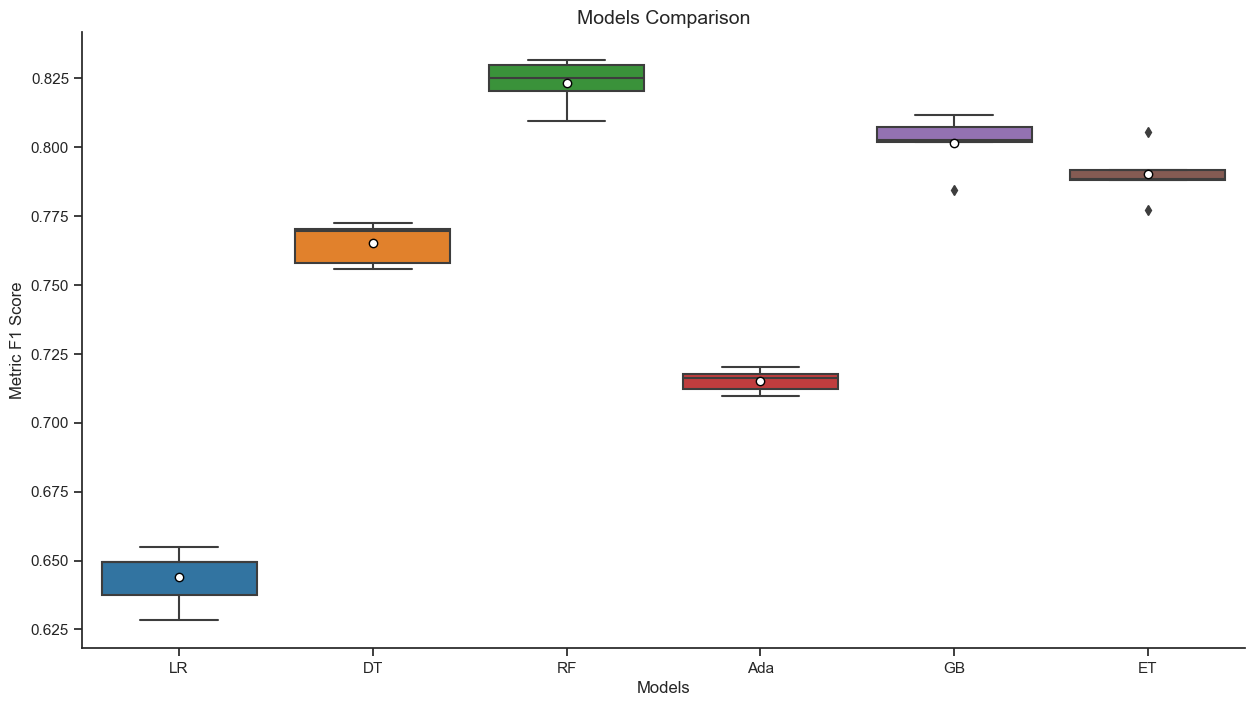

In [23]:
# boxplot model

f.boxplotModel(model_name, result, metric_name='F1')

We will use Random Forest Classifier

In [11]:
# train model and predict

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

RandomForestClassifier(random_state=42) Evaluation
----------------------------------------------------------------------
Accuracy Score: 0.9310291621663324
Balanced Accuracy Score: 0.8553301740802142
Roc Auc Score: 0.8553301740802142
Precision Score: 0.9524697110904008
Recall Score: 0.7207334273624824
F1 Score: 0.8205539943797672

classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      5063
         1.0       0.95      0.72      0.82      1418

    accuracy                           0.93      6481
   macro avg       0.94      0.86      0.89      6481
weighted avg       0.93      0.93      0.93      6481



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Prediction Labels', ylabel='True Labels'>

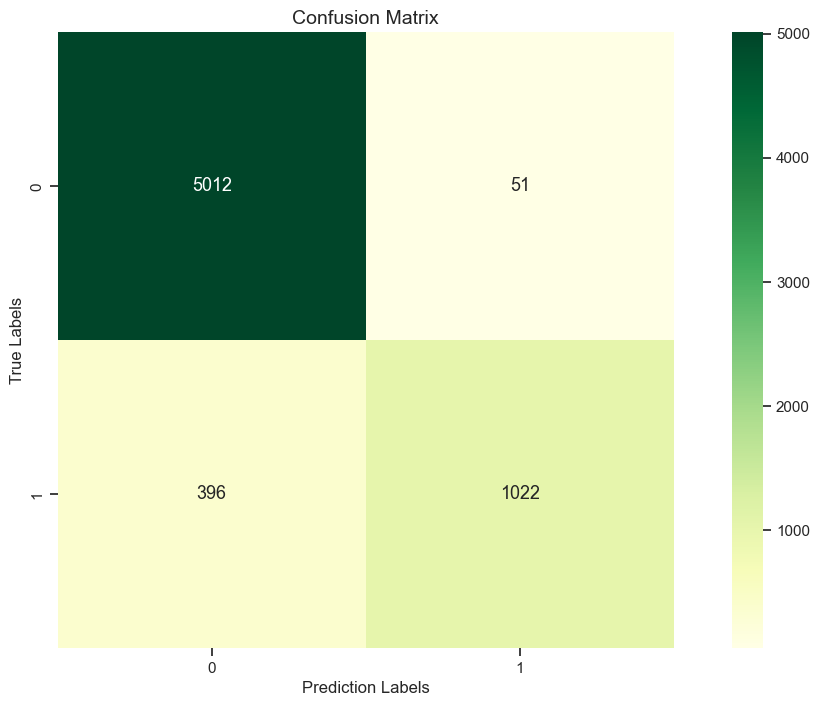

In [46]:
f.evaluateModel(y_test, y_pred, model=clf)

<AxesSubplot: title={'center': 'Random Forest Feature Importance Score'}, xlabel='Feature Importance Score', ylabel='Feature Name'>

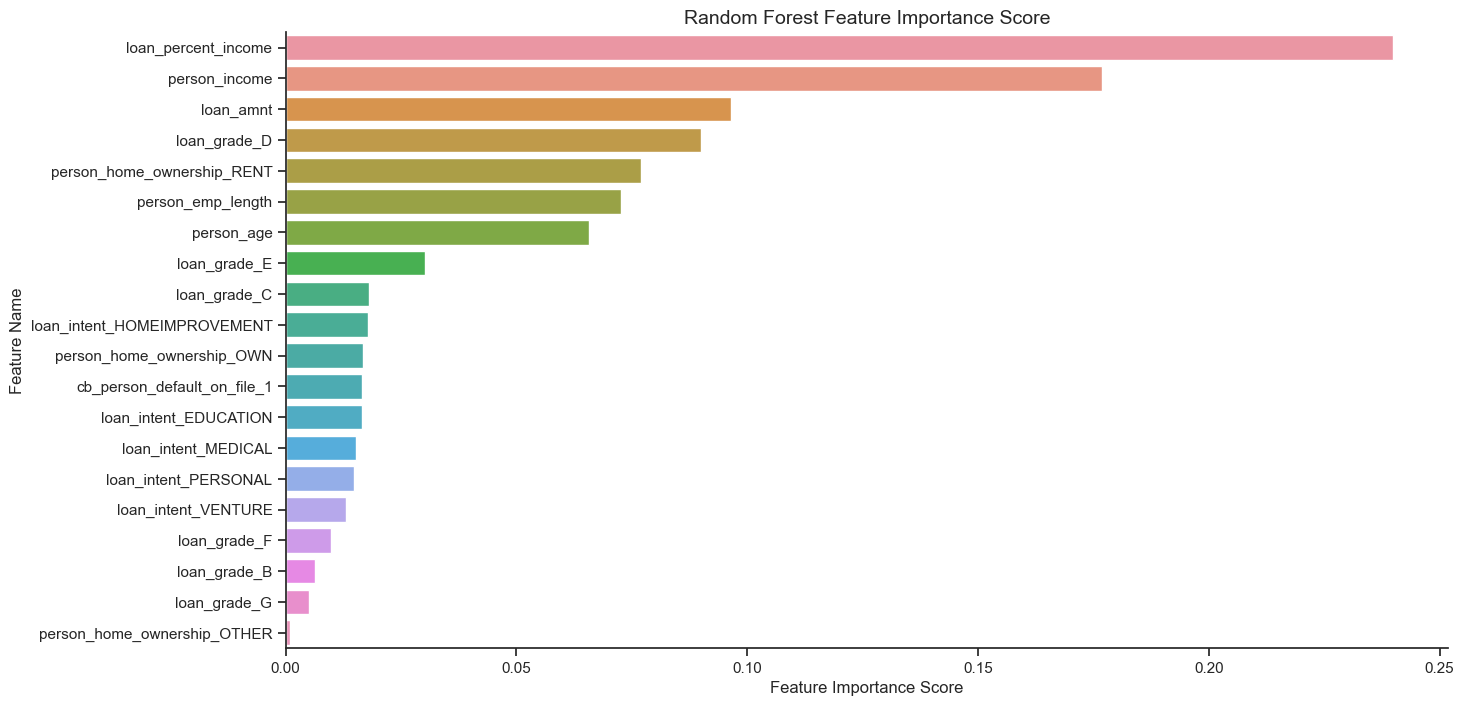

In [48]:
f.plotFeatureImportance(clf.feature_importances_, clf.feature_names_in_, 'Random Forest')

RandomForestClassifier(max_depth=45, max_features=None, min_samples_split=4,
                       n_estimators=300, random_state=42) Evaluation
----------------------------------------------------------------------
Accuracy Score: 0.9339608085172041
Balanced Accuracy Score: 0.8625374582099119
Roc Auc Score: 0.8625374582099119
Precision Score: 0.9516423357664233
Recall Score: 0.735543018335684
F1 Score: 0.8297533810660302

classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      5063
         1.0       0.95      0.74      0.83      1418

    accuracy                           0.93      6481
   macro avg       0.94      0.86      0.89      6481
weighted avg       0.94      0.93      0.93      6481



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Prediction Labels', ylabel='True Labels'>

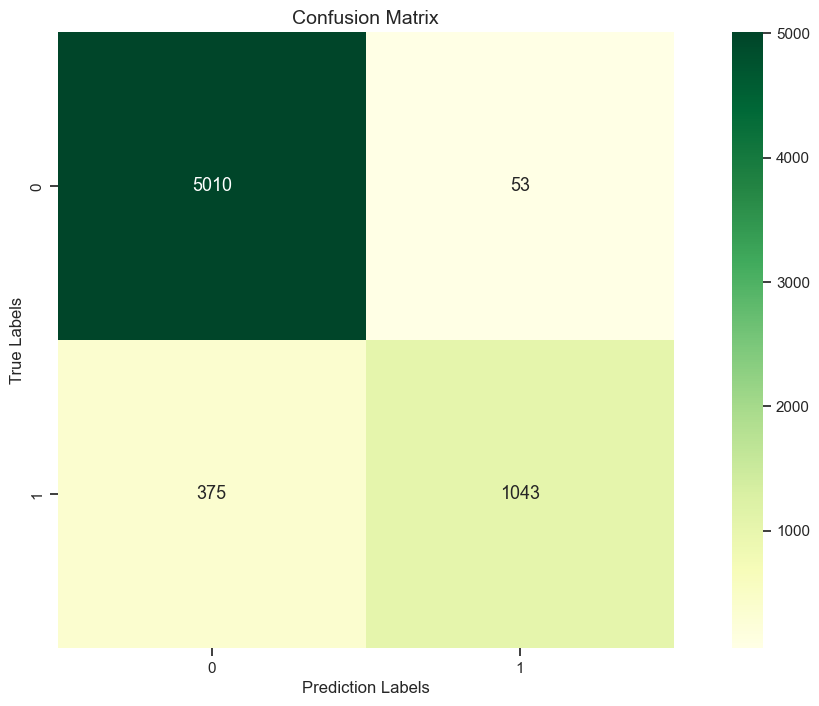

In [86]:
new_clf = RandomForestClassifier(random_state=42, n_estimators=300 , max_features=None, max_depth=45, min_samples_split=4)
new_clf.fit(X_train,y_train)
f.evaluateModel(y_test, new_clf.predict(X_test), new_clf)


<AxesSubplot: title={'center': 'Random Forest Feature Importance Score'}, xlabel='Feature Importance Score', ylabel='Feature Name'>

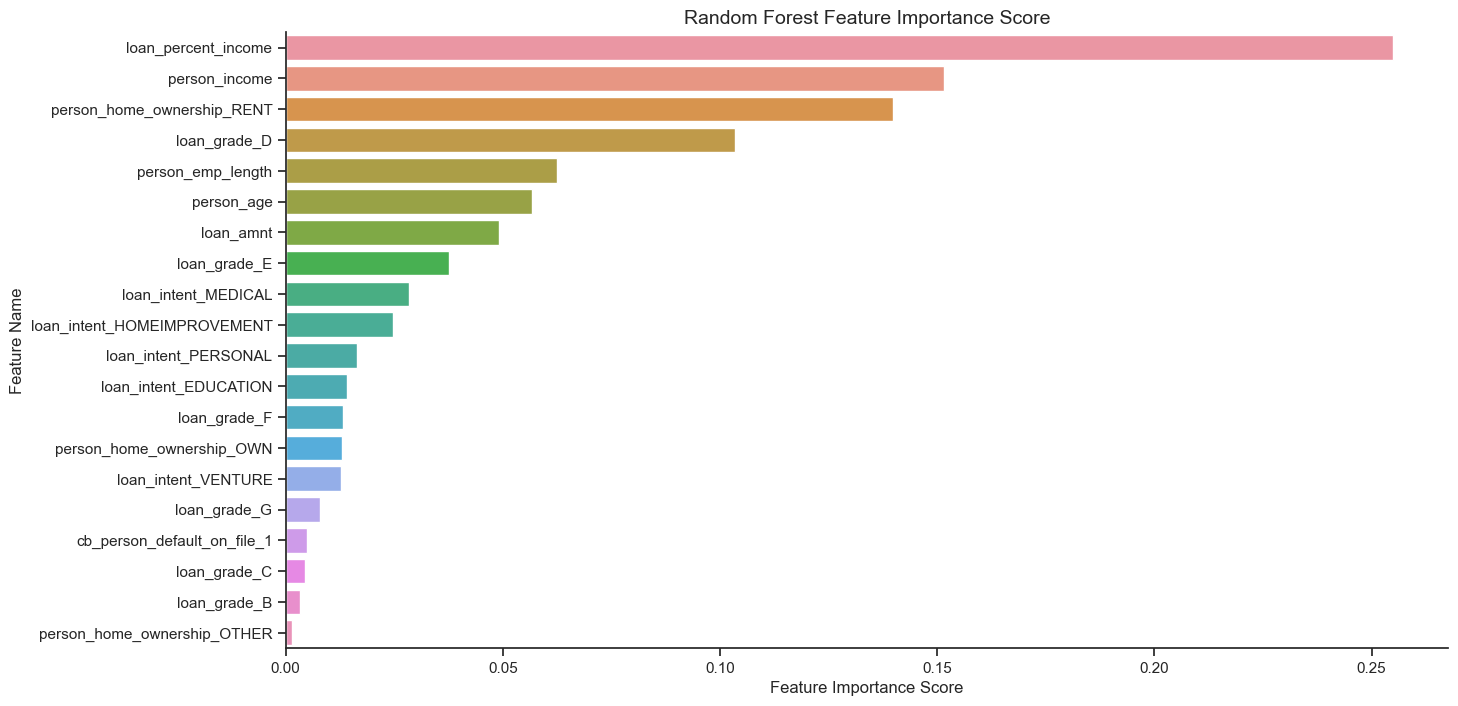

In [87]:
f.plotFeatureImportance(new_clf.feature_importances_, new_clf.feature_names_in_, 'Random Forest')

## Recall Decision Tree Classifier

In [30]:
# check model

models = [('LR', LogisticRegression(random_state=42)),
          ('DT', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('Ada', AdaBoostClassifier(random_state=42)),
          ('GB', GradientBoostingClassifier(random_state=42)),
          ('ET', ExtraTreesClassifier(random_state=42))
          ]

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_name, result = f.checkModel(models, X, y, kfold=skfold, metric='recall')

LR 	 | cv_score_mean: 0.551559792286491 	 | cv_score_std: 0.013853295809313687
DT 	 | cv_score_mean: 0.7755681812526315 	 | cv_score_std: 0.006107192302597072
RF 	 | cv_score_mean: 0.7242216964464347 	 | cv_score_std: 0.012425294616606138
Ada 	 | cv_score_mean: 0.6551004177561806 	 | cv_score_std: 0.006933634377571906
GB 	 | cv_score_mean: 0.6991123303269885 	 | cv_score_std: 0.015935584961426778
ET 	 | cv_score_mean: 0.6975621433470064 	 | cv_score_std: 0.013462804349196474


<AxesSubplot: title={'center': 'Models Comparison'}, xlabel='Models', ylabel='Metric Recall Score'>

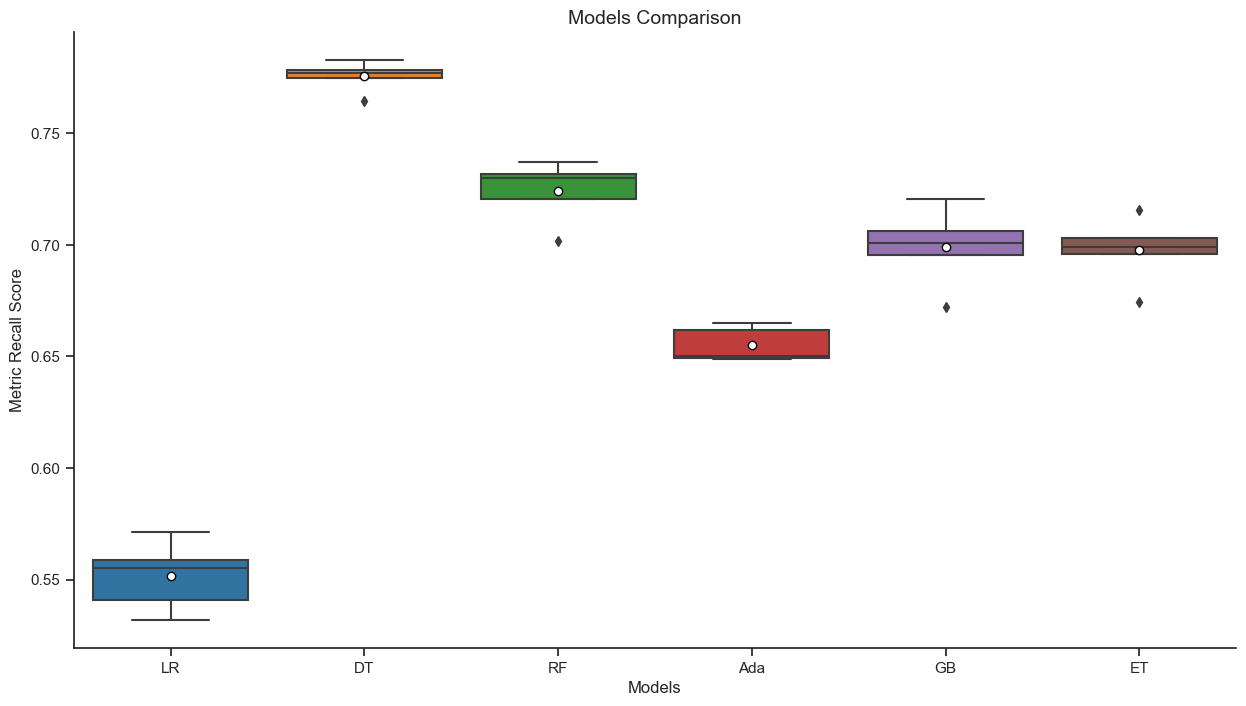

In [31]:
# boxplot model

f.boxplotModel(model_name, result, metric_name='Recall')

We will use Decision Tree Classifier

In [49]:
# train model and predict

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

DecisionTreeClassifier(random_state=42) Evaluation
----------------------------------------------------------------------
Accuracy Score: 0.8981638636012961
Balanced Accuracy Score: 0.8546035050047818
Roc Auc Score: 0.8546035050047818
Precision Score: 0.7621023513139695
Recall Score: 0.7771509167842031
F1 Score: 0.7695530726256984

classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      5063
         1.0       0.76      0.78      0.77      1418

    accuracy                           0.90      6481
   macro avg       0.85      0.85      0.85      6481
weighted avg       0.90      0.90      0.90      6481



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Prediction Labels', ylabel='True Labels'>

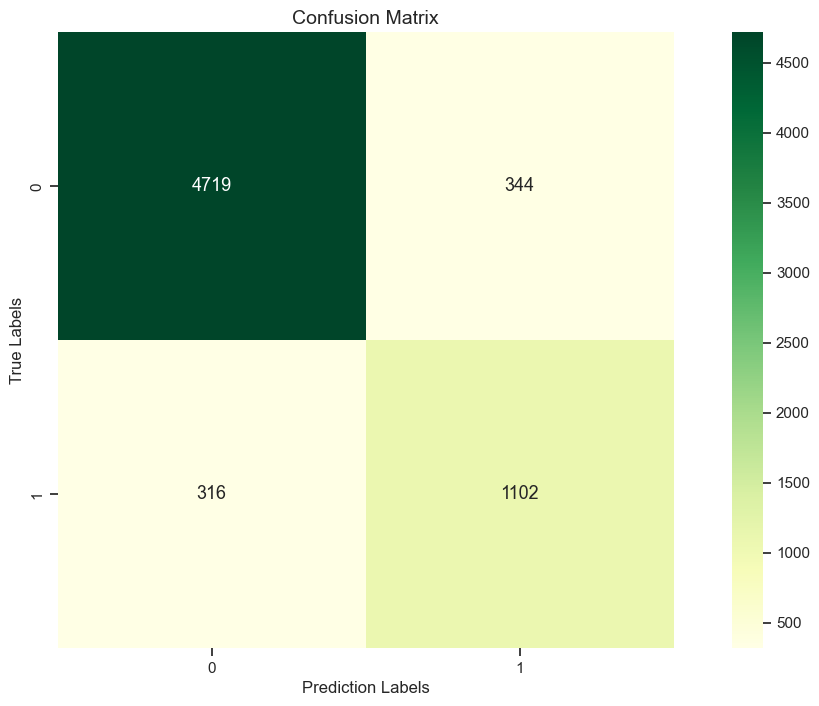

In [50]:
f.evaluateModel(y_test, y_pred, model=clf)

<AxesSubplot: title={'center': 'Decision Tree Feature Importance Score'}, xlabel='Feature Importance Score', ylabel='Feature Name'>

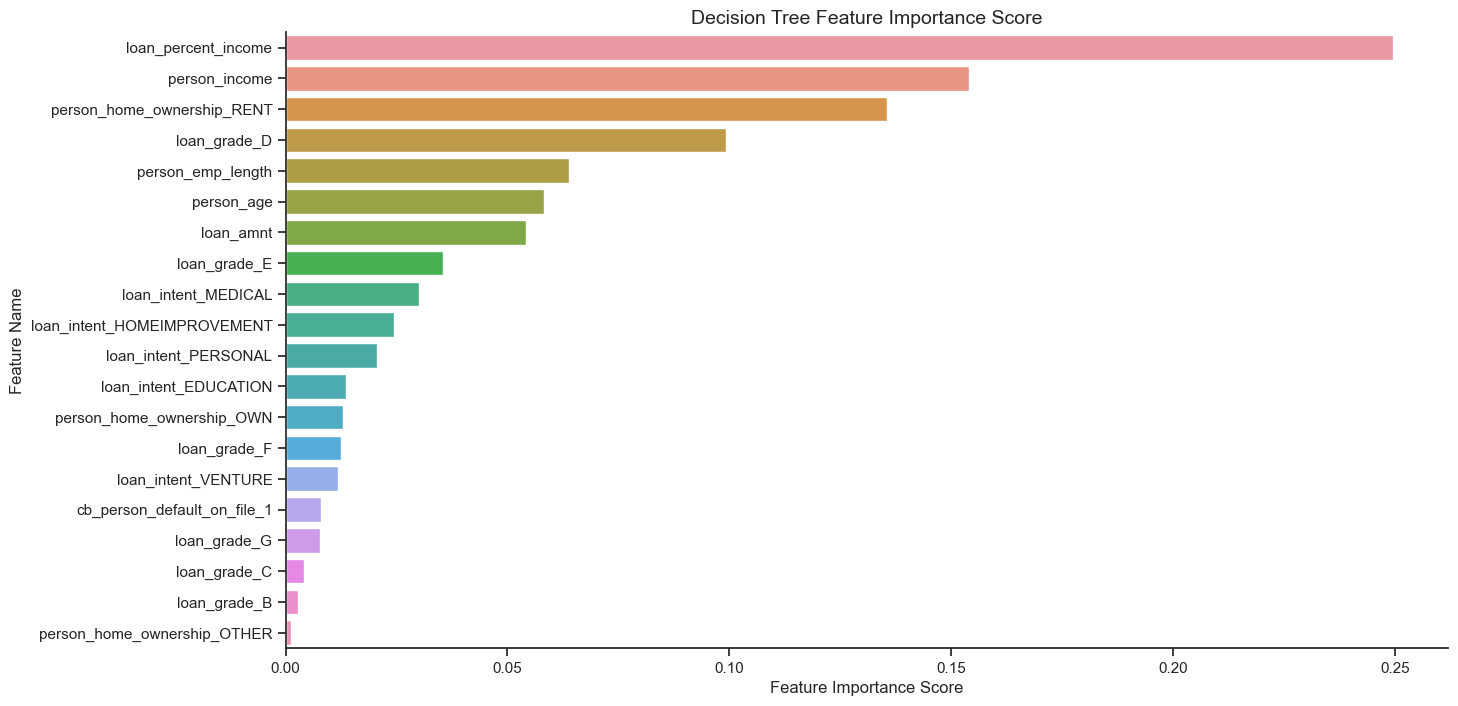

In [51]:
f.plotFeatureImportance(clf.feature_importances_, clf.feature_names_in_, 'Decision Tree')

### Hyperparameter Tuning

In [34]:
param = f.dt_grid_search(X, y, nfolds=5, scoring='recall')
new_clf = DecisionTreeClassifier(random_state=42, **param)

In [35]:
new_clf

DecisionTreeClassifier(criterion='entropy', max_depth=42, random_state=42)

In [36]:
# using tuned decision tree

new_clf.fit(X_train, y_train)
y_pred = new_clf.predict(X_test)

DecisionTreeClassifier(criterion='entropy', max_depth=42, random_state=42) Evaluation
----------------------------------------------------------------------
Accuracy Score: 0.8993982410121895
Balanced Accuracy Score: 0.8546319895410912
Roc Auc Score: 0.8546319895410911
Precision Score: 0.7674581005586593
Recall Score: 0.7750352609308886
F1 Score: 0.7712280701754385

classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      5063
         1.0       0.77      0.78      0.77      1418

    accuracy                           0.90      6481
   macro avg       0.85      0.85      0.85      6481
weighted avg       0.90      0.90      0.90      6481



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Prediction Labels', ylabel='True Labels'>

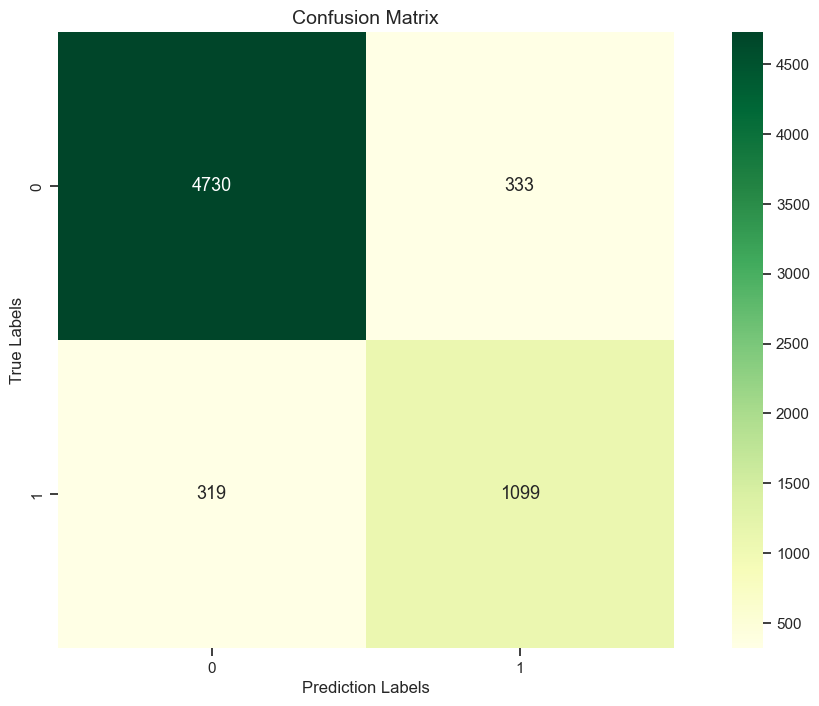

In [37]:
f.evaluateModel(y_test, y_pred, model=new_clf)

In [ ]:
f.plotFeatureImportance(new_clf.feature_importances_, new_clf.feature_names_in_, 'Decision Tree')

## F1-Score Random Forest Credit History Length

In [52]:
X = df.drop(columns=['bad_credit','person_age'])
y = df['bad_credit']

In [36]:
# check model

models = [('LR', LogisticRegression(random_state=42)),
          ('DT', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('Ada', AdaBoostClassifier(random_state=42)),
          ('GB', GradientBoostingClassifier(random_state=42)),
          ('ET', ExtraTreesClassifier(random_state=42))
          ]

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_name, result = f.checkModel(models, X, y, kfold=skfold, metric='f1')


LR 	 | cv_score_mean: 0.6442784550027658 	 | cv_score_std: 0.009324822303525342
DT 	 | cv_score_mean: 0.7572339964250803 	 | cv_score_std: 0.001749378681480923
RF 	 | cv_score_mean: 0.8189765947765993 	 | cv_score_std: 0.00932953488809632
Ada 	 | cv_score_mean: 0.7156642564068709 	 | cv_score_std: 0.004199320278777884
GB 	 | cv_score_mean: 0.7999278653205204 	 | cv_score_std: 0.0118609313328657
ET 	 | cv_score_mean: 0.7862445759173052 	 | cv_score_std: 0.007578430356311084


<AxesSubplot: title={'center': 'Models Comparison'}, xlabel='Models', ylabel='Metric F1 Score'>

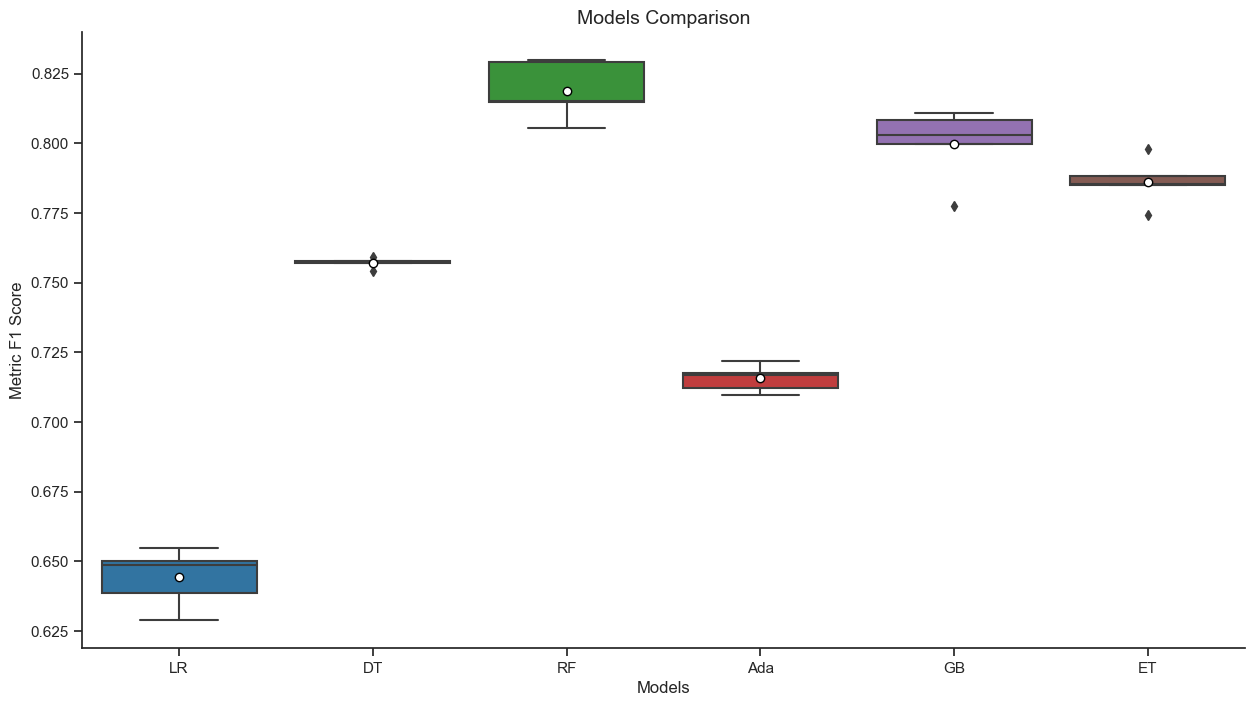

In [37]:
# boxplot model

f.boxplotModel(model_name, result, metric_name='F1')

We will use Random Forest Classifier

In [53]:
# select one split of data for train and test dataset

np.random.seed(42)
n = np.random.randint(0,5)

all_train_idx = []
all_test_idx = []

for train_idx, test_idx in skfold.split(X, y):
    all_train_idx.append(train_idx)
    all_test_idx.append(test_idx)
    
train = df.iloc[all_train_idx[n]]
test = df.iloc[all_test_idx[n]]

# display(train)
# display(test)

X_train = train.drop(columns=['bad_credit','person_age'])
y_train = train['bad_credit']
X_test = test.drop(columns=['bad_credit','person_age'])
y_test = test['bad_credit']

In [54]:
# train model and predict

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

RandomForestClassifier(random_state=42) Evaluation
----------------------------------------------------------------------
Accuracy Score: 0.929331893226354
Balanced Accuracy Score: 0.8511976180520366
Roc Auc Score: 0.8511976180520365
Precision Score: 0.9528301886792453
Recall Score: 0.7122708039492243
F1 Score: 0.8151735270379338

classification report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.96      5063
         1.0       0.95      0.71      0.82      1418

    accuracy                           0.93      6481
   macro avg       0.94      0.85      0.89      6481
weighted avg       0.93      0.93      0.93      6481



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Prediction Labels', ylabel='True Labels'>

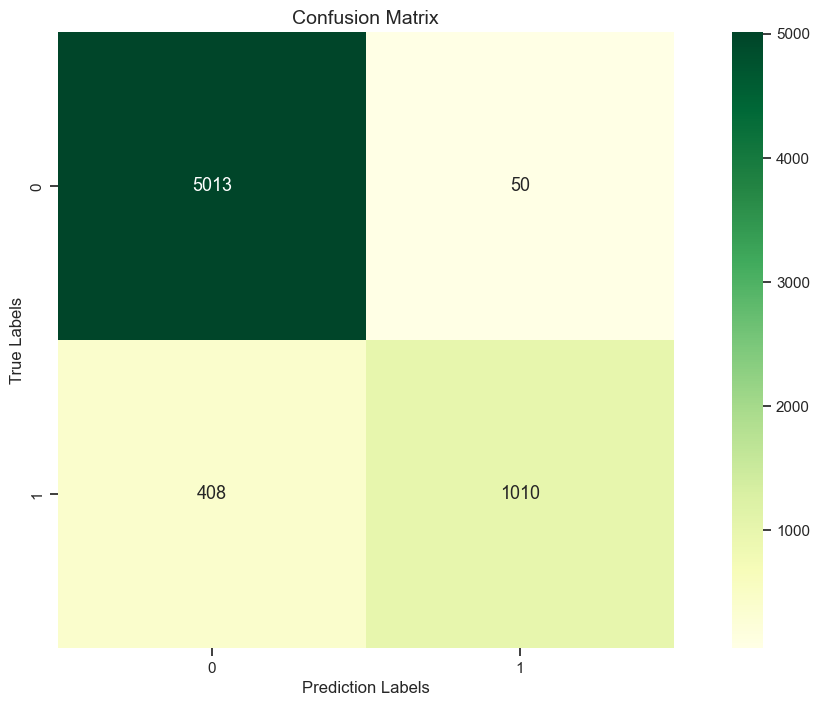

In [55]:
f.evaluateModel(y_test, y_pred, model=clf)

<AxesSubplot: title={'center': 'Random Forest Feature Importance Score'}, xlabel='Feature Importance Score', ylabel='Feature Name'>

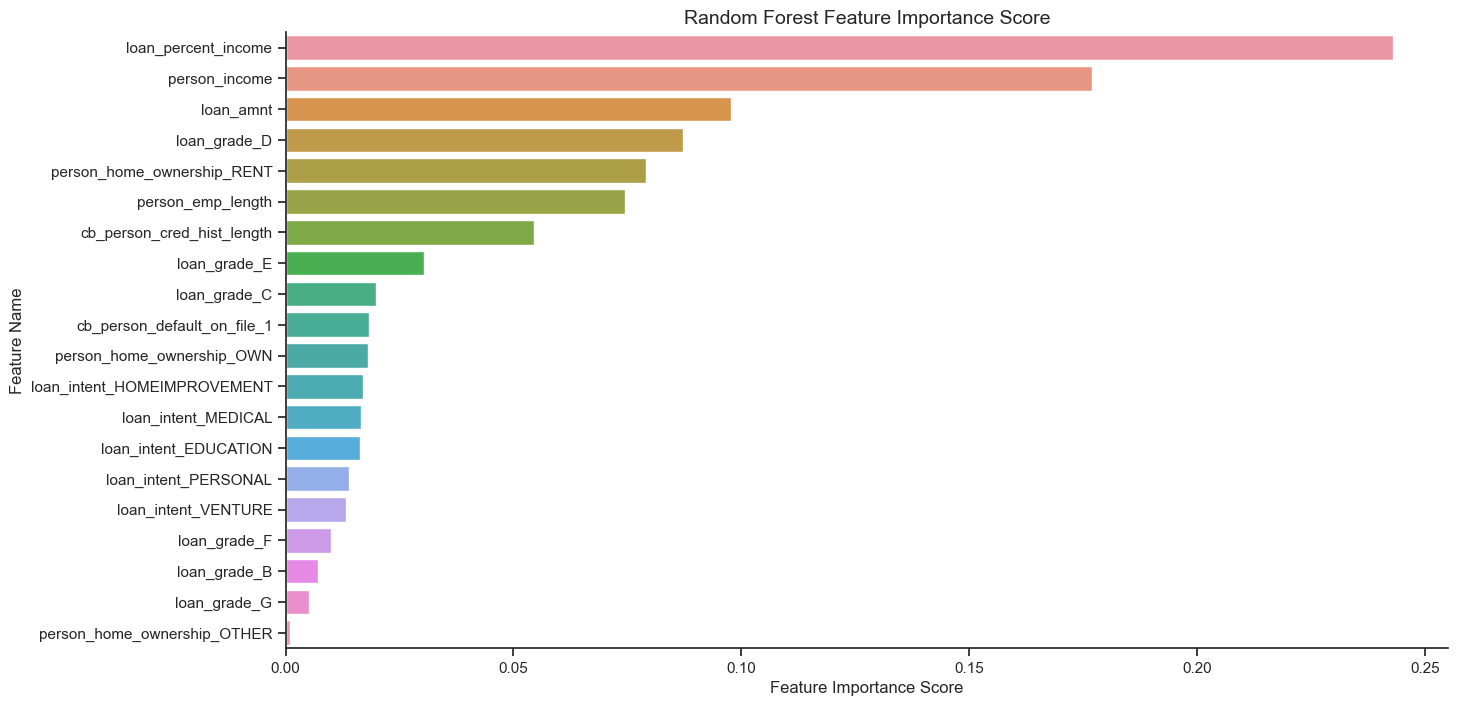

In [56]:
f.plotFeatureImportance(clf.feature_importances_, clf.feature_names_in_, 'Random Forest')

## Recall Decision Tree Classifier with Credit History Length

In [57]:
# check model

models = [('LR', LogisticRegression(random_state=42)),
          ('DT', DecisionTreeClassifier(random_state=42)),
          ('RF', RandomForestClassifier(random_state=42)),
          ('Ada', AdaBoostClassifier(random_state=42)),
          ('GB', GradientBoostingClassifier(random_state=42)),
          ('ET', ExtraTreesClassifier(random_state=42))
          ]

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model_name, result = f.checkModel(models, X, y, kfold=skfold, metric='recall')

LR 	 | cv_score_mean: 0.5515596927496359 	 | cv_score_std: 0.013418801116822515
DT 	 | cv_score_mean: 0.7689396239298544 	 | cv_score_std: 0.010709696026833455
RF 	 | cv_score_mean: 0.7185796488936976 	 | cv_score_std: 0.013452529668927057
Ada 	 | cv_score_mean: 0.6546772865855176 	 | cv_score_std: 0.00583352652863879
GB 	 | cv_score_mean: 0.6974200047180469 	 | cv_score_std: 0.018656473676299183
ET 	 | cv_score_mean: 0.6922018846308128 	 | cv_score_std: 0.01371627292269393


<AxesSubplot: title={'center': 'Models Comparison'}, xlabel='Models', ylabel='Metric Recall Score'>

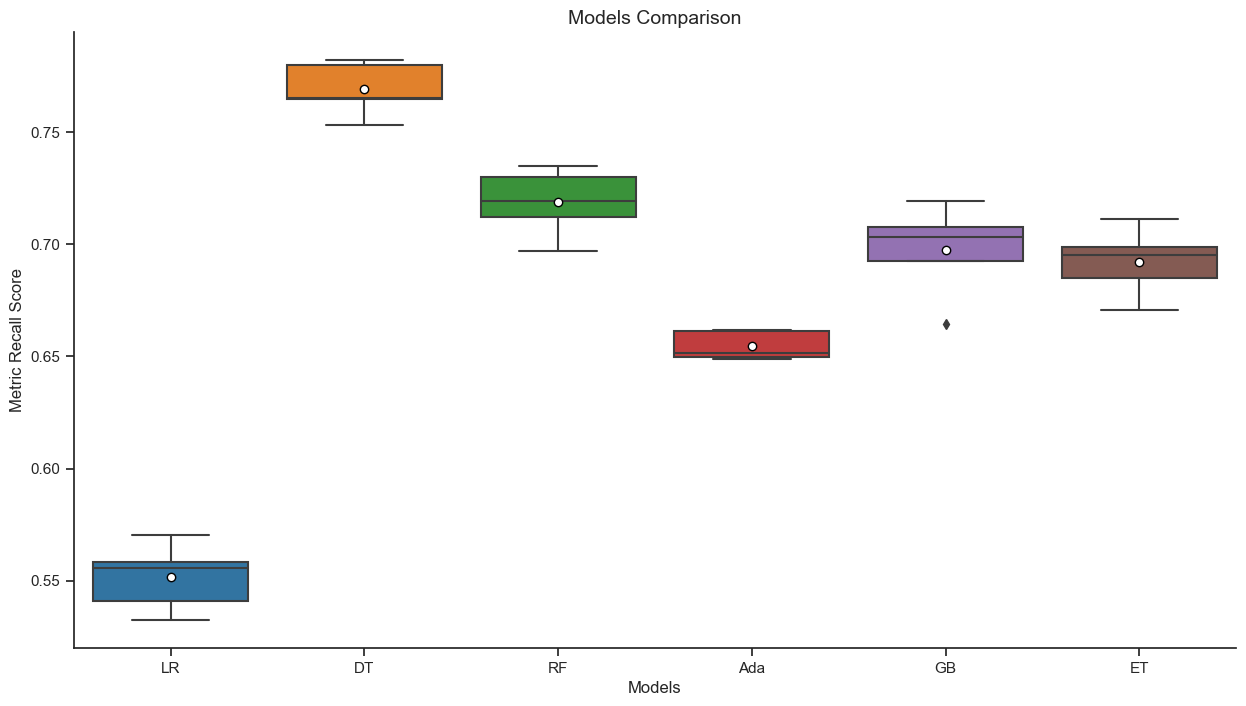

In [58]:
# boxplot model

f.boxplotModel(model_name, result, metric_name='Recall')

We will use Decision Tree Classifier

In [59]:
# train model and predict

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

DecisionTreeClassifier(random_state=42) Evaluation
----------------------------------------------------------------------
Accuracy Score: 0.8930720567813609
Balanced Accuracy Score: 0.8470290558984999
Roc Auc Score: 0.8470290558984997
Precision Score: 0.7508650519031141
Recall Score: 0.7651622002820875
F1 Score: 0.7579462102689487

classification report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      5063
         1.0       0.75      0.77      0.76      1418

    accuracy                           0.89      6481
   macro avg       0.84      0.85      0.84      6481
weighted avg       0.89      0.89      0.89      6481



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Prediction Labels', ylabel='True Labels'>

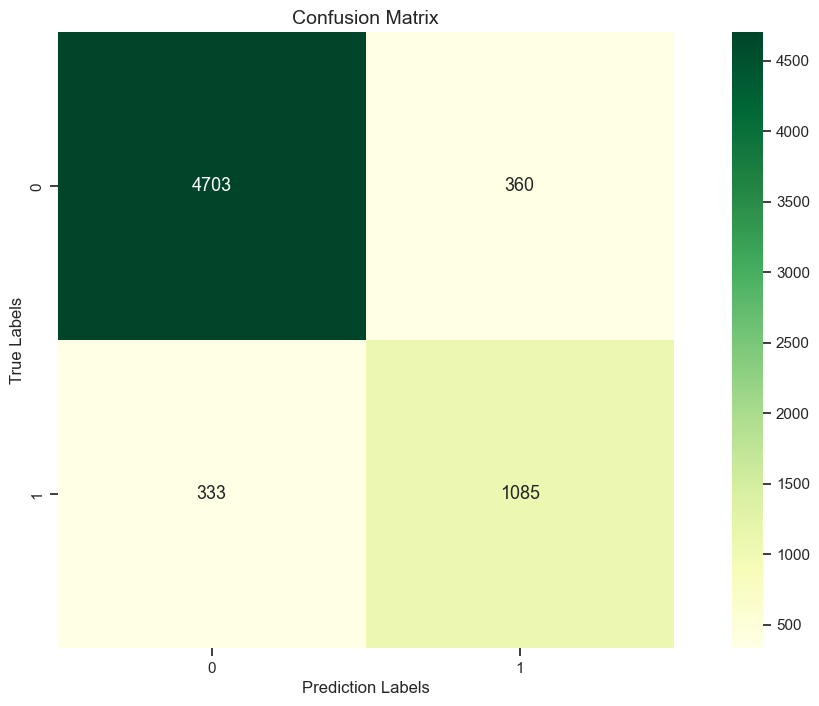

In [60]:
f.evaluateModel(y_test, y_pred, model=clf)

<AxesSubplot: title={'center': 'Decision Tree Feature Importance Score'}, xlabel='Feature Importance Score', ylabel='Feature Name'>

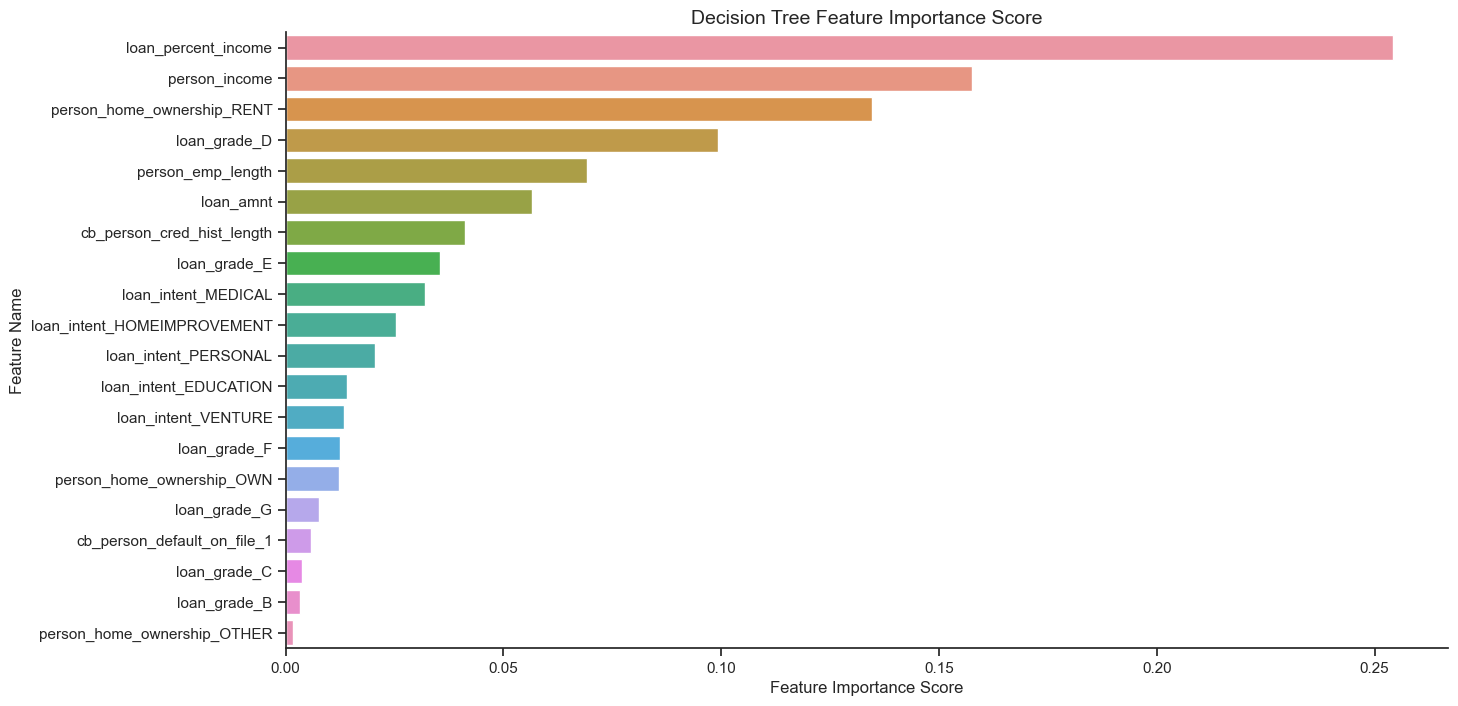

In [61]:
f.plotFeatureImportance(clf.feature_importances_, clf.feature_names_in_, 'Decision Tree')